README:  
Introcuction: This script is for figure 4 in fullscope analysis(celltype spatial DTU feature analysis)  
Author: Y0NEKO  
Time: 2024.03.28  

In [ ]:
#load package
library(data.table)
library(qs)
library(GenomicRanges)
library(GenomicFeatures)
library(rtracklayer)
library(dplyr)
library(ggbio)
library(reshape2)
library(ggsci)
library(viridis)
library(ggpubr)
library(ggh4x)
library(ggtranscript)
library(khroma)
library(bambu)
library(ggdensity)
library(Seurat)
library(scCustomize)
library(ComplexUpset)
library(ComplexHeatmap)
library(randomcoloR)
library(ggsignif) # Significance Brackets for 'ggplot2'
library(gghalves)

qs 0.25.5

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:data.table’:

    first, second


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: I

In [ ]:
#load data
setwd("/cluster/home/liuhengxin/P1_brain_nanopore/downstream_analysis/")
MySplit = function(str,sep, n){
  return(unlist(lapply(strsplit(str,sep),"[[",n)))
}
cellan = read.csv("../ref/T44/cell_type_type20230220-macaque1-contour2_v1.csv")
cellan = unique(cellan[,c("subclass","class")])
areaan = read.csv("../ref/area_annotation.csv")
gtf = rtracklayer::import("ref/bambu_extended_annotations_novelname.gtf")
areaan = unique(areaan[c("L0","L3")])
colnames(areaan) = c("lobe","area")
# areaan[areaan$area == "1/2",]$area = "1|2"
fsraw.cor = qread("data/reads_full_anotation/main_data_read_total_annotation_fil_delete_multiread_25_10_09.qs")
fsraw.cor = fsraw.cor[fsraw.cor$layer %in% paste0("l",1:6),]
isosigls = qread(file = "data/dtu_analysis/dtu_isoform_ls_fsraw_cor_25_10_10.qs")

fsraw.t42 = qread("data/reads_full_anotation/T42_main_data_read_total_annotation_delete_multiread_total_25_12_01.qs")
fsraw.t47 = qread("data/reads_full_anotation/T47_main_data_read_total_annotation_delete_multiread_total_25_12_01.qs")
fsraw.t42 = fsraw.t42[fsraw.t42$layer %in% paste0("l",1:6),]
fsraw.t47 = fsraw.t47[fsraw.t47$layer %in% paste0("l",1:6),]
isosigls.t42 = qread("data/dtu_analysis/T42_dtu_isoform_ls_fsraw_cor_25_12_01.qs")
isosigls.t47 = qread("data/dtu_analysis/T47_dtu_isoform_ls_fsraw_cor_25_12_01.qs")

In [6]:
regionorder = c("29","30","23a","23b","31","23c","1|2","PE","PEa","VIP","LIPv","LIPd","PG","7op","CM","AI","CL","CPB","TPO",
               "PGa","FST","V4t","V4","TEO","TEpd","TEpv","TFO","V3v","V2","v23b")
lobeorder = c('cingulate','somatosensory','parietal','auditory','temporal','occipital')
suborder = c('L2','L2/3','L2/3/4','L3/4','L3/4/5','L4','L4/5','L4/5/6','L5/6','L6','LAMP5','RELN',
             'VIP_RELN','VIP','PV_CHC',"PVALB",'SST','ASC','OLG','OPC','MG','EC','VLMC')

In [10]:
datas4 = list()

In [7]:
theme_presentation<- function(base_size = 16, base_family = "") {
  # Starts with theme_grey and then modify some parts
  theme_bw(base_size = base_size, base_family = base_family) %+replace%
    theme(
      strip.background = element_blank(),
      strip.text.x = element_text(size=16,colour="white"),
      strip.text.y = element_text(size=16,colour="white"),
      axis.text.x = element_blank(),
      axis.text.y = element_blank(),
      axis.ticks =  element_blank(), 
      axis.title.x= element_blank(),
      axis.title.y= element_blank(),
      panel.background = element_rect(fill="black"), 
      panel.border =element_blank(),  
      panel.grid.major = element_blank(), 
      panel.grid.minor = element_blank(), 
      panel.margin = unit(1.0, "lines"), 
      plot.background = element_rect(fill="black"), 
      plot.title =element_text(size=16,colour="white"), 
      # plot.margin = unit(c(1,  1, 1, 1), "lines"),
      legend.background=element_rect(fill='black'),
      legend.title=element_text(size=12,colour="white"),
      legend.text=element_text(size=12,colour="white"),
      legend.key = element_rect( fill = 'black'),
      # legend.key.size = unit(c(0, 0), "lines"),
      axis.line.x = element_blank(),
      axis.line.y = element_blank()
    )
}

### Case plot function

In [17]:
#case plot
BuildPlotBed = function(npclf,nanobed,groupname,geneex,sigtr = NULL){
    readgroup = npclf[npclf$gene_id == geneex,]
    # readgroup = readgroup[readgroup$arealayer %in% paste0("l",1:6),]
    readgroup = unique(readgroup[c("readid","transcript_id","gene_id",
                                   groupname)])
    # readgroup = readgroup %>% group_by(readid) %>% 
    #   mutate(transgroup = 
    #            paste(unique(transcript_id)[order(unique(transcript_id))],
    #                              collapse = "|"))
    readgrt = nanobed[nanobed$name %in% readgroup$readid,]
    readgrt$group = readgroup[match(readgrt$name,
                                    readgroup$readid),
                              groupname]
    # readgrt$transcript_id = readgroup[match(readgrt$name,readgroup$readid),
    #                                   "transcript_id"]
    # readgrt$transgroup = readgroup[match(readgrt$name,readgroup$readid),
    #                                   "transgroup"]
    
    grtdfl = as.data.frame(readgrt)
    colnames(grtdfl)[ncol(grtdfl)] = "group"
    colnames(grtdfl)[6] = "readid"
    grtdfl = merge(grtdfl,readgroup[c("readid",
                              "transcript_id")],
          by = "readid")
    grtdfl = grtdfl[order(grtdfl$transcript_id,
                          grtdfl$start,grtdfl$end),]
    grtdfl = grtdfl[!is.na(grtdfl$group) &
                      grtdfl$group != "",]
    grtdfl
    grtdfl$readord = paste0(grtdfl$transcript_id,"-",grtdfl$readid)
    grtdfl = grtdfl %>% group_by(group) %>% 
      mutate(orid = as.numeric(factor(readord,
                                      levels = unique(readord)))) %>%
      mutate(oridnorm = orid/max(orid))
    grtdfl$sig = "black"
    grtdfl[grtdfl$group %in% sigtr, "sig"] = "red"
    return(grtdfl)
}

IsoformReadPlot = function(gtfp, grtdfl, geneex, onlyhub = T,mycolor = NULL){
    library(randomcoloR)
    library(ggbio)
    library(ggtranscript)
    tartrans = gtfp[which(gtfp$gene_id == geneex),]
    tartrans = as.data.frame(tartrans)
    tartrans = tartrans[tartrans$type == "exon",]
    tartrans = tartrans[order(tartrans$transcript_id),]
    tartrans$orid = as.numeric(factor(tartrans$transcript_id,levels = unique(tartrans$transcript_id)))
    tartrans$group = NA
    if(onlyhub){
      grtdfl = grtdfl %>% group_by(readid) %>% filter(length(unique(transcript_id)) == 1)
      grtdfl$readord = paste0(grtdfl$transcript_id,"-",grtdfl$readid)
      grtdfl = grtdfl %>% group_by(group) %>% 
        mutate(orid = as.numeric(factor(readord,
                                        levels = unique(readord)))) %>%
        mutate(oridnorm = orid/max(orid))
      tartrans = tartrans[tartrans$transcript_id %in% grtdfl$transcript_id,]
    }
    # tartrans = merge(tartrans,unique(grtdfl[c("transcript_id",
    #                                           "transgroup")]),
    #                  by = "transcript_id")
    tartranstx = tartrans %>% group_by(transcript_id,orid) %>% 
      summarise(start = min(start),end = max(end))
    tartranstx$group = NA
    mylim = c(min(tartranstx$start)-1000,max(tartranstx$end)+1000)
    library(ggh4x)
    
    #facetcol = list()
    #facetcoldf = unique(grtdfl[c("group","sig")])
    #facetcoldf = facetcoldf[order(facetcoldf$group,decreasing = F),]
    #for (i in 1:nrow(facetcoldf)) {
    #  facetcol[[i]] = element_text(color = facetcoldf[i,]$sig)
    #}
    #facetcol[[nrow(facetcoldf)+1]] = element_text(color = "black")
    grtdflin = to_intron(grtdfl,
                     "readord")
    no_of_colors = length(unique(grtdfl$transcript_id)) 
    colorful_palette = distinctColorPalette(no_of_colors) 
    names(colorful_palette) = unique(grtdfl$transcript_id)
    if(!is.null(mycolor)){
        colorful_palette = mycolor
    }

    
    pc = ggplot(grtdfl,aes(x = start,xend = end,
                      y = orid,
                      yend = orid,
                      fill = transcript_id,color = transcript_id)) +
      geom_segment(size = 0.5) +
      geom_segment(data = grtdflin,
                   aes(x = start,xend = end,
                       y = orid,
                       yend = orid),
                   size = 0.03,alpha = 0.5,color = "grey") +
      geom_range(data = tartrans,
                 aes(xstart = start,xend = end,
                     y = orid,
                     fill = transcript_id,color = transcript_id),
                 size = 0.2) +
      geom_intron(data = to_intron(tartrans,
                                   "transcript_id"),
                  aes(xstart = start,xend = end,strand = strand),
                  size = 0.2,
                  arrow.min.intron.length = 200,
                  arrow = arrow(length=unit(0.3,"cm"))) +
      geom_text(data = tartranstx,
                aes(x = (start + end) / 2,y = orid,
                    label = transcript_id),
                size = 3, vjust = -0.1, color = "black") +
     # facet_grid2(group~.,scales = "free",
     #             strip = strip_themed(
     #               text_y = facetcol
    #            )) +
      facet_wrap(group~.,scales = "free",ncol = 1,strip.position = "top") +
      scale_x_continuous(limits = mylim)+
      scale_color_manual(values = colorful_palette) +
      scale_fill_manual(values = colorful_palette) +
      # scale_fill_discreterainbow() +
      # scale_color_discreterainbow() +
      theme_void() + 
      ggtitle(geneex) +
      theme(legend.position = "none",
            panel.spacing = unit(0,'lines'),
            strip.background = element_rect(fill = NA,color = NA),
           strip.placement = "outside",
           plot.title = element_text(hjust = 0.5))
    pc
    
    return(pc)
}
#fsraw.cor = fsraw[fsraw$layer %in% paste0("l",1:6),]
#
IsoformReadPlotTotal = function(fsraw,isosigi,longbed,gtf,geneex,hubtrans = NULL,onlyhub = F,mycolors =NULL){
    transname = unique(isosigi[isosigi$gene_id %in% geneex,]$transcript_id)
    if(!is.null(hubtrans)){
        transname = hubtrans
    }
    if(is.null(mycolors)){
        mycolors = distinctColorPalette(length(transname))
        names(mycolors) = transname
    }
    grtdfl = BuildPlotBed(fsraw,longbed,'areatr',geneex,NULL)
    grtdfl = grtdfl[grtdfl$transcript_id %in% transname,]
    
    pci1 = IsoformReadPlot(gtf, grtdfl, geneex,onlyhub,mycolors)
    pci1
    return(pci1)
}

CaseCountPlotBox = function(fsraw,geneex,transname,mycolors = NULL){
    npcase1 = fsraw[fsraw$gene_id == geneex,]
    npcase1 = npcase1[npcase1$transcript_id %in% transname,]
    if(is.null(mycolors)){
        mycolors = distinctColorPalette(length(unique(npcase1$transcript_id)))
    }
    npcase1 = npcase1 %>% 
        group_by(areatr,chunk) %>%
        mutate(genecount = length(unique(readid))) %>% 
        filter(genecount > 10) %>%
        group_by(areatr,chunk,transcript_id) %>%
        summarise(count = length(unique(readid)),genecount = genecount[1])
    npcase1 = npcase1[npcase1$areatr != "",]
    
    npcase1$rate = npcase1$count/npcase1$genecount

    npcase1$transid = as.numeric(as.factor(npcase1$transcript_id))
    npcase1$cmpgroup = paste0(substr(npcase1$transid,1,1),
                            "-",npcase1$areatr)
    comparisons = list()
    classid = as.character(unique(npcase1$areatr))
    n = 1
    for(i in 1:length(classid)){
        for(j in (i+1):length(classid)){
            comparisons[[n]] = c(classid[i],classid[j])
            n = n + 1
        }
    }
    
    npcase1m = npcase1 %>% group_by(areatr,transcript_id) %>% summarise(mean = mean(rate))
    
    pci2 = ggplot(npcase1,
                  aes(x = areatr, y = rate, color = transcript_id)) +
      geom_boxplot() +
      geom_point(data = npcase1m,aes(x = areatr, y = mean,
                                    color = transcript_id),
                 position = position_dodge(0.75)) +
      # geom_line(data = npcase1m,aes(x = areatr, y = mean,
      #                              group = transcript_id),
      #           position = position_dodge(0.75)) +
      stat_compare_means(label = "p.signif",hide.ns = T,method = "t.test",vjust = 0.7,ref.group = ".all.") + 
      scale_color_manual(values = mycolors) +
      theme_pubr() + 
    theme(axis.text.x = element_text(angle = 45,vjust = 0.5)) +
    xlab("") + ylab("Isoform read ratio")
    return(pci2)
}

CasePlotTotalClass = function(fsraw,isosigi,gtf,geneex,hubtrans = NULL,markdfb,edgesdf){
    transname = unique(isosigi[isosigi$gene_id %in% geneex,]$transcript_id)
    if(!is.null(hubtrans)){
        transname = hubtrans
    }
    mycolors = distinctColorPalette(length(transname))
    print(mycolors)
    names(mycolors) = transname
    grtdfl = BuildPlotBed(fsraw,longbed,'areatr',geneex,NULL)
    print(head(grtdfl))
    grtdfl = grtdfl[grtdfl$transcript_id %in% transname,]
    
    pci1 = IsoformReadPlot(gtf, grtdfl, geneex,onlyhub = F,mycolors)
    pci1
#ggexport(p0c1,filename = "processed/figures/f3/bambu_cell_case_NNvsNeuron_CDC42.pdf",
#           width = 6,height = 5)

    npcase1 = fsraw[fsraw$gene_id == geneex,]
    npcase1 = npcase1 %>% 
        group_by(areatr,chunk) %>%
        mutate(genecount = length(unique(readid))) %>% 
        filter(genecount > 10) %>%
        group_by(areatr,chunk,transcript_id) %>%
        summarise(count = length(unique(readid)),genecount = genecount[1])
    npcase1 = npcase1[npcase1$areatr != "",]
    npcase1 = npcase1[npcase1$transcript_id %in% transname,]
    npcase1$rate = npcase1$count/npcase1$genecount

    npcase1$transid = as.numeric(as.factor(npcase1$transcript_id))
    npcase1$cmpgroup = paste0(substr(npcase1$transid,1,1),
                            "-",npcase1$areatr)
    comparisons = list()
    classid = as.character(unique(npcase1$areatr))
    n = 1
    for(i in 1:length(classid)){
        for(j in (i+1):length(classid)){
            comparisons[[n]] = c(classid[i],classid[j])
            n = n + 1
        }
    }


    
    npcase1m = npcase1 %>% group_by(areatr,transcript_id) %>% summarise(mean = mean(rate))
    
#library(ggstatsplot)

    pci2 = ggplot(npcase1,
                  aes(x = areatr, y = rate, color = transcript_id)) +
      geom_boxplot() +
      geom_point(data = npcase1m,aes(x = areatr, y = mean,
                                    color = transcript_id),
                 position = position_dodge(0.75)) +
      geom_line(data = npcase1m,aes(x = areatr, y = mean,
                                   group = transcript_id),
                position = position_dodge(0.75)) +
      stat_compare_means(label = "p.signif",hide.ns = T,method = "t.test",vjust = 0.7,ref.group = ".all.") + 
      scale_color_manual(values = mycolors) +
      theme_pubr() + xlab("") + ylab("Isoform read ratio")
    
#     pci2 = ggbarplot(npcase1,
#                     x = "areatr", y = "rate", 
#                     fill = "areatr",size = 0.5,
#                     width = 0.7,facet.by = "transcript_id",
#                     add = c("mean_se")) +
#         geom_jitter(data = npcase1,
#                 aes(x = areatr, y = rate),size = 0.3,
#                     width = 0.25) +
#         scale_fill_flatui() +
# #        scale_fill_manual(values = mycolors) +
#         stat_compare_means(label = "p.signif",hide.ns = T,method = "t.test",vjust = 0.7,
#                            ref.group = ".all.") + 
#         xlab("") + ylab("Isoform ratio") + labs(fill = "") +
#         theme_pubr() + 
#     theme(axis.text.x = element_blank(),
#          axis.ticks.x = element_blank(),
#           legend.position = "bottom")
#     pci2
    pci3 = MarkerSpPlot(fsraw.cor,markdfb,geneex,hubtrans,edgesdf,200)
    #pci3 = MarkerSpPlot(fsrawdp.cell,fsrawdp.cellb,geneex,mycolors,hubtrans)
    
    pci = ggarrange(ggarrange(pci1,pci2,widths = c(1.5,2),ncol = 1),pci3,nrow = 1)
    return(pci)
}



In [18]:
#spatial point plot
MarkerSpPlot = function(npclfdp.cell,npclfdp.cellb,geneex,edgesdf,mycolor = NULL,hubtrans = NULL){
    markdf = npclfdp.cell[npclfdp.cell$gene_id %in% geneex,]
    if(!is.null(hubtrans)){
        markdf = markdf[markdf$transcript_id %in% hubtrans,]
    }
    markdfb = npclfdp.cellb[!npclfdp.cellb$cell_id %in% markdf$cell_id,]
    markdf = markdf %>% group_by(cell_id,gene_id) %>% mutate(readrate = readnum/sum(readnum))
    markdf = markdf[markdf$readrate > 0.5,]
    markdfst = markdf %>% group_by(transcript_id) %>% summarise(cellnum = length(cell_id))
    markdfst$cellpop = markdfst$cellnum/sum(markdfst$cellnum)
    markdfst = markdfst[markdfst$cellpop > 0.01,]
    markdf = markdf[markdf$transcript_id %in% markdfst$transcript_id,]

    if(is.null(mycolor)){
        mycolor = distinctColorPalette(length(unique(markdf$transcript_id)))
    }
    
    pmkpti = ggplot() +
      scattermore::geom_scattermore(
        data = markdfb,
        aes(x,y),
        color = "white",
        # pixels = raster.dpi,
        pointsize = 0.05
      ) +
      geom_segment(data = edgesdf, aes(x = x1, y = y1, xend = x2, yend = y2),
                 size = 0.005,color = "white",alpha = 0.25) + 
      geom_point(data = markdf,
                 aes(x,y,color = transcript_id,size = readnum)) + 
      scale_size(range = c(0.05,0.1)) +
      # facet_wrap(~gene_id,nrow = 2) +
      theme_void() + 
      scale_color_manual(values = mycolor) +
      theme_presentation() + 
      theme(legend.position = "top",legend.title = element_blank(),
            legend.text = element_text(size = 6)) +
      guides(color = guide_legend(override.aes = list(size=4),
                                  nrow = 2),
            size = "none") +
      scale_y_reverse() + scale_x_reverse()
    pmkpti
    return(pmkpti)
}
  # selectedhub  = c("APOE","CALB1","NEFM","SCN1B","SMYD2","PLP1")

In [701]:
#filter isoform and stat diversity
genetrst = fsrawdp %>% group_by(layer,gene_id) %>% 
    mutate(readnumt = length(unique(readid))) %>% 
    group_by(layer,gene_id,transcript_id)  %>% 
    summarise(readnum = length(unique(readid)),
              readnumt = readnumt[1],
              readrate = readnum/readnumt)
fsgenest = fsrawdp %>% group_by(layer, gene_id) %>% summarise(readnum = length(unique(readid)))
summary(genetrst$readrate)
genetrstf = genetrst[genetrst$readrate > 0.05,]

`summarise()` has grouped output by 'layer', 'gene_id'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'layer'. You can override using the
`.groups` argument.


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000076 0.1052632 0.9756098 0.6545633 1.0000000 1.0000000 

In [639]:
pref = qread("../ref/area_figure_an.qs")

fsrawdp.cell = fsrawdp[fsrawdp$class != "",] %>% 
    group_by(cell_id,gene_id,transcript_id,class,subclass) %>%
    summarise(x = mean(x),y = mean(y),
              readnum = length(unique(readid)))
fsrawdp.cellb = qread("data//reads_full_anotation/longread_cell_position_24_03_29.qs")
fsrawdp.cell = fsrawdp.cell %>% group_by(cell_id,gene_id) %>% mutate(readnumg = sum(readnum),transprop = readnum/readnumg)
summary(fsrawdp.cell$transprop)
fsrawdp.cellf = fsrawdp.cell[fsrawdp.cell$transprop > 0.8,]
nrow(fsrawdp.cell)
nrow(fsrawdp.cellf)
#fsrawdp.cellf = fsrawdp.cellf[fsrawdp.cellf$transcript_id %in% genetrstf$transcript_id,]
nrow(fsrawdp.cellf)


`summarise()` has grouped output by 'cell_id', 'gene_id', 'transcript_id',
'class'. You can override using the `.groups` argument.


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.05556 1.00000 1.00000 0.99580 1.00000 1.00000 

[1] 13508004

[1] 13397480

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'table' in selecting a method for function '%in%': object 'genetrstf' not found


In [640]:
edgesdf = pref$layeredges
edgesdf = edgesdf[edgesdf$areaid %in% paste0("l",1:6),]
head(edgesdf)

ind1  ind2  x1    y1    x2    y2    mx1      my1      mx2      my2     
1385  7285 15438 46436 64705 46518 64693 46540.49 65132.87 46469.34 64646.63
1386 16616 14951 46175 64676 46269 64674 46231.50 65121.50 46222.69 64707.37
1387 33735 16616 46030 64696 46175 64676 46208.15 65451.96 46115.36 64779.21
1388  3003 20924 46995 64656 46782 64591 46877.42 64659.80 46837.73 64789.86
1389  4687 20924 46649 64706 46782 64591 46837.73 64789.86 46793.15 64738.31
1390 32454 32318 47230 64665 47072 64696 47156.98 64710.96 47480.06 66357.65
     bp1 bp2 areaid
1385 0   0   l1    
1386 0   0   l1    
1387 0   0   l1    
1388 0   0   l1    
1389 0   0   l1    
1390 0   0   l1

In [ ]:
#fsraw.cor = fsrawdp[fsrawdp$subclass %in% cellan[cellan$class %in% c("GLU"),]$subclass,]
isosigi = isosigls$subclass
isosigi = isosigi[isosigi$sig != "N",]
gmksi = unique(isosigi$gene_id)
length(gmksi)
pcls.glu = list()
for(i in 1:length(gmksi)){
    print(i)
    grtdfl = BuildPlotBed(fsraw.cor,longbed,"subclass",gmksi[i],NULL)
    pcls.glu[[i]] = tryCatch(IsoformReadPlot(gtf, grtdfl, gmksi[i],onlyhub = T), 
                                                  error = function(e) NULL)
                               
}
ggexport(pcls.glu,filename = "result/figure4/dtu_case_ls_subclass_24_09_17.pdf",
           width = 10,height = 18)
                             

[1] 1948

[1] 1


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 2


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 3


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 4


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 5


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 6


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 7


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 8


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 9


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 10


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 11


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 12


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 13


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 14


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 15


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 16


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 17


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 18


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 19


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 20


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 21


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 22


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 23


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 24


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 25


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 26


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 27


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 28


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 29


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 30


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 31


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 32


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 33


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 34


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 35


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 36


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 37


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 38


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 39


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 40


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 41


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 42


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 43


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 44


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 45


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 46


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 47


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 48


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 49


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 50


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 51


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 52


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 53


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 54


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 55


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 56


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 57


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 58


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 59


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 60


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 61


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 62


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 63


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 64


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 65


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 66


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 67


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 68


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 69


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 70


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 71


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 72


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 73


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 74


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 75


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 76


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 77


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 78


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 79


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 80


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 81


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 82


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 83


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 84


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 85


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 86


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 87


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 88


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 89


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 90


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 91


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 92


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 93


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 94


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 95


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 96


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 97


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 98


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 99


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 100


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 101


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 102


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 103


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 104


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 105


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 106


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 107


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 108


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 109


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 110


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 111


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 112


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 113


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 114


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 115


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 116


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 117


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 118


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 119


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 120


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 121


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 122


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 123


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 124


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 125


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 126


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 127


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 128


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 129


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 130


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 131


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 132


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 133


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 134


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 135


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 136


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 137


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 138


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 139


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 140


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 141


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 142


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 143


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 144


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 145


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 146


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 147


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 148


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 149


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 150


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 151


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 152


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 153


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 154


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 155


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 156


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 157


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 158


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 159


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 160


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 161


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 162


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 163


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 164


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 165


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 166


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 167


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 168


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 169


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 170


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 171


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 172


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 173


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 174


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 175


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 176


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 177


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 178


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 179


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 180


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 181


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 182


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 183


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 184


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 185


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 186


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 187


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 188


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 189


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 190


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 191


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 192


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 193


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 194


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 195


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 196


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 197


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 198


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 199


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 200


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 201


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 202


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 203


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 204


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 205


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 206


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 207


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 208


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 209


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 210


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 211


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 212


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 213


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 214


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 215


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 216


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 217


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 218


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 219


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 220


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 221


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 222


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 223


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 224


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 225


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 226


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 227


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 228


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 229


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 230


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 231


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 232


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 233


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 234


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 235


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 236


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 237


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 238


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 239


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 240


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 241


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 242


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 243


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 244


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 245


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 246


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 247


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 248


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 249


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 250


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 251


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 252


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 253


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 254


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 255


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 256


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 257


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 258


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 259


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 260


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 261


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 262


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 263


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 264


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


In [205]:
#isosigi = isosigls$subclass
#isosigi = isosigi[isosigi$sig != "N",]
caseg = c("INTU",'DNAJC7',"TUSC3","GRIP1","CACNB4","FAM173A","KLC1","MPG","MTG2","EIF5A","ARID4A","SIVA1","IDH3B")

In [221]:
casect = fsraw.cor[fsraw.cor$subclass != "",] %>% group_by(class,subclass,gene_id,transcript_id) %>% 
                summarise(count = length(readid)) %>% 
                group_by(class,subclass,gene_id) %>% 
                mutate(genecount = sum(count),rate = count/genecount)
isosigi = isosigls$subclass
casect = casect[casect$transcript_id %in% isosigi$transcript_id,]
casect = casect[casect$genecount > 20,]
casect = casect[!casect$subclass %in% c("VLMC","VIP","PV_CHC","MG"),]

casect = casect %>% group_by(gene_id) %>% mutate(id = as.character(as.numeric(as.factor(transcript_id))))
casect$gene_tran = paste0(casect$gene_id,"-",casect$id)
library(scatterpie)
casectl = dcast(casect,class+subclass+gene_id~id,value.var = "rate")
casectl[is.na(casectl)] = 0
casectl = casectl[order(casectl$class,casectl$subclass),]
casectl$groupid = as.numeric(factor(casectl$subclass,levels = unique(casectl$subclass)))
casectl$geneidn = as.numeric(factor(casectl$gene_id,levels =caseg))
head(casectl)

`summarise()` has grouped output by 'class', 'subclass', 'gene_id'. You can
override using the `.groups` argument.


class subclass gene_id 1          2          3 4 5 6 7 8 9 groupid geneidn
1 GABA  LAMP5    ABAT    0.02325581 0.88372093 0 0 0 0 0 0 0 1       NA     
2 GABA  LAMP5    ABHD17A 0.95652174 0.04347826 0 0 0 0 0 0 0 1       NA     
3 GABA  LAMP5    ACOT7   0.70000000 0.27500000 0 0 0 0 0 0 0 1       NA     
4 GABA  LAMP5    ACSL6   0.14705882 0.85294118 0 0 0 0 0 0 0 1       NA     
5 GABA  LAMP5    ACTL6B  0.80434783 0.17391304 0 0 0 0 0 0 0 1       NA     
6 GABA  LAMP5    ACTR2   0.59459459 0.40540541 0 0 0 0 0 0 0 1       NA

file saved to result/figure4/case_subclass_isoform_rate_stat_pie_24_09_11.pdf



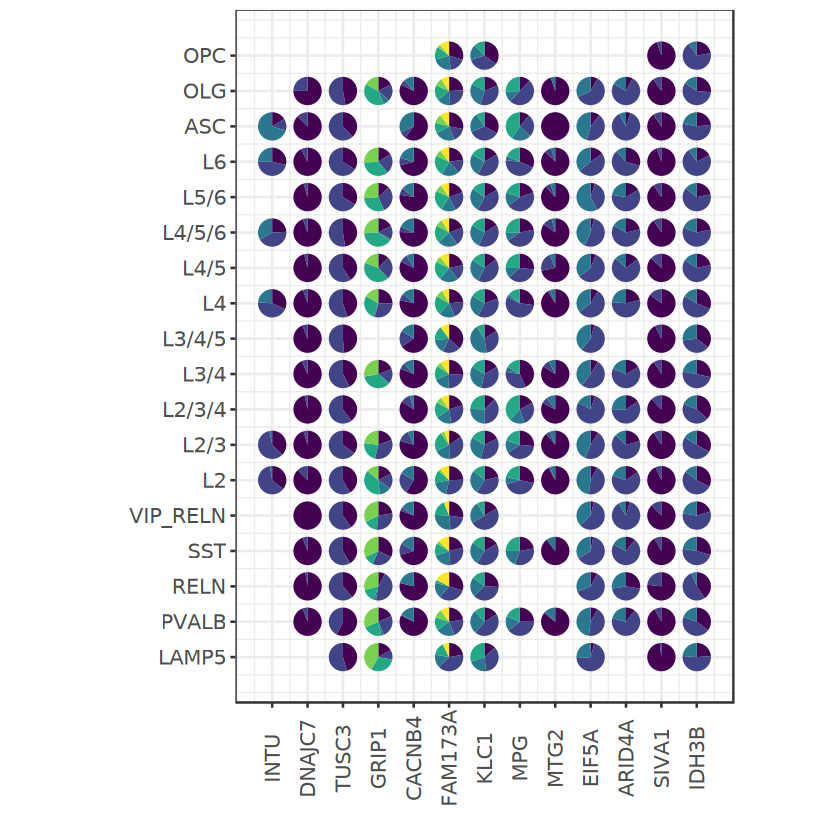

In [223]:
library(patchwork)
caseg = c("INTU",'DNAJC7',"TUSC3","GRIP1","CACNB4","FAM173A","KLC1","MPG","MTG2","EIF5A","ARID4A","SIVA1","IDH3B")
#caseg = c("MYL6",'NTRK2',"DBNDD2","DDRGK1","ARPP19","ARPP21")
casectl$gene_id = factor(casectl$gene_id,levels = caseg)
plt = ggplot() + 
      geom_scatterpie(data = casectl[casectl$gene_id %in% caseg, ],aes(y = groupid, x = geneidn, group = groupid,
                                           r = 0.4),color=NA,
                      cols=colnames(casectl)[4:12]) + 
      coord_fixed() +
      scale_y_continuous(breaks = c(1:length(unique(casectl$subclass))),labels = unique(casectl$subclass)) +
      scale_x_continuous(breaks = c(1:length(caseg)),labels = caseg) +
      # geom_smooth(data = tem2, aes(x=x, y=y), se = F, method = 'loess',color = "black") +
      scale_fill_viridis(discrete=TRUE) +
      #annotate("text", x = 8, y = 7, label = caseg[i], hjust = 1.1, vjust = 1.1, size = 5, angle = 90) +
      ylab("") + xlab("") +
      theme_bw() + theme(legend.position="none",axis.text = element_text(size = 12),
                         axis.text.x = element_text(angle = 90,vjust = 0.5),
                        strip.background =element_rect(fill="white"))
plt
ggexport(plt,filename = "result/figure4/case_subclass_isoform_rate_stat_pie_24_09_11.pdf",width = 4,height = 6)

file saved to result/figure4/case_subclass_isoform_rate_stat_FAM173A_24_09_11.pdf



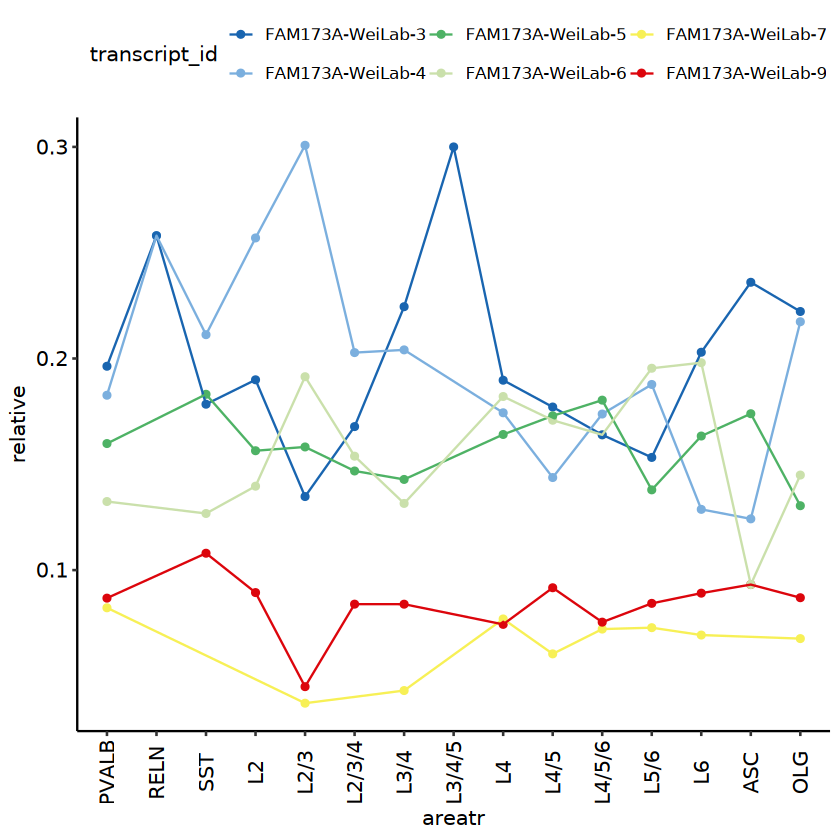

In [236]:
isosigi = isosigls$subclass
isosighub = isosigi[isosigi$gene_id == "FAM173A",]
isosighub = isosighub[!isosighub$areatr %in% c("VLMC","VIP","PV_CHC","MG"),]
isosighub = isosighub[isosighub$count > 10,]
isosighub = merge(isosighub,cellan,by.x = "areatr",by.y = "subclass")
isosighub = isosighub[order(isosighub$class,isosighub$areatr),]
isosighub$areatr = factor(isosighub$areatr,levels = unique(isosighub$areatr))
#head(isosighub)
pc = ggplot(isosighub,aes(x = areatr, y = relative, color = transcript_id,group = transcript_id)) + geom_point() + geom_line() + 
scale_color_discreterainbow() +
theme_pubr() + theme(axis.text.x = element_text(angle = 90,vjust = 0.5))
pc
ggexport(pc,filename = "result/figure4/case_subclass_isoform_rate_stat_FAM173A_24_09_11.pdf",width = 4,height = 4)

`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.
Warning message:
"Removed 399 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 294 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 25 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 8 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 3 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 10 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`g

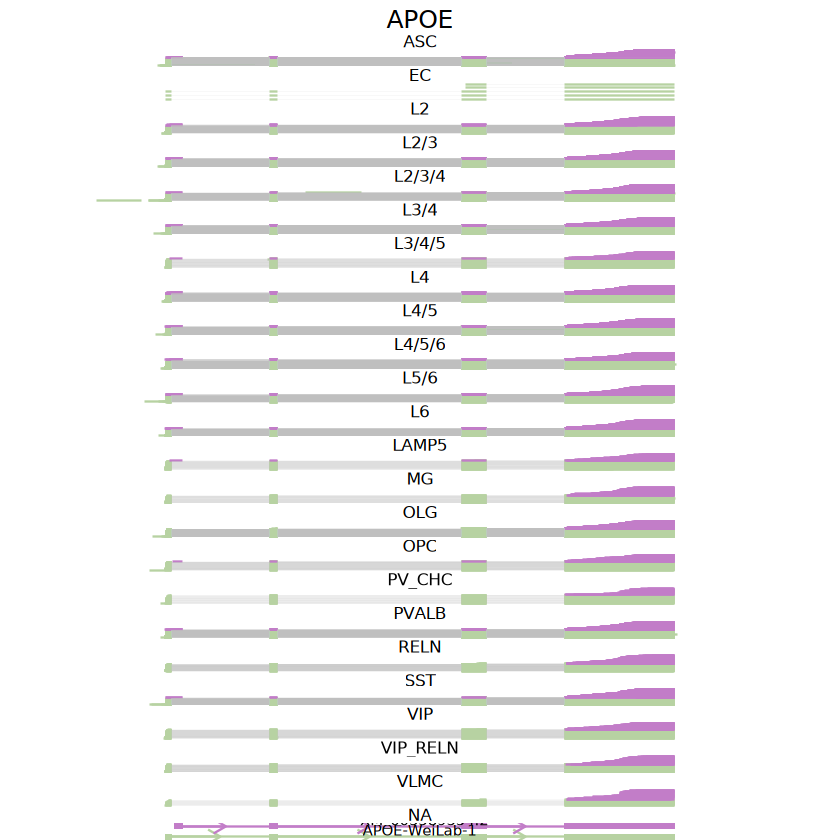

In [204]:
geneex = "APOE"
grtdfl = BuildPlotBed(fsraw.cor,longbed,"subclass",geneex,NULL)
pci = tryCatch(IsoformReadPlot(gtf, grtdfl,geneex,onlyhub = T), 
                                                  error = function(e) NULL)
pci
fileid = paste0("result/figure4/dtu_case_ls_subclass_",geneex,"_24_09_17.pdf")
ggexport(pci,filename = fileid,
           width = 10,height = 20)

`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_segment()`)."


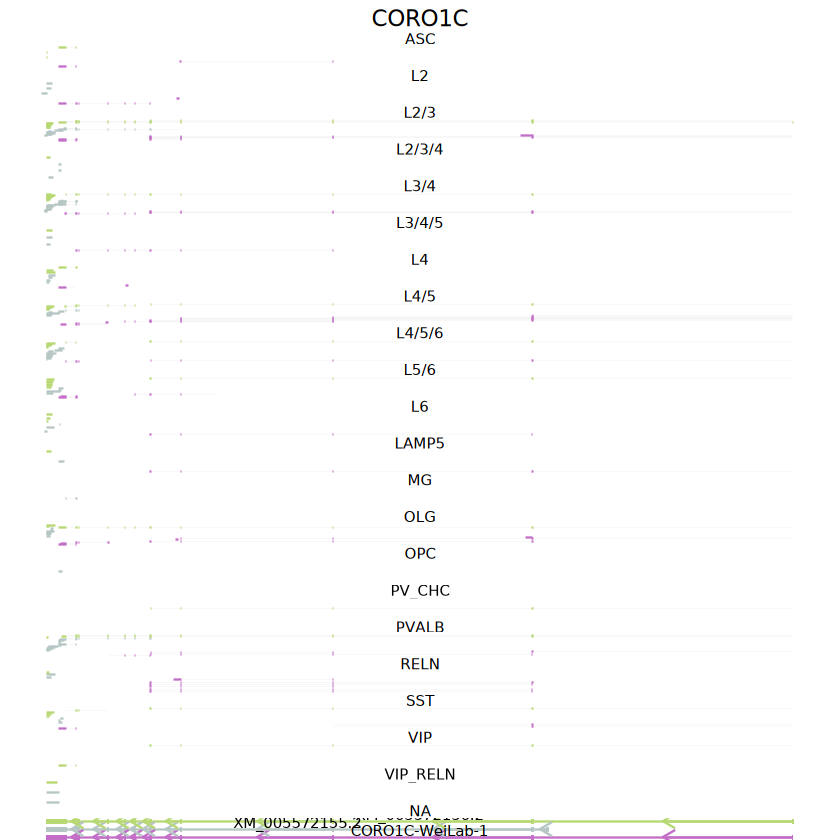

In [141]:
geneex = "LSAMP"
grtdfl = BuildPlotBed(fsraw.cor,longbed,"subclass",geneex,NULL)
pci = tryCatch(IsoformReadPlot(gtf, grtdfl,geneex,onlyhub = T), 
                                                  error = function(e) NULL)
pci

In [198]:
isosiggl = isosigls.cl$GLU_GLU
huntrans1 = unique(isosiggl[isosiggl$sig %in% c("Up","Down"),]$transcript_id)
isosigga = isosigls.cl$GABA_GABA
huntrans2 = unique(isosigga[isosigga$sig %in% c("Up","Down"),]$transcript_id)
isosignn = isosigls.cl$NonNeuron_NonNeuron
huntrans3 = unique(isosignn[isosignn$sig %in% c("Up","Down"),]$transcript_id)
huntrans = c(huntrans1,huntrans2,huntrans3)
isosigi = isosigls$subclass
huntrans = unique(isosigi[isosigi$sig %in% c("Up","Down"),]$transcript_id)

isosiggl = isosiggl[isosiggl$transcript_id %in% huntrans,]
isosiggl = isosiggl[isosiggl$count > 10,]
isosiggl = isosiggl %>% group_by(gene_id,transcript_id) %>% filter(length(areatr) > 1) %>% summarise(drl = max(relative) - min(relative),count = sum(count))

isosigga = isosigga[isosigga$transcript_id %in% huntrans,]
isosigga = isosigga[isosigga$count > 10,]
isosigga = isosigga %>% group_by(gene_id,transcript_id) %>% filter(length(areatr) > 1) %>% summarise(drc = max(relative) - min(relative))

isosignn = isosignn[isosignn$transcript_id %in% huntrans,]
isosignn = isosignn[isosignn$count > 10,]
isosignn = isosignn %>% group_by(gene_id,transcript_id) %>% filter(length(areatr) > 1) %>% summarise(drb = max(relative) - min(relative))

isosigtri = merge(isosiggl,isosigga,by = c("gene_id","transcript_id"))
isosigtri = merge(isosigtri,isosignn,by = c("gene_id","transcript_id"))
head(isosigtri)
nrow(isosigtri)
summary(isosigtri$drl)
summary(isosigtri$drb)
summary(isosigtri$drc)
isosigtri$transname = isosigtri$transcript_id
isosigtri[MySplit(isosigtri$transcript_id,"-",1) != isosigtri$gene_id,]$transname =
paste0(isosigtri[MySplit(isosigtri$transcript_id,"-",1) != isosigtri$gene_id,]$gene_id,"-",
       isosigtri[MySplit(isosigtri$transcript_id,"-",1) != isosigtri$gene_id,]$transname)

`summarise()` has grouped output by 'gene_id'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'gene_id'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'gene_id'. You can override using the
`.groups` argument.


gene_id transcript_id  drl        count drc        drb        
1 AACS    NM_001284010.1 0.17748918 1042  0.08448093 0.167565139
2 ABCC5   XM_005546512.2 0.09204793  718  0.13766234 0.275702734
3 ABHD2   XM_005560462.2 0.29729730  417  0.12527473 0.109890110
4 ABLIM1  XM_005566500.2 0.16936488  693  0.17857143 0.008712016
5 ACBD5   ACBD5-WeiLab-1 0.16368286  192  0.08149038 0.003411306
6 ACBD5   XM_005564836.2 0.26666667  560  0.15064103 0.025828460

[1] 1552

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01295 0.12994 0.18265 0.19734 0.24928 0.59806 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.05429 0.10349 0.12495 0.17778 0.63158 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.09871 0.16157 0.16592 0.22482 0.60000 

file saved to result/figure4/class_within_subclass_dtu_delta_tern_24_09_17.pdf



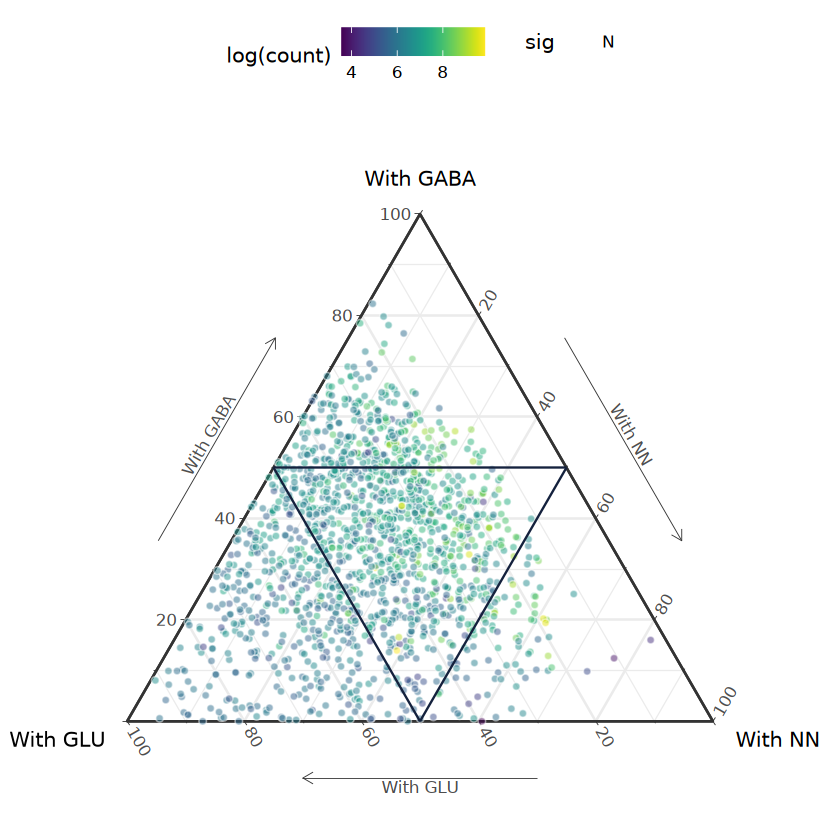

In [203]:
hubtrans = c("XM_015434930.1","XM_005545495.2","DDRGK1-WeiLab-1","XM_005576035.2","XM_005592027.2")
#hubgene = c('AHNAK','AIFM3','CIB1','CTDSP1','DAAM2','FMNL2','INTS10','ITGA7','LITAF','MRVI1')
hubtrans = NULL
hubgene = c("ARPP21","DDRGK1","CAPRIN1","SLC8A1","ARL2BP")
hubgene = NULL
isosigtri$sig = "N"
#isosigtri[isosigtri$transcript_id %in% hubtrans,]$sig = "Y"
#isosigtri[isosigtri$gene_id %in% hubgene,]
#isosigtri[isosigtri$drb > isosigtri$drc & isosigtri$drb > isosigtri$drl,]$sig = "Y"
#isosigtri[isosigtri$drl > isosigtri$drc & isosigtri$drl > isosigtri$drb,]$sig = "Y"
#install.packages("ggtern")
library(ggtern)
library(ggpointdensity)
library(ggrepel)
labFnc <- function(x,digits=1) format(round(unique(x),digits),digits=digits)

mycolors = c("white","red")
names(mycolors) = c("N","Y")
isosigtri = isosigtri[order(isosigtri$sig),]
p2 = ggtern(data=isosigtri,aes(drl,drc,drb,fill = log(count),color = sig)) + 
#geom_pointdensity() +
   geom_mask() +
   geom_point(shape=21,alpha = 0.5) + 
   # geom_text(data=isosigtri[isosigtri$sig != "N",],
   #           aes(drl,drc,drb,label = gene_id),size = 2,color = "black")+
 #  geom_text_repel(data=isosigtri[isosigtri$sig != "N",],aes(drl,drc,drb)) +
   theme_bw() +
   theme_showarrows() +
   theme_clockwise() +
geom_Lline(Lintercept=0.50,color="#14213d") +
geom_Tline(Tintercept=0.50,color="#14213d") +
geom_Rline(Rintercept=0.50,color="#14213d") +
xlab("With GLU")+ 
ylab("With GABA")+
zlab("With NN")+ 
scale_fill_viridis() +
scale_color_manual(values = mycolors) +
theme(legend.position = "top")
p2
ggexport(p2,filename = "result/figure4/class_within_subclass_dtu_delta_tern_24_09_17.pdf",width = 5,height = 5)

In [62]:
library(readxl)
all_sheets <- read_excel("ref/human_Brain_drug_target_and_GPCR_20240826.xlsx", sheet = 1)
head(all_sheets)
tfgene = read.delim("ref/Macaca_fascicularis_TF.txt")
tfgene = unique(tfgene$Symbol)
spgene = read.delim("ref/splicing_factor_gene_in_macaca_fas.txt")
spgene = unique(spgene$Symbol)

HumanGPCR Opentarget-Drugs GPCR-Drugs
1 ACKR1     ABAT             ABAT      
2 ACKR2     ABCA1            ABCA1     
3 ACKR3     ABCC8            ABCC8     
4 ACKR4     ABL1             ABL1      
5 ADCYAP1R1 ACE              ACE       
6 ADGRA1    ACHE             ACHE

In [86]:
rbpgene = read.csv("ref/RBPDB_v1.3.1_proteins_human_2012-11-21.csv",header = F)
head(rbpgene)
rbpgene = unique(rbpgene$V5)
length(rbpgene)

V1   V2              V3         V4         V5   
1 1226 ENSG00000003756 2010-03-18 2010-04-24 RBM5 
2 1228 ENSG00000004534 2010-03-18 2010-04-24 RBM6 
3 1229 ENSG00000005189 2010-03-18 2010-04-05      
4 1230 ENSG00000006047 2010-03-18 2010-04-24 YBX2 
5 1231 ENSG00000009307 2010-03-18 2010-04-29 CSDE1
6 1233 ENSG00000011304 2010-03-18 2010-04-07 PTBP1
  V6                                                                                   
1 RNA binding motif protein 5 [Source:HGNC Symbol;Acc:9902]                            
2 RNA binding motif protein 6 [Source:HGNC Symbol;Acc:9903]                            
3 Putative RNA exonuclease NEF-sp (EC 3.1.-.-) [Source:UniProtKB/Swiss-Prot;Acc:Q96IC2]
4 Y box binding protein 2 [Source:HGNC Symbol;Acc:17948]                               
5 cold shock domain containing E1, RNA-binding [Source:HGNC Symbol;Acc:29905]          
6 polypyrimidine tract binding protein 1 [Source:HGNC Symbol;Acc:9583]                 
  V7           V8   V9               
1 Homo sapiens 9606 RRMx2; Znf_C2H2x1
2 Homo sapiens 9606 RRMx2            
3 Homo sapiens 9606 RRMx2            
4 Homo sapiens 9606 CSDx1            
5 Homo sapiens 9606 CSDx5            
6 Homo sapiens 9606 RRMx4            
  V10                                           V11 V12 V13
1 LUCA15; H37                                   \\N \\N \\N
2 DEF-3; 3G2; NY-LU-12; g16; DEF3               \\N \\N \\N
3                                               \\N \\N \\N
4 MSY2; CSDA3                                   \\N \\N \\N
5 D1S155E; UNR                                  \\N \\N \\N
6 HNRPI; HNRNP-I; PTB2; PTB3; PTB-1; PTB4; pPTB \\N \\N \\N

[1] 407

In [88]:
isosigi = isosigls$subclass
isosigi = isosigi[isosigi$sig != "N",]
hubgene = unique(isosigi$gene_id)
length(hubgene)

length(unique(unlist(all_sheets[,1])))
drugovl = intersect(unique(unlist(all_sheets[,1])),hubgene)
length(drugovl)
drugovl
#all_sheets[all_sheets$HumanGPCR,]

[1] 1948

[1] 402

[1] 9

[1] "ADCYAP1R1" "ADGRB3"    "ADGRG1"    "ADGRL2"    "ADGRL3"    "GPR137"   
[7] "GPR19"     "GRM8"      "TPRA1"

In [89]:
length(unique(tfgene))
drugovl = intersect(unique(tfgene),hubgene)
length(drugovl)
drugovl

[1] 1251

[1] 131

[1] "ZNF385B" "RFX3"    "CCDC88A" "GTF2I"   "TSC22D1" "ZNF740"  "TEF"    
  [8] "SOX6"    "ZNF471"  "MEF2C"   "CREB3L4" "ZNF583"  "ZNF107"  "ZNF567" 
 [15] "HMBOX1"  "ZNF644"  "ZNF322"  "ZNF658"  "BAZ2A"   "ZNF224"  "KLF12"  
 [22] "ZFP30"   "TOX2"    "NFIX"    "ZNF383"  "ZNF446"  "MXI1"    "NR3C2"  
 [29] "ZNF540"  "ZBTB14"  "ZNF292"  "TRERF1"  "ZNF84"   "THAP5"   "ZNF800" 
 [36] "NFIB"    "ZNF585A" "BBX"     "ZNF226"  "HOPX"    "ZNF512"  "ZFPM2"  
 [43] "AFF1"    "NCOA3"   "EGR2"    "ZNF131"  "ZNF142"  "ZNF174"  "SMARCC2"
 [50] "IRF2"    "NFE2L2"  "BCL11A"  "ID4"     "ZEB1"    "ATF2"    "MKX"    
 [57] "ZNF181"  "ZNF362"  "ERF"     "ATF7"    "ZNF576"  "FOXN3"   "ZNF48"  
 [64] "CAMTA1"  "MBD1"    "STAT3"   "ZNF445"  "HBP1"    "ADNP"    "ZBTB38" 
 [71] "CREB1"   "ZHX3"    "NFAT5"   "ZFP62"   "ARNTL"   "ZNF438"  "ZSCAN31"
 [78] "KLF3"    "DDIT3"   "ZNF385A" "PPARD"   "ELF2"    "THRB"    "ZBTB43" 
 [85] "ZNF605"  "AEBP2"   "ZNF521"  "CSRNP3"  "POU6F1"  "ZNF655"  "ZNF135" 
 [92] "THRA"    "CREM"    "TCF7L2"  "MIER1"   "RBAK"    "ZFX"     "ZNF782" 
 [99] "ZNF287"  "ZNF532"  "TSHZ1"   "ARID4A"  "ZBTB20"  "ZBTB44"  "ZFP28"  
[106] "SMARCE1" "DMTF1"   "RORA"    "KMT2C"   "ZNF347"  "ZEB2"    "ZNF528" 
[113] "MBD2"    "TCF12"   "GTF3A"   "ZNF212"  "GPBP1"   "ZGPAT"   "ZNF609" 
[120] "CNBP"    "HIF1A"   "SON"     "CREBRF"  "TMF1"    "ZNFX1"   "RBCK1"  
[127] "ZNF608"  "ZNF326"  "PRDM11"  "AHCTF1"  "GATAD1"

In [92]:
length(unique(spgene))
drugovl = intersect(unique(spgene),hubgene)
length(drugovl)
drugovl

[1] 140

[1] 16

[1] "CCDC12" "CELF5"  "DDX17"  "PHF3"   "PTBP2"  "RBFOX2" "RBM39"  "SF1"   
 [9] "SRSF10" "SRSF11" "SRSF4"  "SRSF5"  "SRSF7"  "TCERG1" "U2AF1"  "YTHDC1"

In [245]:
length(unique(rbpgene))
drugovl = intersect(unique(rbpgene),hubgene)
length(drugovl)
drugovl
isosigtmp = isosigi[isosigi$gene_id %in% drugovl,]
table(isosigtmp$areatr)
isosigtmp

[1] 407

[1] 61

[1] "RBM5"      "MATR3"     "ZC3H11A"   "SPEN"      "ZNF638"    "YTHDC1"   
 [7] "FUS"       "CIRBP"     "RBM23"     "ZC3H14"    "ACIN1"     "ZC3H12B"  
[13] "DNAJC17"   "PPARGC1A"  "KRR1"      "QKI"       "FXR1"      "PTBP2"    
[19] "AKAP1"     "HNRNPA2B1" "HNRNPH2"   "ZC3H4"     "RBM39"     "UNK"      
[25] "SRRM1"     "THUMPD3"   "SYNCRIP"   "LARP1B"    "G3BP1"     "CPSF7"    
[31] "MSI2"      "RBM45"     "PPARGC1B"  "U2AF1"     "LSM6"      "TRA2A"    
[37] "KIAA0430"  "SF1"       "HNRNPF"    "HNRNPA3"   "RBM4"      "SAMD4B"   
[43] "EWSR1"     "SNRNP35"   "RBM33"     "YTHDF3"    "RNPC3"     "PCBP2"    
[49] "ZGPAT"     "HELZ"      "PRR3"      "CCAR1"     "LEMD3"     "UPF3B"    
[55] "RCAN2"     "GTF3A"     "SRRM2"     "APTX"      "SNRPC"     "TROVE2"   
[61] "ZRANB2"


     ASC       L2     L2/3   L2/3/4     L3/4   L3/4/5       L4     L4/5 
      41       27        5       17        8        7       14       14 
  L4/5/6     L5/6       L6    LAMP5       MG      OLG      OPC    PVALB 
      11       21       19        6        3       19       13       14 
    RELN      SST      VIP VIP_RELN 
      10        9       12        7 

gene_id transcript_id  areatr   count genecount relative  meanrelative
891    ACIN1   XM_005560838.1 RELN      28    37       0.7567568 0.8583684   
3078   AKAP1   XR_001486059.1 ASC       34    88       0.3863636 0.5775563   
3086   AKAP1   XR_001486059.1 L5/6      38    50       0.7600000 0.5775563   
3089   AKAP1   XR_001486059.1 PVALB     41    56       0.7321429 0.5775563   
6386   APTX    XM_005581546.2 L2        21    35       0.6000000 0.7624074   
6389   APTX    XM_005581546.2 L4        36    41       0.8780488 0.7624074   
6391   APTX    XM_005581546.2 L4/5/6    16    26       0.6153846 0.7624074   
6393   APTX    XM_005581546.2 L6        20    22       0.9090909 0.7624074   
6399   APTX    XM_015437086.1 L2        11    35       0.3142857 0.2038173   
21105  CCAR1   XM_005565686.2 L2        47    67       0.7014925 0.5831574   
21107  CCAR1   XM_005565686.2 L2/3/4    24    32       0.7500000 0.5831574   
21110  CCAR1   XM_005565686.2 L4/5      60   138       0.4347826 0.5831574   
21117  CCAR1   XM_005565687.2 ASC       16    57       0.2807018 0.3835829   
21118  CCAR1   XM_005565687.2 L2        19    67       0.2835821 0.3835829   
21123  CCAR1   XM_005565687.2 L4/5      72   138       0.5217391 0.3835829   
26425  CIRBP   XM_015440514.1 RELN      35   139       0.2517986 0.1567181   
26429  CIRBP   XR_001486967.1 ASC      561   718       0.7813370 0.6518755   
26441  CIRBP   XR_001486967.1 MG        28    35       0.8000000 0.6518755   
29405  CPSF7   XM_005577653.2 L4        20    31       0.6451613 0.7985616   
29406  CPSF7   XM_005577653.2 L4/5      40    42       0.9523810 0.7985616   
29408  CPSF7   XM_005577653.2 L5/6      25    27       0.9259259 0.7985616   
29409  CPSF7   XM_005577653.2 L6        20    31       0.6451613 0.7985616   
34968  DNAJC17 XM_005559213.2 OLG       20    49       0.4081633 0.2400547   
34972  DNAJC17 XM_005559214.2 L2        21    34       0.6176471 0.5176672   
34977  DNAJC17 XM_005559214.2 L4        46    61       0.7540984 0.5176672   
34980  DNAJC17 XM_005559214.2 L5/6      21    51       0.4117647 0.5176672   
34984  DNAJC17 XM_005559214.2 SST       19    30       0.6333333 0.5176672   
35002  DNAJC17 XR_001491995.1 L3/4/5    13    24       0.5416667 0.1633523   
41092  EWSR1   NM_001287723.1 ASC       45   123       0.3658537 0.2625357   
41096  EWSR1   NM_001287723.1 L3/4      36   220       0.1636364 0.2625357   
⋮      ⋮       ⋮              ⋮        ⋮     ⋮         ⋮         ⋮           
147900 YTHDC1  XM_005555180.2 L4/5/6   133   140       0.9500000 0.8503128   
147905 YTHDC1  XM_005555180.2 OPC       15    25       0.6000000 0.8503128   
147950 YTHDF3  XM_005563423.1 ASC       15    51       0.2941176 0.1294348   
147964 YTHDF3  XM_005563424.2 ASC       36    51       0.7058824 0.8559593   
147967 YTHDF3  XM_005563424.2 L2/3/4    41    43       0.9534884 0.8559593   
147976 YTHDF3  XM_005563424.2 RELN      16    22       0.7272727 0.8559593   
148425 ZC3H11A XM_005540506.2 ASC       65   131       0.4961832 0.7041257   
148426 ZC3H11A XM_005540506.2 L2        50    87       0.5747126 0.7041257   
148428 ZC3H11A XM_005540506.2 L2/3/4    22    24       0.9166667 0.7041257   
148435 ZC3H11A XM_005540506.2 OLG       50    92       0.5434783 0.7041257   
148436 ZC3H11A XM_005540506.2 PVALB     31    38       0.8157895 0.7041257   
148438 ZC3H11A XR_001489846.1 ASC       39   131       0.2977099 0.1498281   
148448 ZC3H11A XR_001489846.1 OLG       29    92       0.3152174 0.1498281   
148452 ZC3H12B XM_005593785.2 L2/3      64    67       0.9552239 0.8525085   
148456 ZC3H12B XM_005593785.2 L4/5/6    20    28       0.7142857 0.8525085   
148457 ZC3H12B XM_005593785.2 L5/6      16    21       0.7619048 0.8525085   
148483 ZC3H14  XM_005561990.2 L2        31    50       0.6200000 0.7147985   
148487 ZC3H14  XM_005561990.2 L4        51    62       0.8225806 0.7147985   
148489 ZC3H14  XM_005561990.2 L4/5/6    50    56       0.8928571 0.7147985   
148526 ZC3H14  XM_005561998.2

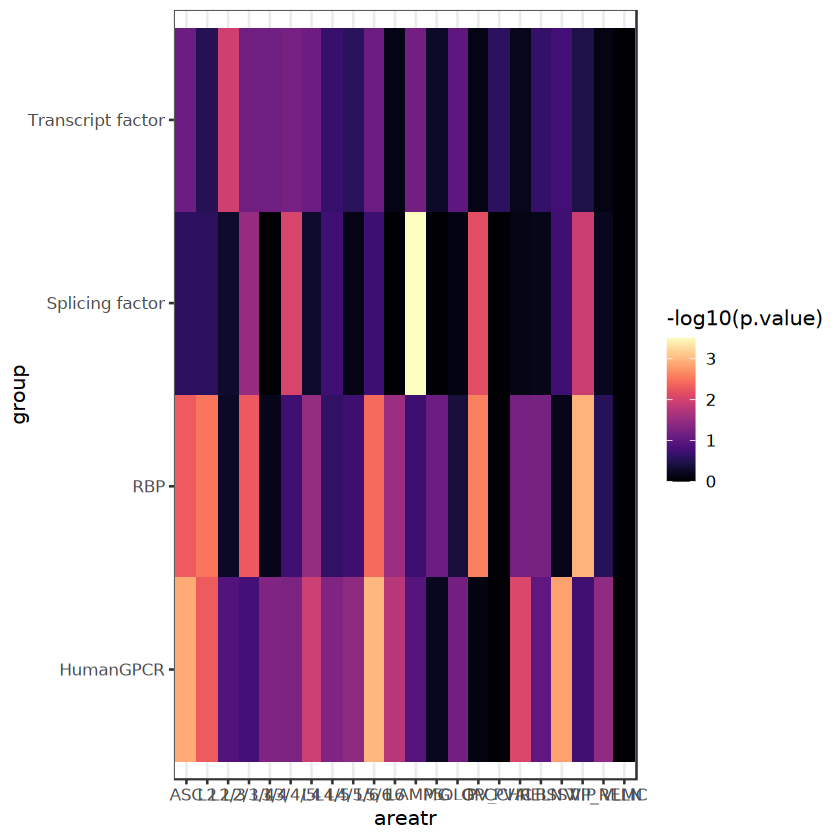

In [254]:
# 例子数据
isosigi = isosigls$subclass
isosigi = isosigi[isosigi$sig != "N",]
areatrs = unique(isosigi$areatr)

FishEnrich = function(geneset,funcset,total_genen){
    drugovl = intersect(unique(funcset),geneset)
    geneset_size <- length(geneset)    # 感兴趣的基因集大小
    functional_category_size <- length(unique(funcset))  # 特定功能类别中的基因总数
    both <- length(drugovl)  # 两个集合都包含的基因数量
    total_genes <- 20000  # 整个基因组中的基因总数

    contingency_table <- matrix(c(both, geneset_size - both, 
                              functional_category_size - both, 
                              total_genes - (geneset_size + functional_category_size - both)), 
                            nrow = 2)

    # 进行Fisher精确检验
    fisher_test_result <- fisher.test(contingency_table)
    # 输出p值
    p_value <- fisher_test_result$p.value

    # 计算富集分数（Enrichment Ratio），这通常是感兴趣的基因集中具有特定功能的基因比例与整个基因组中该功能基因比例的比值
    enrichment_ratio <- (both / geneset_size) / (functional_category_size / total_genes)
    res = data.frame("p.value" = p_value,"enrichscore" = enrichment_ratio)
    return(res)
}

goana = NULL
for(i in 1:length(areatrs)){
    isosigii = isosigi[isosigi$areatr == areatrs[i],]
    hubgene = unique(isosigii$gene_id)
    res.rbp = FishEnrich(hubgene,rbpgene,20000)
    res.rbp$group = "RBP"
    res.spf = FishEnrich(hubgene,spgene,20000)
    res.spf$group = "Splicing factor"
    res.tf = FishEnrich(hubgene,tfgene,20000)
    res.tf$group = "Transcript factor"
    res.hp = FishEnrich(hubgene,unlist(all_sheets[,1]),20000)
    res.hp$group = "HumanGPCR"
    goanai = rbind(res.rbp,res.spf,res.tf,res.hp)
    goanai$areatr = areatrs[i]
    goana = rbind(goana,goanai)
}
ph = ggplot(goana,aes(x = areatr,y = group, fill = -log10(p.value),size = enrichment_ratio)) + geom_point() + theme_bw() + 
scale_fill_viridis(option = "A")
ph


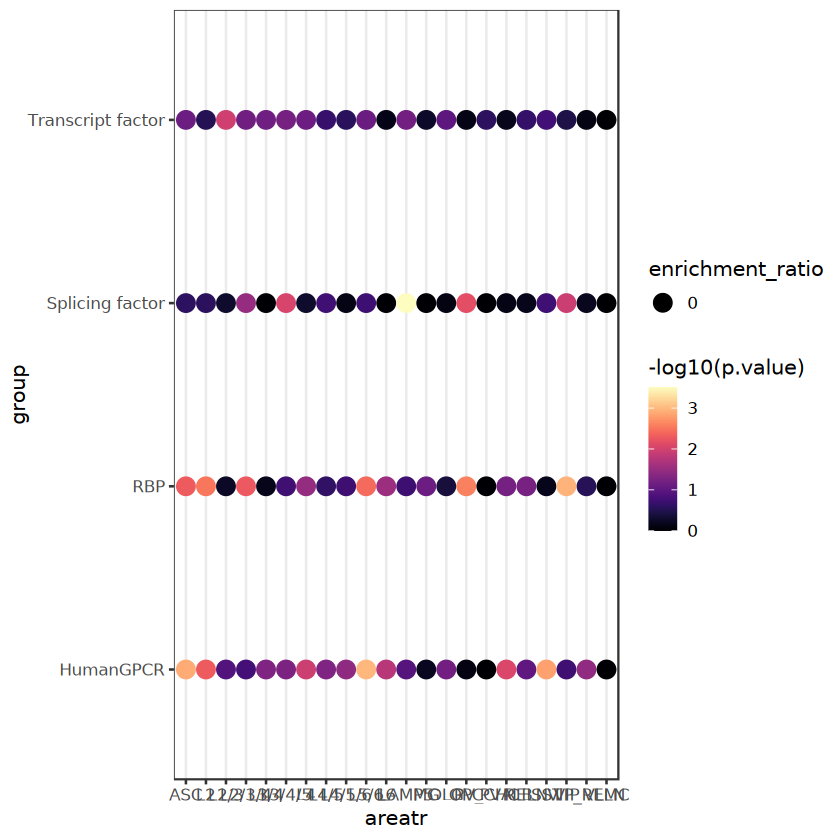

In [257]:
ph = ggplot(goana,aes(x = areatr,y = group, color = -log10(p.value),size = enrichment_ratio)) + geom_point() + theme_bw() + 
scale_color_viridis(option = "A") + coord_fixed()
ph

In [ ]:
ggexport(ph,filename = "result/figure4/subclass_dtu_enrich_analysis_24_09_17.pdf",width = 8,height = 4)

## Analysis Spatial and Cell interact

### DTU of layer/lobe/cell overlap

In [7]:
#
isosigl = isosigls$layer
huntrans1 = unique(isosigl[isosigl$sig != "N",]$transcript_id)
isosigc = isosigls$subclass
huntrans2 = unique(isosigc[isosigc$sig != "N",]$transcript_id)
huntrans = c(huntrans1,huntrans2)
print(length(unique(huntrans)))

isosigl = isosigl[isosigl$transcript_id %in% huntrans,]
isosigl$drl = isosigl$relative - isosigl$meanrelative
isosigl = unique(isosigl[,c("transcript_id","areatr","drl")])
colnames(isosigl)[2] = "layer"

isosigc$drc = isosigc$relative - isosigc$meanrelative
isosigc = isosigc[,c("transcript_id","areatr","drc")]
colnames(isosigc)[2] = "subclass"
isosigc = merge(isosigc,isosigl,by = "transcript_id")
isosigc.st = isosigc %>% group_by(layer,subclass) %>% summarise(cor = cor(drl,drc))
head(isosigc.st)

[1] 2611


`summarise()` has grouped output by 'layer'. You can override using the
`.groups` argument.


layer subclass cor        
1 l1    ASC       0.41428918
2 l1    L2       -0.03414151
3 l1    L2/3     -0.21047148
4 l1    L2/3/4    0.04273920
5 l1    L3/4     -0.21855451
6 l1    L3/4/5   -0.17349189

In [8]:
cellprop.layer = fsraw.cor[fsraw.cor$class != "",] %>% group_by(layer,class,subclass) %>% summarise(cellnum = length(unique(cell_id)))
cellprop.layer = cellprop.layer %>% group_by(layer) %>% mutate(cellprop = cellnum/sum(cellnum))
isosigc.st = merge(isosigc.st,cellprop.layer,by = c("layer","subclass"))

`summarise()` has grouped output by 'layer', 'class'. You can override using
the `.groups` argument.


Ignoring unknown labels:
• fill : "Correlation of Delta Isoform ratio"
Ignoring unknown labels:
• fill : "Correlation of Delta Isoform ratio"
file saved to result/figure4/layer_subclass_dtu_correlation_25_12_03.pdf



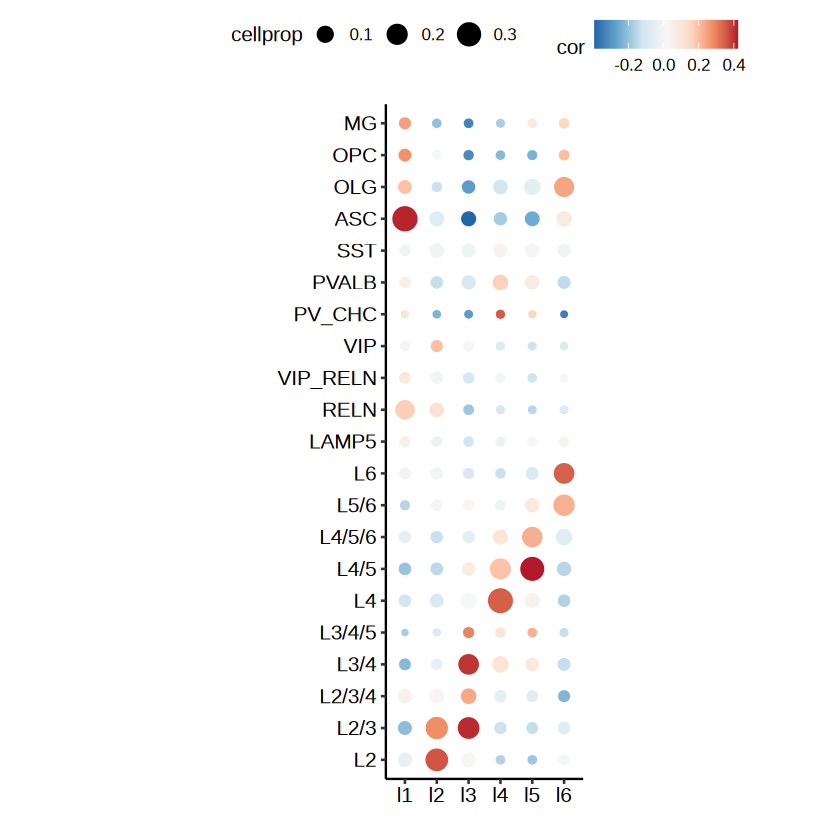

In [11]:
isosigc.st$subclass = factor(isosigc.st$subclass,levels = suborder)
p = ggplot(isosigc.st[as.character(isosigc.st$subclass) != "VLMC",],aes(x = layer,y = subclass,color = cor,size = cellprop)) + geom_point() +
theme_pubr() + scale_color_distiller(palette = "RdBu") + coord_fixed() + xlab("") + ylab("") + labs(fill = "Correlation of Delta Isoform ratio")
p
ggexport(p,filename = "result/figure4/layer_subclass_dtu_correlation_25_12_03.pdf",width = 5,height = 5)

[1] 2463


`summarise()` has grouped output by 'lobe'. You can override using the
`.groups` argument.


layer subclass cor         class     cellnum cellprop    
1 l1    ASC       0.41428918 NonNeuron 5203    0.3360025831
2 l1    L2       -0.03414151 GLU        788    0.0508879561
3 l1    L2/3     -0.21047148 GLU        708    0.0457216661
4 l1    L2/3/4    0.04273920 GLU        802    0.0517920568
5 l1    L3/4     -0.21855451 GLU        321    0.0207297385
6 l1    L3/4/5   -0.17349189 GLU         14    0.0009041007

`summarise()` has grouped output by 'lobe', 'class'. You can override using the
`.groups` argument.
Ignoring unknown labels:
• fill : "Correlation of Delta Isoform ratio"


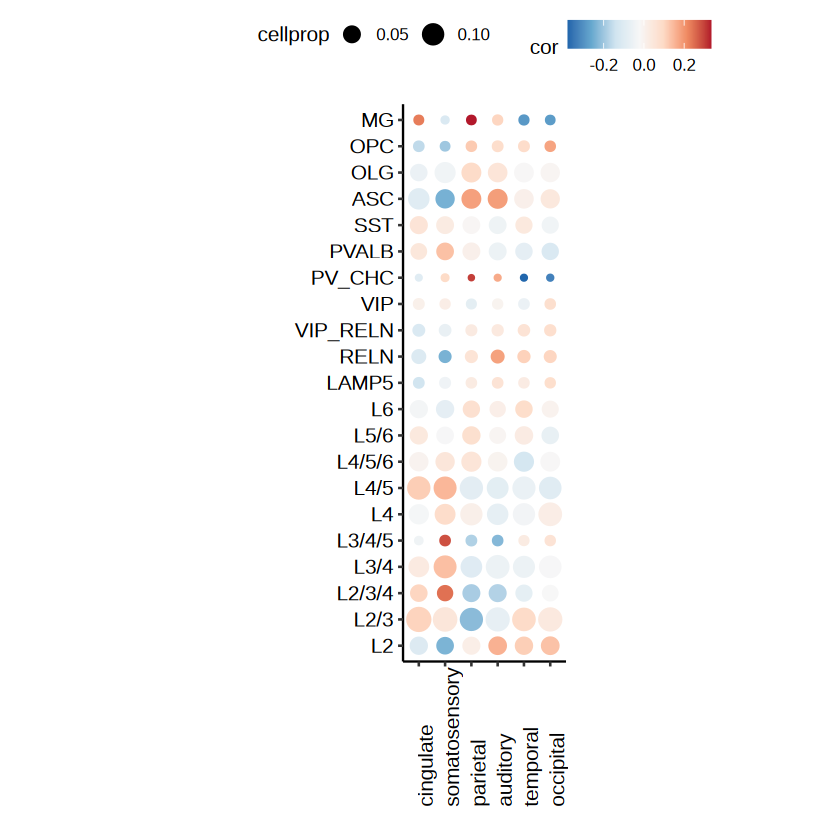

In [12]:
#
isosigl = isosigls$lobe
huntrans1 = unique(isosigl[isosigl$sig != "N",]$transcript_id)
isosigc = isosigls$subclass
huntrans2 = unique(isosigc[isosigc$sig != "N",]$transcript_id)
huntrans = c(huntrans1,huntrans2)
print(length(unique(huntrans)))

isosigl = isosigl[isosigl$transcript_id %in% huntrans,]
isosigl$drl = isosigl$relative - isosigl$meanrelative
isosigl = unique(isosigl[,c("transcript_id","areatr","drl")])
colnames(isosigl)[2] = "lobe"

isosigc$drc = isosigc$relative - isosigc$meanrelative
isosigc = isosigc[,c("transcript_id","areatr","drc")]
colnames(isosigc)[2] = "subclass"
isosigc = merge(isosigc,isosigl,by = "transcript_id")
isosigc.st2 = isosigc %>% group_by(lobe,subclass) %>% summarise(cor = cor(drl,drc))
head(isosigc.st)
cellprop.lobe = fsraw.cor[fsraw.cor$class != "",] %>% group_by(lobe,class,subclass) %>% summarise(cellnum = length(unique(cell_id)))
cellprop.lobe = cellprop.lobe %>% group_by(lobe) %>% mutate(cellprop = cellnum/sum(cellnum))
isosigc.st2 = merge(isosigc.st2,cellprop.lobe,by = c("lobe","subclass"))
isosigc.st2$subclass = factor(isosigc.st2$subclass,levels = suborder)
isosigc.st2$lobe = factor(isosigc.st2$lobe,levels = lobeorder)
p = ggplot(isosigc.st2[as.character(isosigc.st2$subclass) != "VLMC",],aes(x = lobe,y = subclass,color = cor,size = cellprop)) + geom_point() +
theme_pubr() + scale_color_distiller(palette = "RdBu") + coord_fixed() + xlab("") + ylab("") + 
labs(fill = "Correlation of Delta Isoform ratio") + theme(axis.text.x = element_text(angle = 90,hjust = 0))
p

In [13]:
ggexport(p,filename = "result/figure4/lobe_subclass_dtu_correlation_25_12_03.pdf",width = 6.5,height = 6.5)

Ignoring unknown labels:
• fill : "Correlation of Delta Isoform ratio"
file saved to result/figure4/lobe_subclass_dtu_correlation_25_12_03.pdf



[1] 3622


`summarise()` has grouped output by 'region'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'region', 'class'. You can override using
the `.groups` argument.
Ignoring unknown labels:
• fill : "Correlation of Delta Isoform ratio"


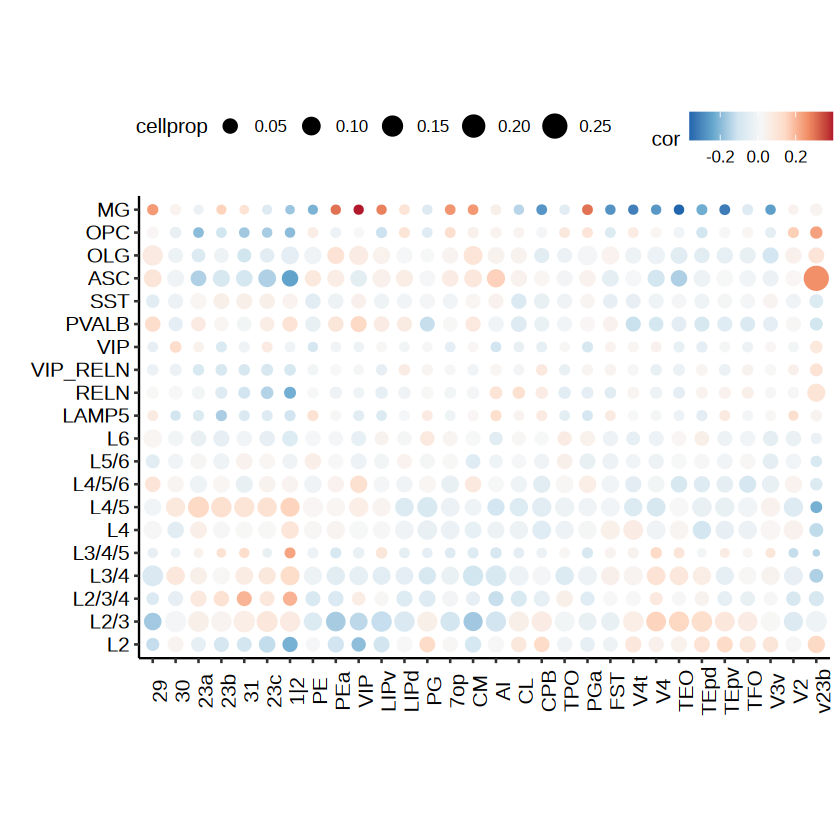

In [16]:
#
isosigl = isosigls$region
huntrans1 = unique(isosigl[isosigl$sig != "N",]$transcript_id)
isosigc = isosigls$subclass
huntrans2 = unique(isosigc[isosigc$sig != "N",]$transcript_id)
huntrans = c(huntrans1,huntrans2)
print(length(unique(huntrans)))

isosigl = isosigl[isosigl$transcript_id %in% huntrans,]
isosigl$drl = isosigl$relative - isosigl$meanrelative
isosigl = unique(isosigl[,c("transcript_id","areatr","drl")])
colnames(isosigl)[2] = "region"

isosigc$drc = isosigc$relative - isosigc$meanrelative
isosigc = isosigc[,c("transcript_id","areatr","drc")]
colnames(isosigc)[2] = "subclass"
isosigc = merge(isosigc,isosigl,by = "transcript_id")
isosigc.st2 = isosigc %>% group_by(region,subclass) %>% filter(length(unique(transcript_id)) > 100) %>% summarise(cor = cor(drl,drc))

cellprop.lobe = fsraw.cor[fsraw.cor$class != "",] %>% group_by(region,class,subclass) %>% 
summarise(cellnum = length(unique(cell_id)))
cellprop.lobe = cellprop.lobe %>% group_by(region) %>% mutate(cellprop = cellnum/sum(cellnum))
isosigc.st2 = merge(isosigc.st2,cellprop.lobe,by = c("region","subclass"))
isosigc.st2$subclass = factor(isosigc.st2$subclass,levels = suborder)
isosigc.st2$region = factor(isosigc.st2$region,levels = regionorder)

p = ggplot(isosigc.st2[as.character(isosigc.st2$subclass) != "VLMC",],aes(x = region,y = subclass,color = cor,size = cellprop)) + 
    geom_point() +
    theme_pubr() + scale_color_distiller(palette = "RdBu") + coord_fixed() + xlab("") + ylab("") + 
    labs(fill = "Correlation of Delta Isoform ratio") + theme(axis.text.x = element_text(angle = 90))

p

In [17]:
ggexport(p,filename = "result/figure4/region_subclass_dtu_correlation_25_12_03.pdf",width = 7,height = 7)

Ignoring unknown labels:
• fill : "Correlation of Delta Isoform ratio"
file saved to result/figure4/region_subclass_dtu_correlation_25_12_03.pdf



file saved to result/figure4/region_subclass_dtu_correlation_cellprop_cmpare_25_12_03.pdf



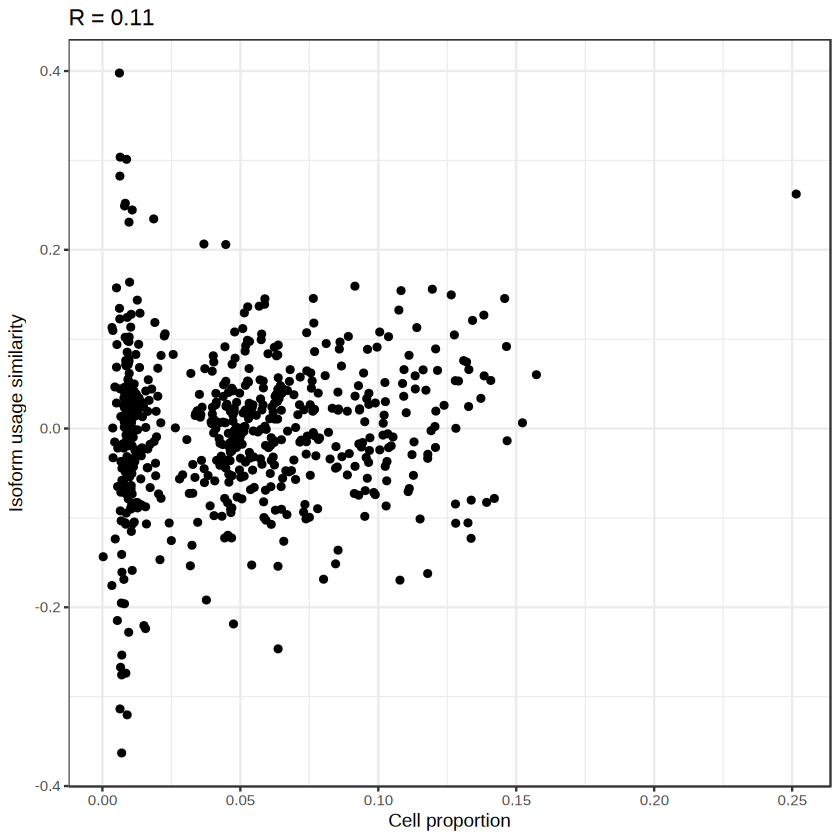

In [19]:
# cor(isosigc.st$cor,isosigc.st$cellprop)
library(ggrepel)
# ggplot(isosigc.st,aes(x = cellprop, y = cor)) + geom_point()
cortext = round(cor(isosigc.st2$cor,isosigc.st2$cellprop),3)
isosigc.st2$highlight = "N"
isosigc.st2$group = paste0(as.character(isosigc.st2$region),"-",as.character(isosigc.st2$subclass))
isosigc.st2[isosigc.st2$subclass %in% c("L3/4"),]$highlight = "Y"

p1.1 = ggplot(isosigc.st2,aes(x = cellprop, y = cor)) + geom_point() + 
    # geom_text_repel(data = isosigc.st2[isosigc.st2$highlight == "Y",],aes(label = group)) +
     theme_bw() + ggtitle(paste0("R = ",cortext)) + xlab("Cell proportion")  + 
     ylab("Isoform usage similarity") + scale_color_manual(values = c("black","red")) + theme(legend.position = "none")
p1.1
ggexport(p1.1,filename = "result/figure4/region_subclass_dtu_correlation_cellprop_cmpare_25_12_03.pdf",width =  4,height = 4)

In [ ]:
#sd(isosigc.st2[isosigc.st2$subclass %in% c("L3/4"),]$cellprop)
mean(isosigc.st2[isosigc.st2$subclass %in% c("L3/4") & isosigc.st2$region %in% c("23a","23b","23c","31","1|2"),]$cellprop)
mean(isosigc.st2[isosigc.st2$subclass %in% c("L3/4") & !isosigc.st2$region %in% c("23a","23b","23c","31","1|2"),]$cellprop)
mean(isosigc.st2[isosigc.st2$subclass %in% c("L3/4") & isosigc.st2$region %in% c("23a","23b","23c","31","1|2"),]$cor)
mean(isosigc.st2[isosigc.st2$subclass %in% c("L3/4") & !isosigc.st2$region %in% c("23a","23b","23c","31","1|2"),]$cor)

file saved to result/figure4/layer_subclass_dtu_correlation_cellprop_cmpare_25_12_03.pdf



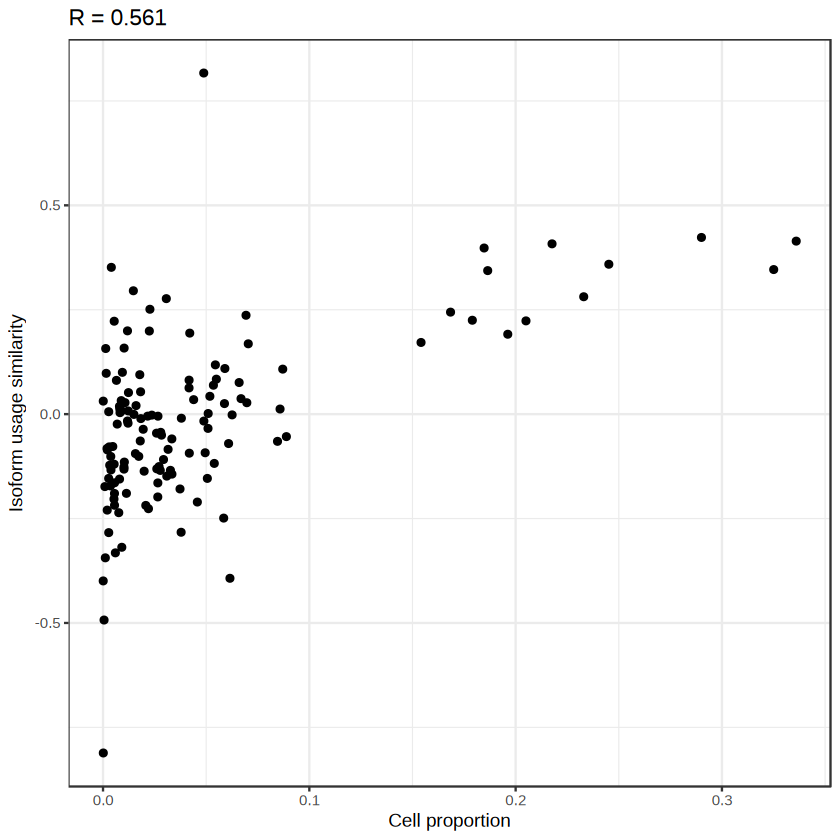

In [21]:
# cor(isosigc.st$cor,isosigc.st$cellprop)
# ggplot(isosigc.st,aes(x = cellprop, y = cor)) + geom_point()
cortext = round(cor(isosigc.st$cor,isosigc.st$cellprop),3)
isosigc.st$highlight = "N"
isosigc.st$group = paste0(as.character(isosigc.st$layer),"-",as.character(isosigc.st$subclass))
isosigc.st[isosigc.st$group %in% c("l1-ASC",
                                   "l1-RELN","l2-L2","l2-L2/3","l3-L2/3",
                                    "l3-L3/4","l4-L4","l4-L4/5","l5-L4/5","l5-L4/5/6",
                                     "l6-L5/6","l6-L6","l6-OLG"),]$highlight = "Y"
p1.1 = ggplot(isosigc.st,aes(x = cellprop, y = cor)) + geom_point() + 
     # geom_text_repel(data = isosigc.st[isosigc.st$highlight == "Y",],aes(label = group)) +
     theme_bw() + ggtitle(paste0("R = ",cortext)) + xlab("Cell proportion")  + 
     ylab("Isoform usage similarity") + scale_color_manual(values = c("black","red")) + theme(legend.position = "none")
p1.1
ggexport(p1.1,filename = "result/figure4/layer_subclass_dtu_correlation_cellprop_cmpare_25_12_03.pdf",width =  4,height = 4)

file saved to result/figure4/cellprop_stat_24_11_10.pdf



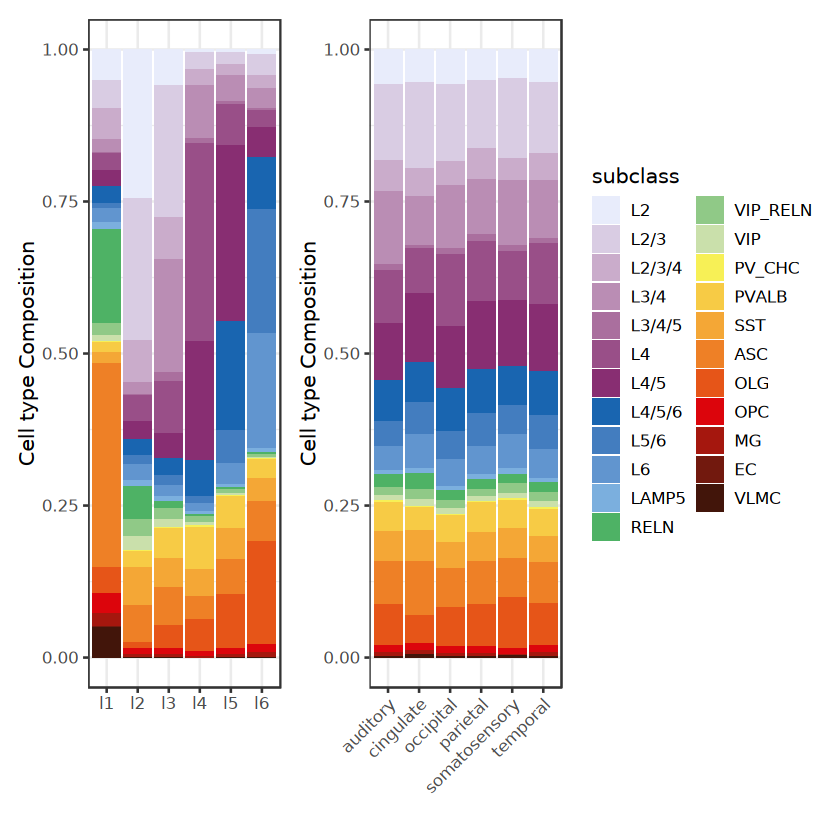

In [159]:
cellprop.layer$subclass = factor(cellprop.layer$subclass,levels = suborder)
cellprop.lobe$subclass = factor(cellprop.lobe$subclass,levels = suborder)
pst1 = ggplot(cellprop.layer,aes(x = layer,y = cellprop,fill = subclass)) + geom_bar(stat = "identity") + scale_fill_discreterainbow() + theme_bw() +
xlab("") + ylab("Cell type Composition") + NoLegend()
pst2 = ggplot(cellprop.lobe,aes(x = lobe,y = cellprop,fill = subclass)) + geom_bar(stat = "identity") + scale_fill_discreterainbow() + theme_bw() +
xlab("") + ylab("Cell type Composition") + theme(axis.text.x = element_text(angle = 45,hjust = 1))
pst = pst1 + pst2
pst
ggexport(pst,filename = "result/figure4/cellprop_stat_24_11_10.pdf",width = 7,height = 4)

### Calculate region/layer/subclass contribution 

In [23]:
library(qs)
library(dplyr)
library(lme4)

Warning message:
"package 'lme4' was built under R version 4.3.3"
Loading required package: Matrix

Warning message:
"package 'Matrix' was built under R version 4.3.2"

Attaching package: 'Matrix'


The following object is masked from 'package:S4Vectors':

    expand




In [ ]:
transt_inner = fsraw.cor[fsraw.cor$subclass != "",] %>% group_by(lobe,layer,subclass,gene_id,transcript_id) %>% 
                summarise(count = length(readid)) %>% 
                group_by(lobe,layer,subclass,gene_id) %>% 
                mutate(genecount = sum(count),relative = count/genecount)
transt_inner = transt_inner %>% group_by(subclass,transcript_id) %>% 
              mutate(meanrelative = mean(relative))

transt_inner.lobe = fsraw.cor[fsraw.cor$subclass != "",] %>% group_by(lobe,subclass,gene_id,transcript_id) %>% 
                summarise(count = length(readid)) %>% 
                group_by(lobe,subclass,gene_id) %>% 
                mutate(genecount = sum(count),relative = count/genecount)
transt_inner.lobe = transt_inner.lobe %>% group_by(subclass,transcript_id) %>% 
              mutate(meanrelative = mean(relative))


transt_inner.layer = fsraw.cor[fsraw.cor$subclass != "",] %>% group_by(layer,subclass,gene_id,transcript_id) %>% 
                summarise(count = length(readid)) %>% 
                group_by(layer,subclass,gene_id) %>% 
                mutate(genecount = sum(count),relative = count/genecount)
transt_inner.layer = transt_inner.layer %>% group_by(subclass,transcript_id) %>% 
              mutate(meanrelative = mean(relative))
transt_innerls = list("inner" = transt_inner,"lobe" = transt_inner.lobe,"layer" = transt_inner.layer)
qsave(list("inner" = transt_inner,"lobe" = transt_inner.lobe,"layer" = transt_inner.layer),
      "data/dtu_analysis/region_subclass_isoform_ratio_stat_251203.qs")

#transtf = transtf[transtf$tcount > 1000,]
transt = fsraw.cor %>% group_by(gene_id,transcript_id,subclass,lobe,region) %>% 
          summarise(count = length(readid)) %>% group_by(gene_id,subclass,lobe,region) %>% 
          mutate(genecount = sum(count),relative = count/genecount)
transt = transt %>% group_by(lobe) %>% mutate(tcount = sum(count))
transtf = transt %>% group_by(gene_id) %>% filter(length(unique(transcript_id)) > 1 )
#transtf = transtf[transtf$count > 5,]
#transtf = transtf[paste0(transtf$subclass,transtf$layer) %in% paste0(substf$subclass,substf$layer),]
transtf = transtf %>% group_by(gene_id,transcript_id,subclass) %>% mutate(cellm = sum(count)/sum(genecount))
transtf = transtf %>% group_by(gene_id,transcript_id,lobe) %>% mutate(lobem = sum(count)/sum(genecount))
transtf = transtf %>% group_by(gene_id,transcript_id,region) %>% mutate(regionm = sum(count)/sum(genecount))
transtf = transtf[transtf$genecount > 10,]
transtf = transtf %>% group_by(transcript_id,subclass) %>% filter(length(unique(lobe)) == 6)
transtf = transtf %>% group_by(transcript_id) %>% filter(length(unique(subclass)) > 6)
transt.lobei = transtf[transtf$subclass != "",]
length(unique(transtf$gene_id))



In [28]:
model_with_region = glmer(relative ~  cellm + regionm + (1|count),
                            family = binomial(),
                            data = transt.lobei[transt.lobei$gene_id == "RTN1",],
                            na.action = na.exclude)
summary(model_with_region)

Warning message in eval(family$initialize, rho):
"non-integer #successes in a binomial glm!"
boundary (singular) fit: see help('isSingular')



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: relative ~ cellm + regionm + (1 | count)
   Data: transt.lobei[transt.lobei$gene_id == "RTN1", ]

     AIC      BIC   logLik deviance df.resid 
    90.7    109.6    -41.4     82.7      830 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.2636 -2.5415  0.1729  3.9234 11.0597 

Random effects:
 Groups Name        Variance Std.Dev.
 count  (Intercept) 0        0       
Number of obs: 834, groups:  count, 165

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -10.944      1.132  -9.665   <2e-16 ***
cellm          2.186      8.307   0.263   0.7924    
regionm       18.849      8.112   2.323   0.0202 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
        (Intr) cellm 
cellm   -0.194       
regionm -0.016 -0.975
optimizer (Nelder_Mead) convergence code: 0 (OK)
bo

In [29]:
modelcoef2 = NULL
length(unique(transt.lobei$gene_id))
for(i in unique(transt.lobei$gene_id)){
    model_with_region = tryCatch(glmer(relative ~  cellm + regionm + (1|count),
                            family = binomial(),
                            data = transt.lobei[transt.lobei$gene_id == i,],
                            na.action = na.exclude), 
                   error = function(e) NA)

    if(!is.na(model_with_region)){
        modelsm = tryCatch(summary(model_with_region),error = function(e) NA)
        if(length(modelsm) == 1) next;
        modelsmdf = as.data.frame(modelsm$coefficients)
        modelsmdf$gene_id = i
        # gi = transt.lobei[transt.lobei$transcript_id == i,]$gene_id[1]
        # modelsmdf$gene_id = gi
        modelsmdf$areatr = rownames(modelsmdf)
        modelcoef2 = rbind(modelcoef2,modelsmdf)
    }    
    
   # print(summary(model_with_region))
}
                           
modelcoef2[modelcoef2$gene_id == "RTN1",]
colnames(modelcoef2)[4] = "pvalue"
length(unique(modelcoef2$gene_id))
length(unique(modelcoef2[modelcoef2$pvalue < 0.05 & (modelcoef2$areatr %in% c("lobem")),]$gene_id))
length(unique(modelcoef2[modelcoef2$pvalue < 0.05 & (modelcoef2$areatr %in% c("regionm")),]$gene_id))
length(unique(modelcoef2[modelcoef2$pvalue < 0.05 & (modelcoef2$areatr %in% c("cellm")),]$gene_id))

hubb = unique(modelcoef2[modelcoef2$pvalue < 0.05 & (modelcoef2$areatr %in% c("regionm")),]$gene_id)
hubc = unique(modelcoef2[modelcoef2$pvalue < 0.05 & (modelcoef2$areatr %in% c("cellm")),]$gene_id)

length(intersect(hubc,hubb))
qsave(modelcoef2,"data/dtu_analysis/region_subclass_isoform_model_tri_onlyregion_25_12_03.qs")

[1] 372

Warning message in eval(family$initialize, rho):
"non-integer #successes in a binomial glm!"
boundary (singular) fit: see help('isSingular')

Warning message in is.na(model_with_region):
"is.na() applied to non-(list or vector) of type 'S4'"
Warning message in vcov.merMod(object, use.hessian = use.hessian):
"variance-covariance matrix computed from finite-difference Hessian is
not positive definite or contains NA values: falling back to var-cov estimated from RX"
Warning message in vcov.merMod(object, correlation = correlation, sigm = sig):
"variance-covariance matrix computed from finite-difference Hessian is
not positive definite or contains NA values: falling back to var-cov estimated from RX"
Warning message in eval(family$initialize, rho):
"non-integer #successes in a binomial glm!"
boundary (singular) fit: see help('isSingular')

Warning message in is.na(model_with_region):
"is.na() applied to non-(list or vector) of type 'S4'"
Warning message in vcov.merMod(object, use.hessian =

Estimate   Std. Error z value    Pr(>|z|)     gene_id
(Intercept)269 -10.943947 1.132282   -9.6653890 4.230098e-22 RTN1   
cellm269         2.186325 8.306524    0.2632058 7.923920e-01 RTN1   
regionm269      18.848613 8.112464    2.3234140 2.015692e-02 RTN1   
               areatr     
(Intercept)269 (Intercept)
cellm269       cellm      
regionm269     regionm

[1] 354

[1] 0

[1] 61

[1] 57

[1] 29

In [ ]:
#modelcoef2 = qread("data/dtu_analysis/region_subclass_isoform_model_tri_241015.qs")
# modelcoef2 = qread("data/dtu_analysis/region_subclass_isoform_model_tri_onlyregion_24_12_20.qs")
modelcoef2$group = modelcoef2$areatr
modelcoef2[modelcoef2$areatr == "cellm",]$group = "cell"
#modelcoef2[modelcoef2$areatr == "lobem",]$group = "lobe"
#modelcoef2[modelcoef2$areatr == "layerm",]$group = "layer"
modelcoef2[modelcoef2$areatr == "regionm",]$group = "region"
head(modelcoef2)
colnames(modelcoef2)[4] = "pvalue"
modelcoef.hub = modelcoef2[modelcoef2$group %in% c("cell","region"),]
length(unique(modelcoef.hub$gene_id))
modelcoef.hub$pvalue = -log10(modelcoef.hub$pvalue)
modelmx1 = dcast(modelcoef.hub,gene_id~group,value.var = "pvalue",fun.aggregate = sum)
modelmx1.hub = modelmx1
modelmx1.hub$sig <- sapply(1:nrow(modelmx1.hub), function(i) {
  significant_cols <- names(modelmx1.hub)[-1][modelmx1.hub[i, -1] > -log10(0.05)]
  paste(significant_cols, collapse = "-")
})

Estimate   Std. Error z value       pvalue gene_id areatr     
(Intercept)  -59.727097 2366015078 -2.524375e-08 1      ABI2    (Intercept)
cellm         53.450647 1992326184  2.682826e-08 1      ABI2    cellm      
regionm       53.214197 1100514613  4.835392e-08 1      ABI2    regionm    
(Intercept)1  -5.806286  771268832 -7.528226e-09 1      ADD1    (Intercept)
cellm1        30.355730  567226468  5.351607e-08 1      ADD1    cellm      
regionm1      21.291255  548798317  3.879614e-08 1      ADD1    regionm    
             group      
(Intercept)  (Intercept)
cellm        cell       
regionm      region     
(Intercept)1 (Intercept)
cellm1       cell       
regionm1     region

In [131]:
thred = -log10(0.05)
isosigi = isosigls$region
isosigi2 = isosigi[isosigi$sig != "N",]
isosigtri = modelmx1.hub[order(modelmx1.hub$sig),]
isosigtri = isosigtri[isosigtri$cell < 100,]
isosigtri = isosigtri[isosigtri$sig != "",]
isosigtri = isosigtri[isosigtri$region > thred | isosigtri$gene_id %in% isosigi2$gene_id,]
isosigtri[isosigtri$cell > thred,]$sig = "cell"
isosigtri[isosigtri$region > thred,]$sig = "region"
isosigtri[isosigtri$region > thred & isosigtri$cell > thred,]$sig = "cell-region"
isosigtri$group = "N"
isosigtri[isosigtri$gene_id %in% isosigi2$gene_id,]$group = "Y"
length(unique(isosigtri$gene_id))
thred = log2(-log10(0.05))
casels = c("NTRK2","DBNDD2","DDRGK1","ARPP19","RTN1","MORF4L1","SNRPN")
p2 = ggplot(data = isosigtri,aes(x = log2(cell), y = log2(region), color = group)) + 
#geom_pointdensity() +
   geom_point(size = 0.5) + 
   geom_text_repel(data=isosigtri[isosigtri$gene_id %in% casels,], nudge_y = .2,min.segment.length = unit(0, 'lines'),
             aes(x = log2(cell), y = log2(region),label = gene_id),size = 3,color = "black",vjust = 0.1)+
   geom_hline(yintercept = thred,linetype = 3) +
   geom_vline(xintercept = thred,linetype = 3) +
    scale_x_continuous(limits = c(-5,5),breaks = c(log2(-log10(0.99)),log2(-log10(0.9)),
                                log2(-log10(0.05)),log2(-log10(0.01)),3,5),
                     labels = c("0.99","0.9","0.05","0.01","10-e8","10-e32")) +
     scale_y_continuous(limits = c(-5,5),breaks = c(log2(-log10(0.99)),log2(-log10(0.9)),
                                log2(-log10(0.05)),log2(-log10(0.01)),3,5),
                     labels = c("0.99","0.9","0.05","0.01","10-e8","10-e32")) +
   # geom_text_repel(data=isosigtri[!isosigtri$sig %in% c("","cell"),],
   #                 aes(cell,lobe,layer,label = gene_id),size = 2,color = "black") +
    theme_bw() + 
    theme(panel.grid.major = element_blank(),panel.grid.minor = element_blank(),
          axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1)) +
    xlab("Contribution p value of subclass") + 
    ylab("Contribution p value of cortex region") +
#scale_fill_viridis()
    scale_color_discreterainbow()
p2
table(isosigtri$group)
table(isosigtri$sig)
ggexport(p2,filename = "result/figure5/region_subclass_model_contribution_25_12_04.pdf",width = 4,height = 3)
pdf("result/figure5/region_subclass_model_contribution_stpie_24_12_20.pdf",width = 4,height = 4)
p2.1 = pie(table(isosigtri$sig),col = c("#789DBC","#FFE3E3","#C9E9D2"))
p2.1
dev.off()


[1] 107

Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`)."



 N  Y 
40 67 


       cell cell-region      region 
         14          47          46 

Warning message in grid.newpage():
"Cannot open temporary file '/tmp/Rtmp0wpa3l/pdfb39760476ba6' for compression (reason: No such file or directory); compression has been turned off for this device"
Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`)."
file saved to result/figure5/region_subclass_model_contribution_25_03_20.pdf

Warning message in plot.new():
"Cannot open temporary file '/tmp/Rtmp0wpa3l/pdfb3976963d97e' for compression (reason: No such file or directory); compression has been turned off for this device"


NULL

png 
  2

ERROR: Error in file(con, "rb"): cannot open the connection


plot without title


Attaching package: 'stringr'


The following object is masked from 'package:ggbio':

    fixed


file saved to result/figure5/lobedtu_layer_subclass_lobe_dtu_model_tern_stat_bar_24_11_09.pdf



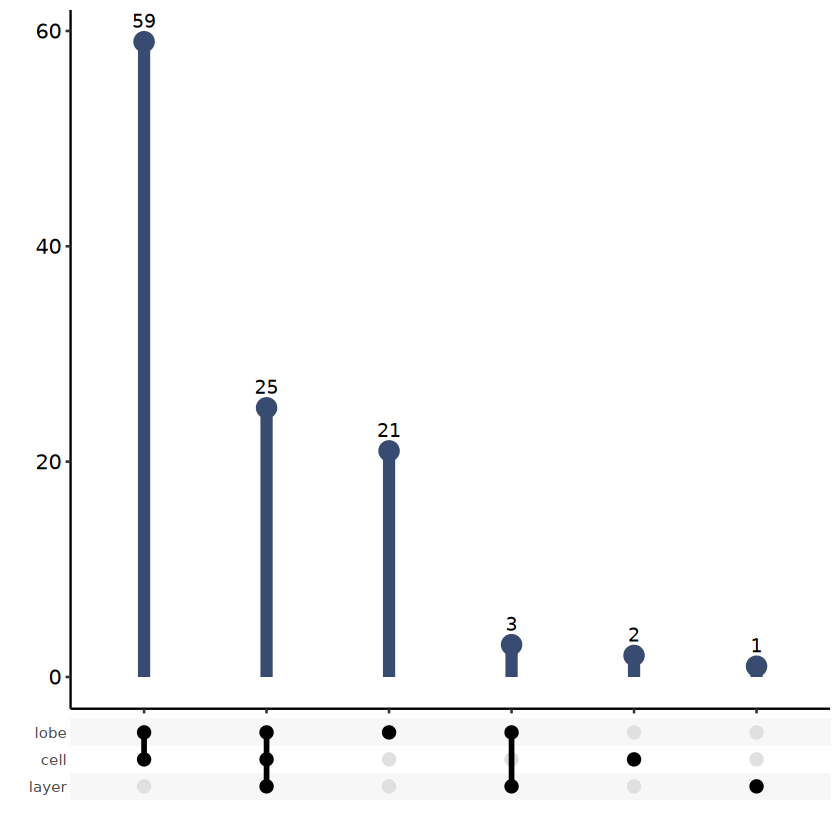

In [52]:
library(stringr)
isosigtrif = isosigtri[isosigtri$sig != "",]
#isosigtri.st = as.data.frame(table(isosigtri.st$sig))
dtustdf = NULL
for(i in 1:nrow(isosigtrif)){
    groupi =  unlist(str_split(isosigtrif$sig[i],"-"))
    dtustdfi = data.frame("group" = groupi,
                          "gene_id" = isosigtrif$gene_id[i])
    dtustdf = rbind(dtustdf,dtustdfi)
}

library(ggupset)
#dtustdfup = dtustdfup[,c("txid","type","group")]
#dtustdfup2 = dtustdfup[dtustdfup$group %in% c("Within GLU","Within GABA", "Within NN", "Among all"),] %>%
dtustdf = dtustdf %>%
  group_by(gene_id) %>%
  summarize(group = list(group))
pisonup1 = ggplot(data = dtustdf,aes(x = group))+ 
    scale_x_upset() + 
    geom_point(stat = "count",position = position_dodge(0.5),size = 5,color = "#384B70") + 
    geom_bar(position = position_dodge(0.5),width = 0.1,fill = "#384B70") +
    geom_text(stat = "count",aes(label=after_stat(count)),position = position_dodge(0.5),vjust = -1) + 
    xlab("") + ylab("") +
    #scale_fill_flatui() +
    #scale_color_flatui() +
    theme_pubr()
pisonup1
ggexport(pisonup1,filename = "result/figure5/lobedtu_layer_subclass_lobe_dtu_model_tern_stat_bar_24_11_09.pdf",width = 2,height = 4)
# ggplot(isosigtri.st,aes(x = Var1,y = Freq,fill = Var1,color = Var1)) + 
#     geom_point(shape = 21,size = 5) + 
#     geom_bar(stat = "identity",width = 0.1) +
#     geom_text(aes(label=Freq),vjust = -1) + 
#     scale_fill_flatui() +
#     scale_color_flatui() +
#     theme_pubr()


In [105]:
#try GO analysis
library(gprofiler2)
MyGOPlot = function(hubgenei,ni,mytitle,mycolor = NULL){
    goi = gost(query = hubgenei,
               organism = "mfascicularis")
#godfi = CalOddRate(goi$result,5)
    godfi = goi$result
    godfi$gene_ratio = godfi$intersection_size/godfi$term_size
#godfi = godfi[godfi$p_value < 0.05,]
    godfi = godfi[godfi$intersection_size > 2,] %>% group_by(source) %>% arrange(gene_ratio) %>% 
    top_n(wt = gene_ratio,n = ni)
    godfi$term_name = factor(godfi$term_name,levels = unique(godfi$term_name))
    print(nrow(godfi))

    if(is.null(mycolor)){
        mycolor = pal_flatui("default")(length(unique(godfi$source)))
    }
    godfi = godfi[!godfi$term_name %in% c("cell junction","cytoplasm","cytosol","cytoskeleton"),]
    if(nrow(godfi) > 0){
        pgi = ggplot(godfi,
               aes(x = gene_ratio, y=term_name,fill = source)) + 
        geom_point(aes(size = intersection_size),shape = 21) +
        geom_bar(stat = "identity",width = 0.03) +
        geom_text(aes(label = term_name,x = 0),hjust = -0.01,vjust = -0.5) +
        scale_fill_manual(values = mycolor) +
 #       scale_fill_viridis(direction = 1,option = "A") +
        #scale_fill_distiller(direction = 1,palette = "Greens") +
    # scale_y_discrete(labels = rev(unique(godftf$term_name))) +
    #facet_grid(source~.,scales = "free",space = "free") + 
        xlab("gene counts") +
        theme_pubr() + theme(legend.position = "top",axis.text.y = element_blank()) +
        ggtitle(mytitle)
    }
    return(pgi)
    
}

MyGOCal = function(hubgenei,ni){
    goi = gost(query = hubgenei,
               organism = "mfascicularis")
#godfi = CalOddRate(goi$result,5)
    godfi = goi$result
    godfi$gene_ratio = godfi$intersection_size/godfi$term_size
#godfi = godfi[godfi$p_value < 0.05,]
    godfi = godfi[godfi$intersection_size > 2,] %>% arrange(gene_ratio) %>% 
    top_n(wt = gene_ratio,n = ni)
    godfi$term_name = factor(godfi$term_name,levels = unique(godfi$term_name))
    print(nrow(godfi))

    godfi = godfi[!godfi$term_name %in% c("cell junction","cytoplasm","cytosol","cytoskeleton"),]

    return(godfi)
    
}


#ggexport(pgi,filename = "result/figure3/sigiso_class_transcript_dr_cluster_heatmap_NN_GO_24_04_21.pdf",width = 4,height = 8)


In [108]:
isosigtri[isosigtri$sig == "lobe",]$gene_id # SRSF5
isosigtri[isosigtri$sig == "layer",]$gene_id # SRSF5
isosigtri[isosigtri$sig == "cell",]$gene_id # SRSF5
isosigtri[isosigtri$sig == "cell-layer",]$gene_id
isosigtri[isosigtri$sig == "cell-lobe",]$gene_id
isosigtri[isosigtri$sig == "cell-layer-lobe",]$gene_id
isosigtri[isosigtri$sig == "layer-lobe",]$gene_id

[1] "AKAP9"   "APOD"    "BRD4"    "CAPRIN1" "CCK"     "CEND1"   "CIRBP"  
 [8] "DCXR"    "FAM213A" "GUK1"    "KALRN"   "MORF4L1" "PCMT1"   "PDRG1"  
[15] "PSIP1"   "RAB18"   "TM2D3"   "TMEM205" "TMEM59"  "UBE2K"   "UCHL1"

[1] "BRI3"        "C19H19orf70" "CCNI"        "MEF2C"       "MRPL27"     
 [6] "NRCAM"       "PARK7"       "PCDH7"       "PSMD4"       "SYT1"       
[11] "YWHAZ"       "ZNF428"

[1] "ACOT7"        "AK1"          "ARF5"         "ARGLU1"       "ARL6IP4"     
  [6] "ARPP21"       "ATP5G1"       "ATP5J"        "ATP6V0B"      "BNIP3L"      
 [11] "BUD31"        "CAMK2B"       "CAMLG"        "CAMTA1"       "CAPZB"       
 [16] "CCDC136"      "CD59"         "CDC37"        "CDC42"        "CFL1"        
 [21] "CLTC"         "CMC2"         "CNTNAP2"      "CRIP2"        "DCTN1"       
 [26] "DPCD"         "DYNLL1"       "EEF1B2"       "EIF2S2"       "ENSA"        
 [31] "EVL"          "FBXO9"        "FEZ1"         "FKBP1B"       "FKBP2"       
 [36] "FNDC4"        "FUOM"         "GNAO1"        "GOT1"         "GPM6B"       
 [41] "GPX4"         "GTF3A"        "HAGH"         "HCFC1R1"      "HDDC2"       
 [46] "HK1"          "HNRNPA3"      "HNRNPDL"      "HNRNPK"       "IDH3B"       
 [51] "IGSF8"        "KLC1"         "KRTCAP2"      "LOC101866646" "LOC102114836"
 [56] "LOC102118724" "LOC102122855" "LOC102133057" "LOC102141554" "LOC107126439"
 [61] "LOC107126444" "LOC107129555" "LOC107131073" "MAP1LC3B"     "MAP6"        
 [66] "MEA1"         "MOBP"         "MORF4L2"      "MRPS15"       "MRPS18B"     
 [71] "MRPS24"       "MYL6"         "MZT2B"        "NDUFB9"       "NDUFS4"      
 [76] "NOL7"         "NPDC1"        "NTRK2"        "OSBPL1A"      "PDZD11"      
 [81] "PFDN1"        "PIN1"         "PNISR"        "POLDIP2"      "POLR2E"      
 [86] "POP5"         "PPP1R12A"     "PSMD8"        "PTN"          "RAB3C"       
 [91] "RAD23A"       "RANBP1"       "RPL19"        "RPL38"        "RPP21"       
 [96] "RPS27"        "RWDD1"        "SEPT11"       "SLC25A3"      "SNF8"        
[101] "SNX3"         "SPTAN1"       "SRPK2"        "SRSF5"        "SSBP1"       
[106] "STMN4"        "STRBP"        "SUMO1"        "TCEB1"        "TMEM219"     
[111] "TRAPPC1"      "TTYH1"        "TUBB2B"       "TXNL4A"       "VDAC2"       
[116] "YWHAE"        "YWHAH"

[1] "CUTA"         "DBNDD2"       "EPHB6"        "HMOX2"        "LOC101925321"
 [6] "LOC102130589" "NGFRAP1"      "PPP1R7"       "SIK3"         "TUSC3"

[1] "ADGRB3"          "ADNP"            "ANKS1B"          "AP1S2"          
 [5] "ATP6V1C1"        "AURKAIP1"        "BambuGene103646" "BCLAF1"         
 [9] "C11H12orf10"     "CABP1"           "CADM2"           "CAPNS1"         
[13] "CCNH"            "CLTA"            "COPS5"           "CYHR1"          
[17] "EMC7"            "ENHO"            "FAM58A"          "GCC2"           
[21] "GRIA3"           "HERC1"           "HNRNPA2B1"       "KCNA6"          
[25] "KCNIP4"          "LAMP2"           "LOC102140594"    "MTX2"           
[29] "NKIRAS1"         "NUDC"            "OCIAD1"          "PKM"            
[33] "POLR3H"          "PPM1B"           "PPP3R1"          "PSMA4"          
[37] "PSMD12"          "PTPMT1"          "RAB31"           "RBFOX3"         
[41] "RPS10"           "RPSA"            "RUNDC3A"         "SMIM19"         
[45] "SNRPN"           "SRSF3"           "SRSF7"           "TAF10"          
[49] "TCEA2"           "TENM2"           "THRA"            "TNIK"           
[53] "TPM1"            "TRIM9"           "TXN2"            "UBQLN1"         
[57] "USP9X"           "VTI1B"           "ZFAND2B"

[1] "ACTR2"        "APOE"         "ARPC2"        "ARPP19"       "BOLA3"       
 [6] "C19H19orf24"  "CA11"         "COPRS"        "DDRGK1"       "GAP43"       
[11] "GDAP1L1"      "HNRNPA1"      "HOPX"         "LOC101866282" "LOC102143921"
[16] "LOC102144989" "LOC107128490" "LY6H"         "NDUFS7"       "PPP1CC"      
[21] "RTN1"         "S100B"        "SLC44A1"      "TPM3"         "VDAC3"

[1] "CCDC88A" "NAP1L3"  "YPEL5"

#### Case Plot

In [61]:
# caseg = c("SRSF5")
# hubtrans = c('SRSF5-WeiLab-1','XM_005561612.2')
#unique(transtf[transtf$sig == "Y" & transtf$subclass == celli,c("gene_id","lobe")])
#caseg = c("LOC101866646","DBNDD2","RNASE1","RAB28")
caseg = c("GPM6B")
isosigi = isosigls$lobe
ModuleCasePlot = function(isosigi,caseg,fsraw.cor,id,areaorder,chunkorder,thred = 5){
    isosigi = isosigi[isosigi$gene_id %in% caseg,]
    hubtrans = unique(isosigi$transcript_id)[id]
#hubtrans = "XM_005582051.2"
    fsraw.cor.hub = fsraw.cor[fsraw.cor$gene_id %in% caseg & fsraw.cor$subclass != "",]

    casect = fsraw.cor.hub %>% group_by(group,areatr,chunk,gene_id,transcript_id) %>% 
                summarise(count = length(readid)) %>% 
                group_by(group,areatr,chunk,gene_id) %>% 
                mutate(genecount = sum(count),rate = count/genecount)
#casect = casect %>% group_by(subclass,gene_id) %>% filter(median(genecount) > 10)
    casect = casect[casect$transcript_id %in% hubtrans,]
    casect$areatr = factor(casect$areatr,levels = areaorder)
    #countn = 5
    casectf = casect[casect$count > thred,]
    casectf$chunk = factor(casectf$chunk, levels = chunkorder)
    casectf = casectf %>% group_by(chunk,gene_id) %>% filter(length(unique(areatr)) > 3)
    pbox1 = ggplot(casectf,aes(x = areatr,y = rate,fill = group)) +
      geom_point(aes(color = group,group = chunk),size= 0.3,color = "black") +
      geom_violin(alpha = 0.7) +
      #geom_line(aes(color = subclass,group = subclass),size=0.5,color = "grey") +
      #geom_half_violin(position = position_nudge(x=0.25),side = "r",width=0.8,color=NA)+
      # geom_point(size=1,show.legend = TRUE) +
      # geom_line(size=0.5,show.legend = TRUE) +
      #facet_grid(subclass~.,space = "free",scales = "free") +
      scale_y_continuous(limits = c(0,1)) +
      #geom_jitter(shape=21,size=1,width=0.05) +
      stat_compare_means(data = casectf,label = "p.signif", method = "t.test",hide.ns = T,ref.group = ".all.")  +
      theme_bw()+
      theme(panel.grid = element_blank(),legend.position = "none",
        panel.border = element_rect(size = 1),
        axis.text.x = element_text(color = "black", size = 13,angle = 90,hjust = 1),
        axis.text.y = element_text(color = "black",size = 13),
        axis.ticks = element_line(color="black",linewidth = 1)) +
      scale_fill_discreterainbow() + ylab("Isoform ratio") + xlab("") +
      ggtitle(paste0(caseg,"-",hubtrans))
    pbox1
    return(pbox1)
}

# ModuleCasePlot(isosigi,"CAPRIN1",fsraw.cor,2,lobeorder)
# ModuleCasePlot(isosigi,"RTN1",fsraw.cor,1,lobeorder)
# ModuleCasePlot(isosigi,"DDRGK1",fsraw.cor,1,lobeorder)
# ModuleCasePlot(isosigi,"NTRK2",fsraw.cor,2,lobeorder)
# pbox1 = ggplot(casectf,aes(x = lobe,y = rate,color = subclass,group = subclass)) +
#       geom_point(size=1,show.legend = TRUE) +
#       geom_line(size=0.5,show.legend = TRUE) +
#       scale_y_continuous(limits = c(0,1)) +
#       theme_bw()+
#       theme(panel.grid = element_blank(),
#         panel.border = element_rect(size = 1),
#         axis.text.x = element_text(color = "black", size = 13,angle = 90),
#         axis.text.y = element_text(color = "black",size = 13),
#         axis.ticks = element_line(color="black",linewidth = 1)) +
#       scale_color_manual(values = subclass_color,drop = FALSE) + 
#     ylab("Isoform ratio") + xlab("") +
#      ggtitle(paste0(caseg,"-",hubtrans))
# pbox1

`summarise()` has grouped output by 'group', 'areatr', 'chunk', 'gene_id'. You
can override using the `.groups` argument.
Warning message:
"The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead."
file saved to result/figure4/Lobe_case_spatial_DBNDD2_boxplot_24_12_21.pdf

`summarise()` has grouped output by 'group', 'areatr', 'chunk', 'gene_id'. You
can override using the `.groups` argument.
Warning message:
"Groups with fewer than two datapoints have been dropped.
ℹ Set `drop = FALSE` to consider such groups for position adjustment purposes."
Warning message:
"Computation failed in `stat_compare_means()`.
Caused by error in `t.test.default()`:
! not enough 'x' observations"


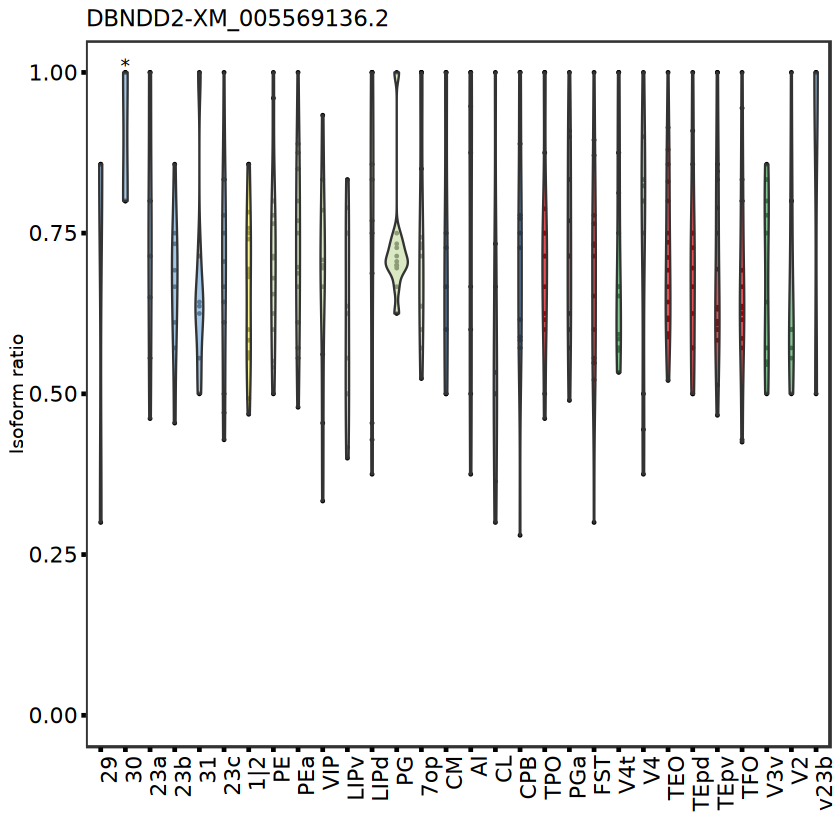

Warning message:
"Groups with fewer than two datapoints have been dropped.
ℹ Set `drop = FALSE` to consider such groups for position adjustment purposes."
Warning message:
"Computation failed in `stat_compare_means()`.
Caused by error in `t.test.default()`:
! not enough 'x' observations"
file saved to result/figure4/Lobe_case_spatial_DBNDD2_boxplot2_24_12_21.pdf



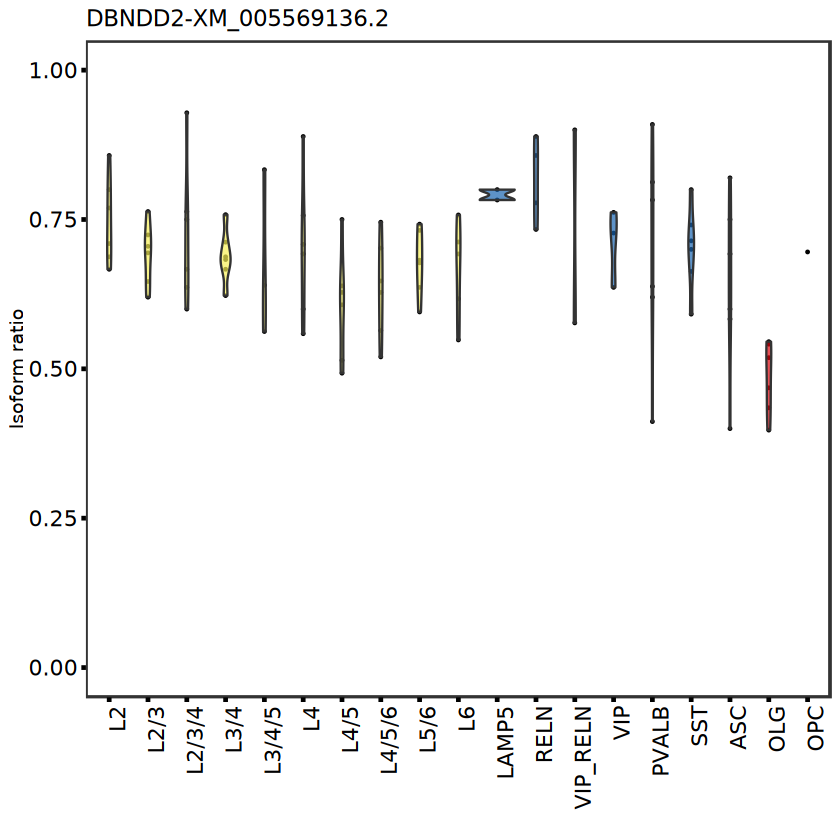

In [25]:
fsraw.cor$areatr = fsraw.cor$region
fsraw.cor$chunk = fsraw.cor$subclass
fsraw.cor$group = fsraw.cor$lobe
isosigi = isosigls$region
#pc1.1 = ModuleCasePlot(isosigi,"CAPRIN1",fsraw.cor,2,lobeorder)
pc1.1 = ModuleCasePlot(isosigi,"DBNDD2",fsraw.cor,2,regionorder,suborder,2)
pc1.1
ggexport(pc1.1,filename = "result/figure4/Lobe_case_spatial_DBNDD2_boxplot_24_12_21.pdf",width = 12,height = 3)

fsraw.cor$areatr = fsraw.cor$subclass
fsraw.cor$chunk = fsraw.cor$lobe
fsraw.cor$group = fsraw.cor$class
isosigi = isosigls$subclass
#pc1.1 = ModuleCasePlot(isosigi,"CAPRIN1",fsraw.cor,2,lobeorder)
pc1.1 = ModuleCasePlot(isosigi,"DBNDD2",fsraw.cor,2,suborder,regionorder)
pc1.1
ggexport(pc1.1,filename = "result/figure4/Lobe_case_spatial_DBNDD2_boxplot2_24_12_21.pdf",width = 12,height = 3)

`summarise()` has grouped output by 'group', 'areatr', 'chunk', 'gene_id'. You
can override using the `.groups` argument.
`summarise()` has grouped output by 'group', 'areatr', 'chunk', 'gene_id'. You
can override using the `.groups` argument.
Warning message:
"Groups with fewer than two datapoints have been dropped.
ℹ Set `drop = FALSE` to consider such groups for position adjustment purposes."
Warning message:
"Computation failed in `stat_compare_means()`.
Caused by error in `t.test.default()`:
! not enough 'x' observations"


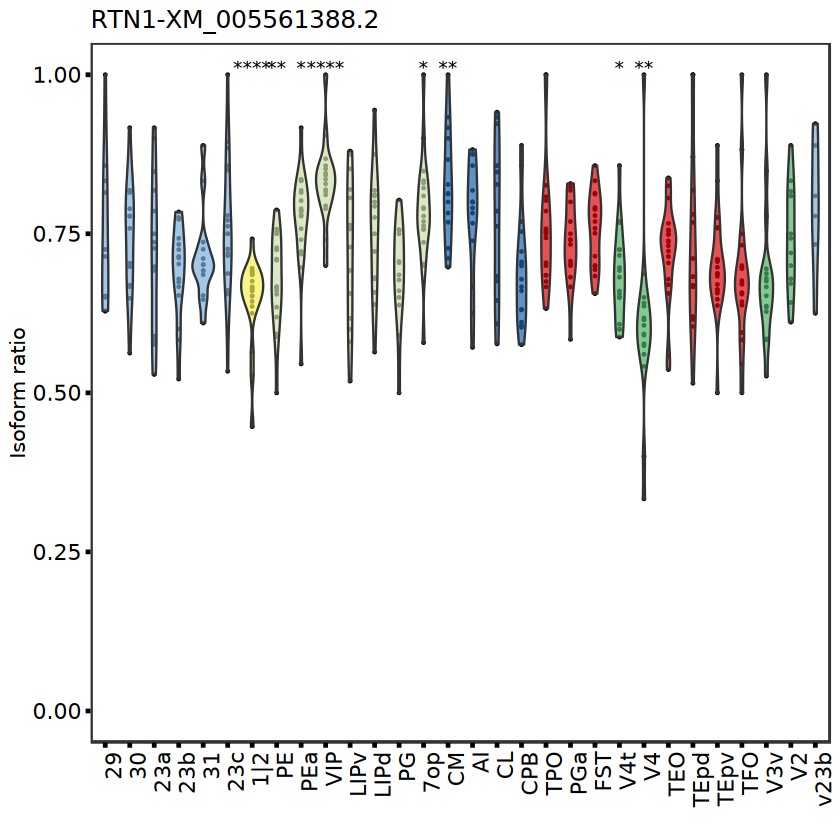

Warning message:
"Groups with fewer than two datapoints have been dropped.
ℹ Set `drop = FALSE` to consider such groups for position adjustment purposes."
Warning message:
"Computation failed in `stat_compare_means()`.
Caused by error in `t.test.default()`:
! not enough 'x' observations"
file saved to result/figure4/Lobe_case_spatial_RTN1_boxplot_24_12_21.pdf



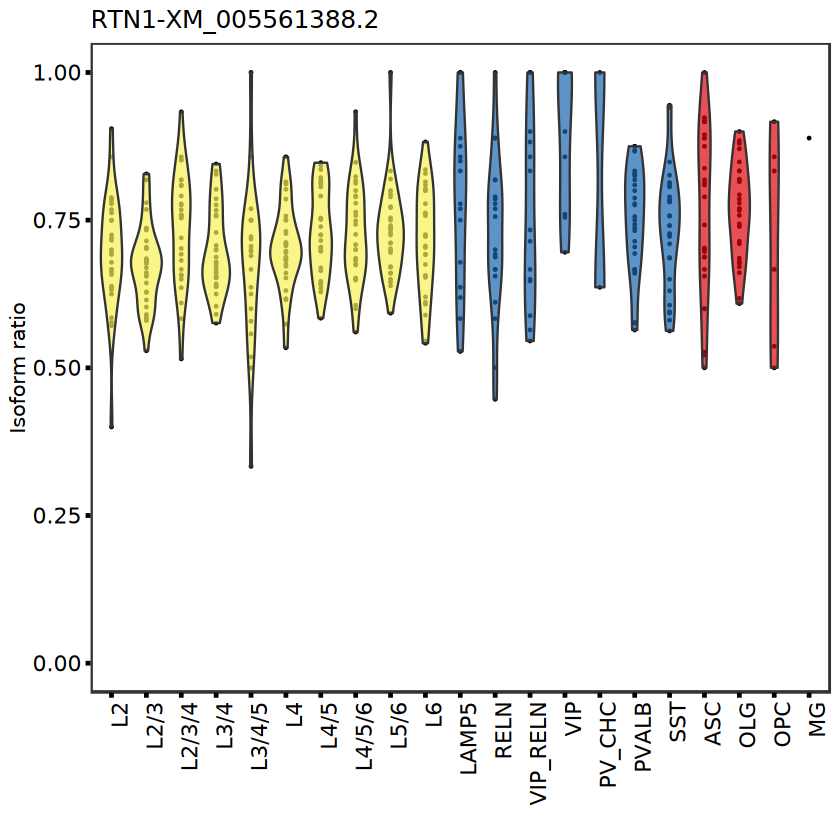

In [307]:
fsraw.cor$areatr = fsraw.cor$region
fsraw.cor$chunk = fsraw.cor$subclass
fsraw.cor$group = fsraw.cor$lobe
isosigi = isosigls$region
#pc1.1 = ModuleCasePlot(isosigi,"CAPRIN1",fsraw.cor,2,lobeorder)
pc1.1 = ModuleCasePlot(isosigi,"RTN1",fsraw.cor,1,regionorder,suborder)
pc1.1

fsraw.cor$areatr = fsraw.cor$subclass
fsraw.cor$chunk = fsraw.cor$region
fsraw.cor$group = fsraw.cor$class
pc1.2 = ModuleCasePlot(isosigi,"RTN1",fsraw.cor,1,suborder,regionorder)
pc1.2
ggexport(pc1.1+pc1.2,
         filename = "result/figure4/Lobe_case_spatial_RTN1_boxplot_24_12_21.pdf",width = 10,height = 3)
# fsraw.cor$areatr = fsraw.cor$region
# fsraw.cor$chunk = fsraw.cor$subclass
# pc1.1 = ModuleCasePlot(isosigi,"DBNDD2",fsraw.cor,2,regionorder,suborder,5)
# pc1.1
# fsraw.cor$areatr = fsraw.cor$subclass
# fsraw.cor$chunk = fsraw.cor$region
# pc1.2 = ModuleCasePlot(isosigi,"DBNDD2",fsraw.cor,2,suborder,regionorder,5)
# pc1.2

[1] "XM_005561388.2" "XM_005561389.2"

`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.
Warning message:
"Removed 779 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 694 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 5 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_

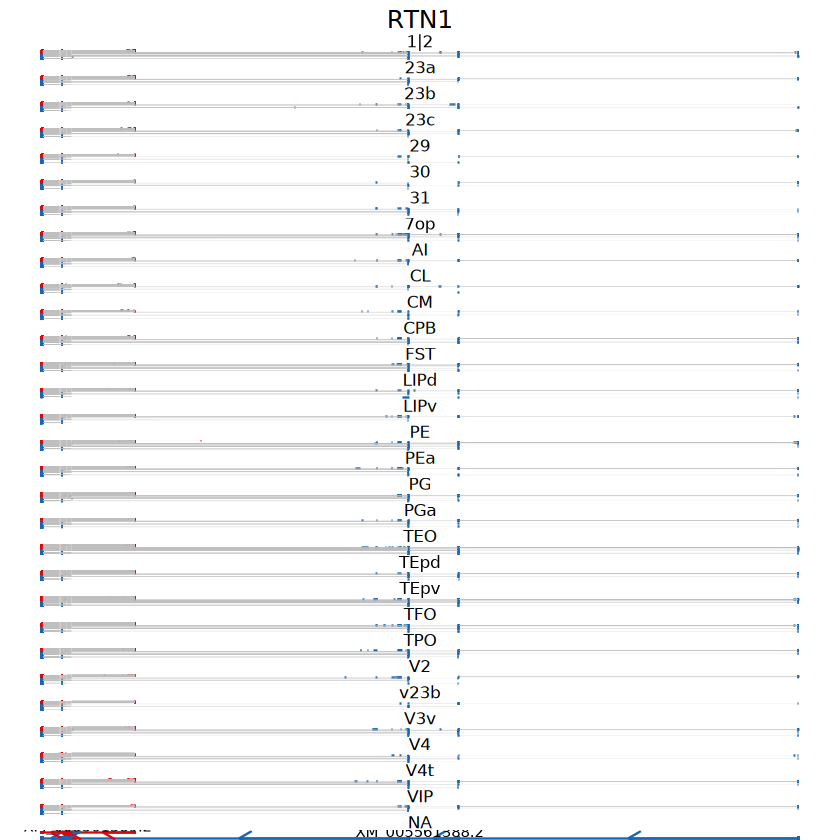

In [360]:
geneex = "RTN1"
isosigi = isosigls$region
unique(isosigi[isosigi$gene_id == geneex,]$transcript_id)
fsraw.cor$areatr = fsraw.cor$region
psp1 = IsoformReadPlotTotal(fsraw.cor,isosigi,longbed,gtf,geneex,NULL,TRUE,mycolor = c('#1965B0','#DC050C'))
psp1
fileid = paste0("result/figure4/",geneex,"_region_case_readsplice_fullscope_24_10_23.pdf")
ggexport(psp1,filename = fileid,width = 4,height = 15)

In [90]:
genehub = isosigtri[isosigtri$sig == "cell",]$gene_id
isosigi = isosigls$region
isosigi.hub = isosigi[isosigi$gene_id %in% genehub & isosigi$sig != "N",]
isosigi.hub
#isosigi.hub
isosigi = isosigls$region
isosigi.hub = isosigi[isosigi$gene_id %in% "DBNDD2"  & isosigi$sig != "N",]
isosigi.hub
#ggplot(isosigi.hub,aes(x = areatr))

gene_id transcript_id   areatr count genecount relative  meanrelative
40261  CCDC136 XM_015448009.1  31       23   178      0.1292135 0.2354791   
40284  CCDC136 XM_015448009.1  v23b     31    89      0.3483146 0.2354791   
40321  CCDC136 XM_015448015.1  31      103   178      0.5786517 0.4785219   
40344  CCDC136 XM_015448015.1  v23b     30    89      0.3370787 0.4785219   
59964  DBNDD2  XM_005569136.2  23b     234   298      0.7852349 0.6679821   
61560  DDX17   XM_005567295.2  23a     182   189      0.9629630 0.8621768   
71961  EEF1B2  EEF1B2-WeiLab-1 LIPv    157   342      0.4590643 0.3490588   
71991  EEF1B2  NM_001284704.1  LIPv    185   342      0.5409357 0.6509412   
100688 HERC1   XM_005559745.2  1|2     107   884      0.1210407 0.2272382   
100689 HERC1   XM_005559745.2  23a      25   194      0.1288660 0.2272382   
100718 HERC1   XM_015452916.1  1|2     744   884      0.8416290 0.7170555   
100719 HERC1   XM_015452916.1  23a     163   194      0.8402062 0.7170555   
115793 KIFAP3  XM_005539957.2  29       84   127      0.6614173 0.7588519   
115818 KIFAP3  XM_005539957.2  v23b     56    89      0.6292135 0.7588519   
120013 LMO3    XM_005570255.2  31      205   227      0.9030837 0.7863926   
160170 MYL6    MYL6-WeiLab-1   31       63   299      0.2107023 0.3074032   
160193 MYL6    MYL6-WeiLab-1   v23b     69   146      0.4726027 0.3074032   
160200 MYL6    MYL6-WeiLab-2   31      223   299      0.7458194 0.6359840   
160223 MYL6    MYL6-WeiLab-2   v23b     64   146      0.4383562 0.6359840   
170582 NRCAM   XM_005550511.2  1|2     855   992      0.8618952 0.7597214   
170588 NRCAM   XM_005550511.2  31      172   197      0.8730964 0.7597214   
170590 NRCAM   XM_005550511.2  AI      134   212      0.6320755 0.7597214   
170611 NRCAM   XM_005550511.2  v23b    100   152      0.6578947 0.7597214   
170641 NRCAM   XM_015447933.1  v23b     41   152      0.2697368 0.1591283   
172322 NTRK2   XM_005582045.2  v23b     57   330      0.1727273 0.3287473   
172359 NTRK2   XM_005582051.2  31       99   199      0.4974874 0.6127637   
172382 NTRK2   XM_005582051.2  v23b    262   330      0.7939394 0.6127637   
175860 OSBPL1A XM_005587007.2  29       57   106      0.5377358 0.4032156   
175892 OSBPL1A XM_005587011.2  31      142   256      0.5546875 0.4183674   
175945 OSBPL1A XM_005587012.2  v23b     38   138      0.2753623 0.1610184   
219882 SARAF   NM_001285301.1  v23b     57   210      0.2714286 0.1235170   
219912 SARAF   XM_015454356.1  v23b    153   210      0.7285714 0.8764830   
223516 SEPT8   XM_005557741.2  29      109   159      0.6855346 0.7906472   
243960 SYT1    NM_001285042.1  31     1010  1208      0.8360927 0.7362798   
       otherrelative dr         sig  pvalue       padj        
40261  0.2391435     -0.1099300 Down 5.946148e-11 1.368287e-09
40284  0.2315882      0.1167264 Up   5.946148e-11 1.368287e-09
40321  0.4750691      0.1035826 Up   5.946148e-11 1.368287e-09
40344  0.4833992     -0.1463206 Down 5.946148e-11 1.368287e-09
59964  0.6639389      0.1212960 Up   5.418703e-06 4.166866e-05
61560  0.8587014      0.1042615 Up   3.579147e-09 5.804690e-08
71961  0.3452655      0.1137988 Up   6.257658e-11 1.429183e-09
71991  0.6547345     -0.1137988 Down 6.257658e-11 1.429183e-09
100688 0.2309002     -0.1098595 Down 8.271031e-20 5.864738e-18
100689 0.2306304     -0.1017644 Down 8.271031e-20 5.864738e-18
100718 0.7127599      0.1288691 Up   8.271031e-20 5.864738e-18
100719 0.7128089      0.1273973 Up   8.271031e-20 5.864738e-18
115793 0.7622117     -0.1007944 Down 4.253783e-18 2.494189e-16
115818 0.7633222     -0.1341087 Down 4.253783e-18 2.494189e-16
120013 0.7823687      0.1207150 Up   6.035527e-20 4.488371e-18
160170 0.3107377     -0.1000353 Down 2.333182e-11 5.736994e-10
160193 0.3017066      0.1708961 Up   2.333182e-11 5.736994e-10
160200 0.6321966      0.1136228 Up   2.333182e-11 5.736994e-10
160223 0.6427988     -0.2044426 Down 2.333182e-11 5.736994e-10
170582 0.7561982      0.1056970 Up   8.370904e-10 1.

gene_id transcript_id  areatr count genecount relative  meanrelative
59964 DBNDD2  XM_005569136.2 23b    234   298       0.7852349 0.6679821   
      otherrelative dr       sig pvalue       padj        
59964 0.6639389     0.121296 Up  5.418703e-06 4.166866e-05

In [21]:
SpCasePlot = function(mkdf,hubtrans,edgesdf,ptsize = 1){
    mkdf = mkdf[mkdf$transcript_id %in% hubtrans,]
    mkdf = mkdf[order(mkdf$transcript_id),]
    pmkpti1 = ggplot() +
      scattermore::geom_scattermore(
        data = backpt,
        aes(x,y),
        color = "white",
        # pixels = raster.dpi,
        pointsize = 0.05
      ) +
      geom_segment(data = edgesdf, aes(x = x1, y = y1, xend = x2, yend = y2,color = areatr),
                 size = 0.5,alpha = 0.75) + 
      geom_point(data = mkdf,
                 aes(x,y,fill = transcript_id),shape = 21,size = ptsize,stroke = 0) + 
     # scale_size(range = c(0.05,0.1)) +
      #facet_wrap(~layer,nrow = 2) 
      theme_void() +
      scale_fill_discreterainbow() +
      scale_color_viridis(discrete = T) +
      theme_presentation() + 
      theme(legend.position = "top",legend.title = element_blank(),
            legend.text = element_text(size = 8)) +
      guides(color = guide_legend(override.aes = list(size=4),nrow = 3),
            fill = guide_legend(override.aes = list(size=4),nrow = 2),
            size = "none") +
      scale_y_reverse() + scale_x_reverse()
    return(pmkpti1)
}

SpCasePlotZoom = function(mkdf,hubtrans,zoomid,fsraw.cor,ptsize = 1){
    mkdf = mkdf[mkdf$transcript_id %in% hubtrans,]
    mkdf = mkdf[order(mkdf$transcript_id),]
    mkdf = mkdf[mkdf$region %in% zoomid,]
    fsraw.zoom = fsraw.cor[fsraw.cor$region %in% zoomid,]
    backpt.zoom = backpt[backpt$x < max(fsraw.zoom$x) & backpt$x > min(fsraw.zoom$x) &
                         backpt$y < max(fsraw.zoom$y) & backpt$y > min(fsraw.zoom$y),]
    pmkpti1 = ggplot() +
      scattermore::geom_scattermore(
        data = backpt.zoom,
        aes(x,y),
        color = "white",
        # pixels = raster.dpi,
        pointsize = 0.05
      ) +
      # geom_segment(data = edgesdf, aes(x = x1, y = y1, xend = x2, yend = y2,color = areatr),
      #            size = 0.5,alpha = 0.75) + 
      geom_point(data = mkdf,
                 aes(x,y,fill = transcript_id),shape = 21,size = ptsize,stroke = NA) + 
     # scale_size(range = c(0.05,0.1)) +
      #facet_wrap(~layer,nrow = 2) 
      theme_void() +
      scale_fill_discreterainbow() +
      scale_color_flatui() +
      theme_presentation() + 
      theme(legend.position = "top",legend.title = element_blank(),
            legend.text = element_text(size = 8)) +
      guides(color = guide_legend(override.aes = list(size=4),nrow = 3),
            fill = guide_legend(override.aes = list(size=4),nrow = 2),
            size = "none") +
      scale_y_reverse() + scale_x_reverse() + ggtitle(zoomid)
    return(pmkpti1)
}

In [21]:
head(backpt)

cell_id gene_id transcript_id  class subclass x     y     readnum
1 1       ANAPC11 XM_005585268.2 GLU   L6        8433 77822 1      
2 1       AP2M1   XM_005546525.2 GLU   L6       48984 77801 1      
3 1       ATF7    XM_005571037.2 GLU   L6        8416 77824 1      
4 1       ATP5D   XM_005587367.1 GLU   L6        8424 77813 1      
5 1       ATP5J   XM_015446616.1 GLU   L6       51202 77805 1      
6 1       ATP5J   XM_015446617.1 GLU   L6       11587 77807 1

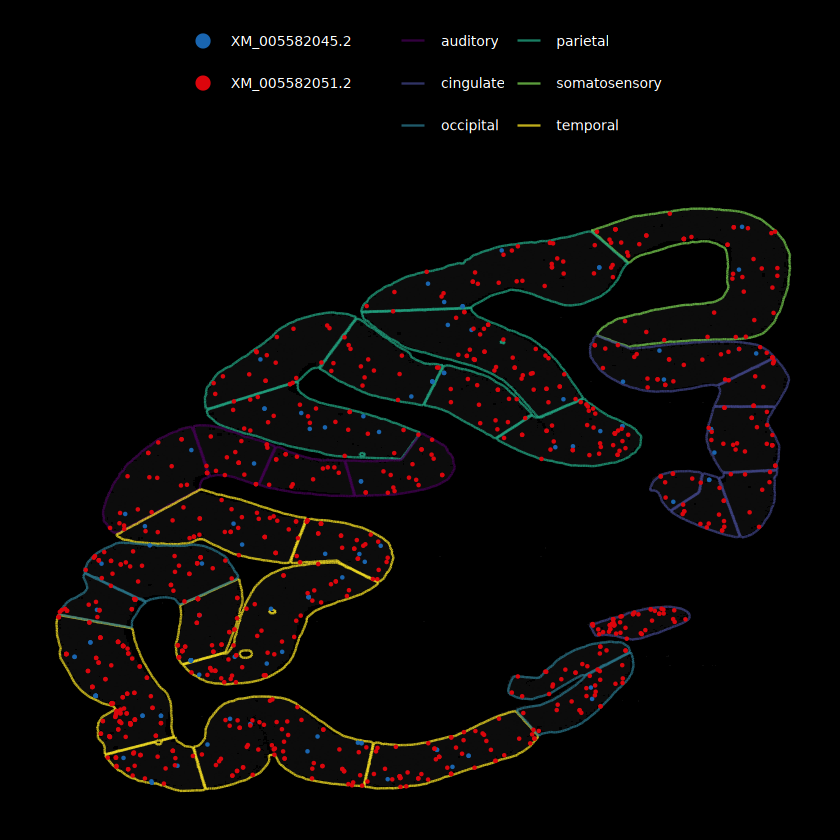

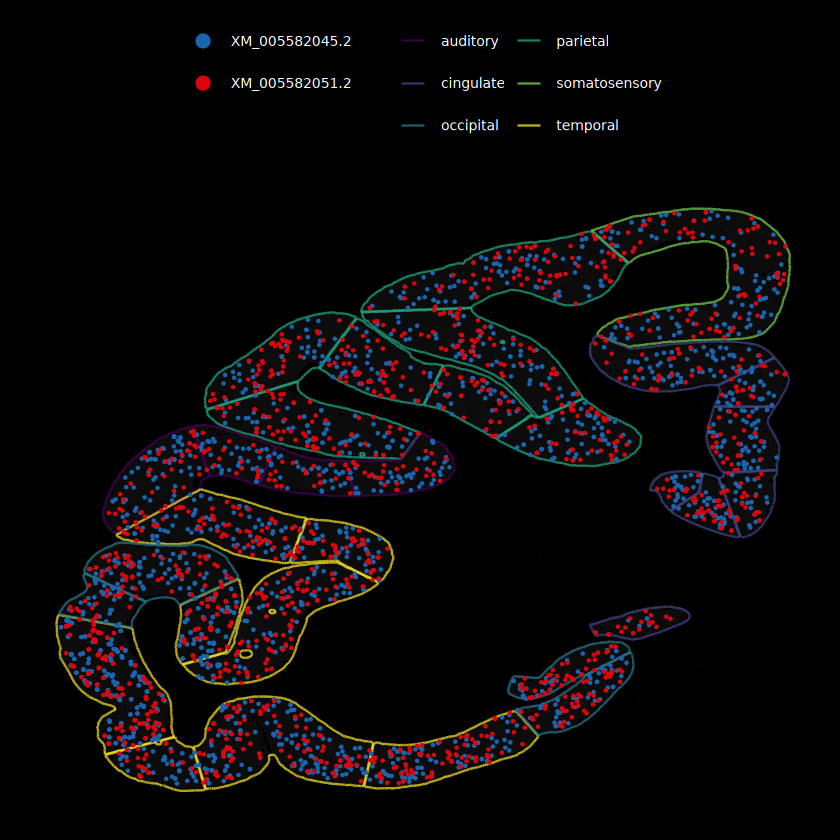

file saved to result/figure5/Lobe_case_spatial_NTRK2_24_12_23.pdf



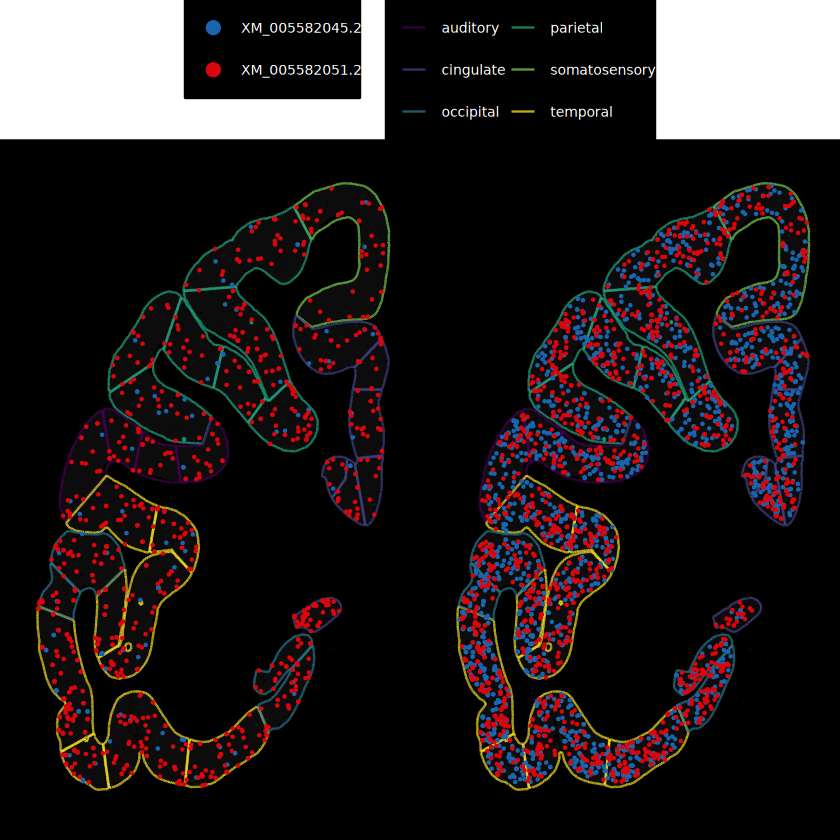

In [327]:
#case1 MYL6
geneex = "NTRK2"
isosigi = isosigls$subclass
isosigi = isosigi[isosigi$sig != "N" & isosigi$gene_id %in% geneex,]
hubtrans = unique(isosigi$transcript_id)

mkdf = fsraw.cor[fsraw.cor$gene_id == geneex & fsraw.cor$subclass == "ASC",]
mkdf = mkdf[mkdf$transcript_id %in% hubtrans,]
pmkpti1 = SpCasePlot(mkdf,hubtrans,edgesdf)
pmkpti1

mkdf = fsraw.cor[fsraw.cor$gene_id == geneex & fsraw.cor$class == "GLU",]
mkdf = mkdf[mkdf$transcript_id %in% hubtrans,]
mkdf = mkdf[order(mkdf$transcript_id),]
pmkpti2 = SpCasePlot(mkdf,hubtrans,edgesdf)
pmkpti2
pmkpti = ggarrange(pmkpti1,pmkpti2,nrow = 1, common.legend = T)
pmkpti
ggexport(pmkpti,filename = "result/figure5/Lobe_case_spatial_NTRK2_24_12_23.pdf",width = 8,height = 6)
#ggexport(pmkpti1,filename = "result/figure5/L1_ASC_case_spatial_NTRK2_24_09_23.pdf",width = 6,height = 6)

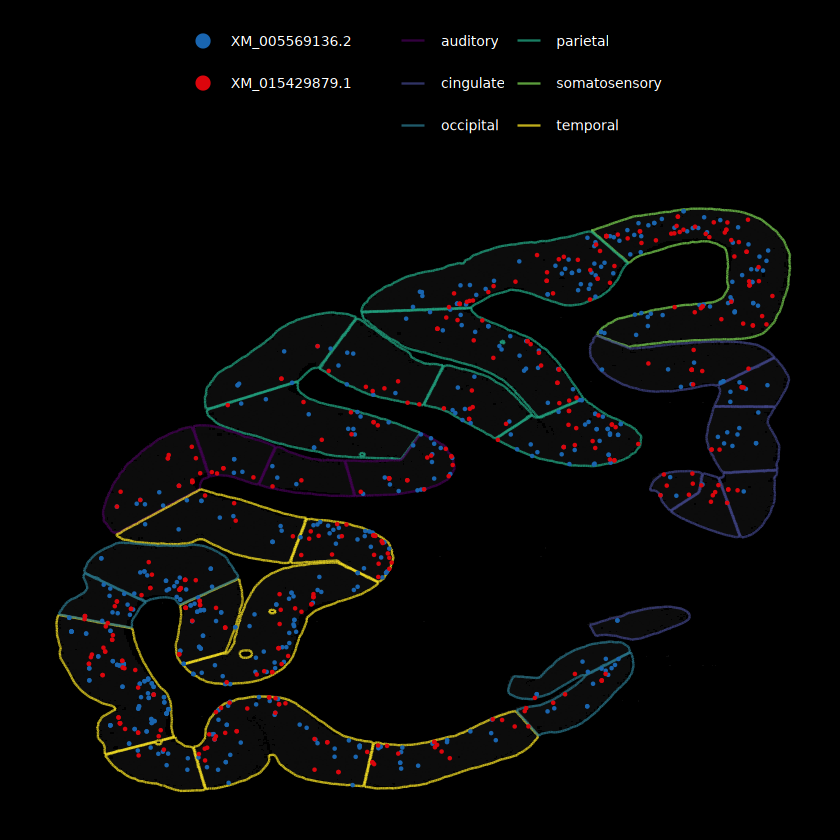

file saved to result/figure5/Lobe_case_spatial_DBNDD2_24_12_23.pdf



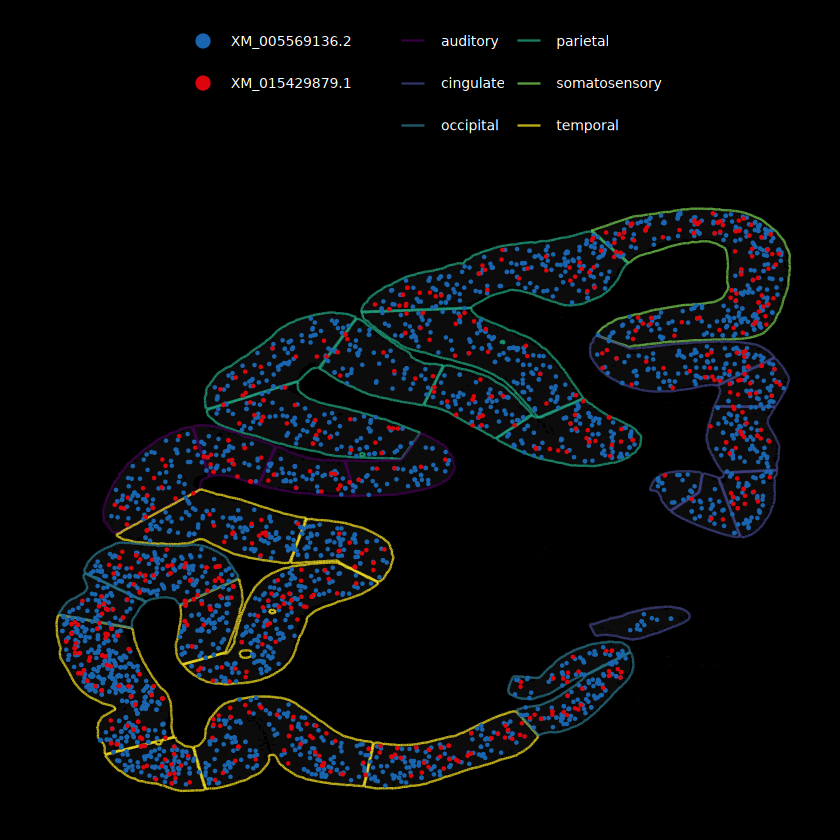

In [338]:
#case1 MYL6
geneex = "DBNDD2"
isosigi = isosigls$subclass
isosigi = isosigi[isosigi$sig != "N" & isosigi$gene_id %in% geneex,]
hubtrans = unique(isosigi$transcript_id)

mkdf = fsraw.cor[fsraw.cor$gene_id == geneex & fsraw.cor$subclass == "OLG",]
mkdf = mkdf[mkdf$transcript_id %in% hubtrans,]
pmkpti1 = SpCasePlot(mkdf,hubtrans,edgesdf)
pmkpti1

mkdf = fsraw.cor[fsraw.cor$gene_id == geneex & fsraw.cor$class == "GLU",]
mkdf = mkdf[mkdf$transcript_id %in% hubtrans,]
mkdf = mkdf[order(mkdf$transcript_id),]
pmkpti2 = SpCasePlot(mkdf,hubtrans,edgesdf)
pmkpti2
pmkpti = ggarrange(pmkpti1,pmkpti2,nrow = 1, common.legend = T)
pmkpti
ggexport(pmkpti,filename = "result/figure5/Lobe_case_spatial_DBNDD2_24_12_23.pdf",width = 8,height = 6)
#ggexport(pmkpti1,filename = "result/figure5/L1_ASC_case_spatial_NTRK2_24_09_23.pdf",width = 6,height = 6)

file saved to result/figure4/Lobe_case_spatial_DBNDD2_zoomed_25_03_08.pdf



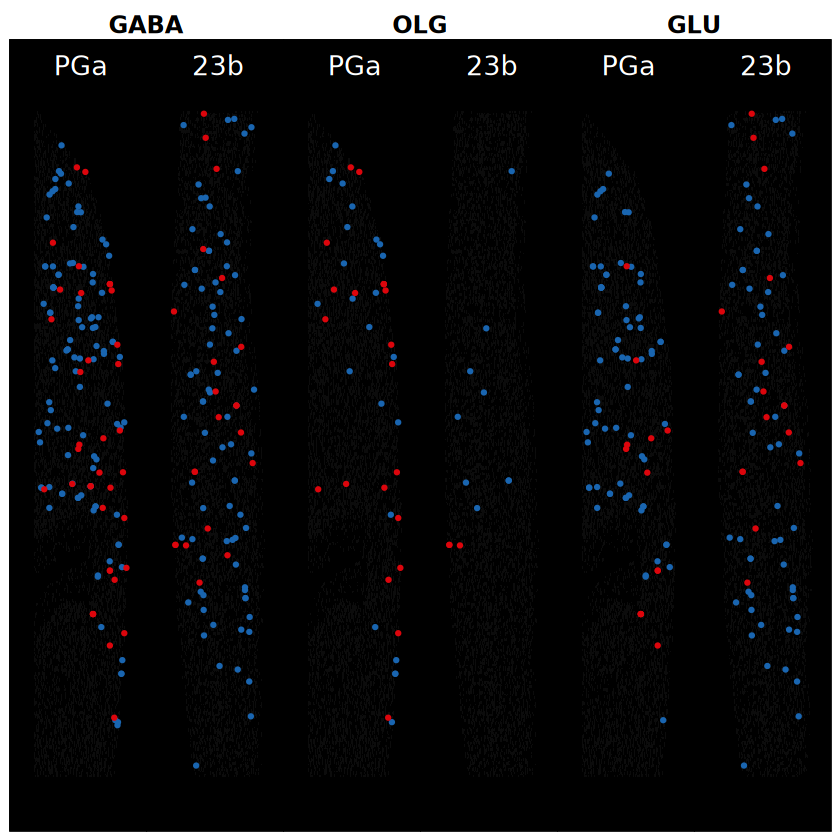

In [107]:
#case2 Lobe
geneex = "DBNDD2"
edgesdf$areatr = edgesdf$lobe
# isosigi = isosigls$subclass
# isosigi = isosigi[isosigi$gene_id %in% geneex,]
hubtrans = c('XM_005569136.2','XM_015429879.1')
fsraw.cor$areatr = fsraw.cor$subclass
RTN1CasePlot = function(subid,geneex,hubtrans,legend = F,ptsize = 1.5){
    mkdf = fsraw.cor[fsraw.cor$gene_id == geneex & fsraw.cor$areatr %in% subid,]
    #mkdf.zoom = mkdf[mkdf$region == "1|2",]
    pmkpti1 = SpCasePlotZoom(mkdf,hubtrans,"PGa",fsraw.cor,ptsize)
    pmkpti2 = SpCasePlotZoom(mkdf,hubtrans,"23b",fsraw.cor,ptsize)
    if(legend == T){
        pmkpti = ggarrange(pmkpti1,pmkpti2,common.legend = T,legend = "right")
    }else{
        pmkpti = ggarrange(pmkpti1,pmkpti2,common.legend = T,legend = "none")
    }
    pmkpti = annotate_figure(pmkpti, top = text_grob(subid, color = "black", face = "bold", size = 14))
    return(pmkpti)
}
fsraw.cor$areatr = fsraw.cor$class

#pmkpt2 = RTN1CasePlot("PVALB","RTN1",hubtrans)
#pmkpt2
pmkpt1 = RTN1CasePlot(c("GABA","GLU","NonNeuron"),geneex,hubtrans,F)
#pmkpt1
fsraw.cor$areatr = fsraw.cor$subclass
pmkpt2 = RTN1CasePlot("OLG",geneex,hubtrans)
fsraw.cor$areatr = fsraw.cor$class
pmkpt3 = RTN1CasePlot("GLU",geneex,hubtrans)
#pmkpt3
library(Seurat)
pmkpt = pmkpt1 + pmkpt2 +  pmkpt3
pmkpt
ggexport(pmkpt,filename = "result/figure4/Lobe_case_spatial_DBNDD2_zoomed_25_03_08.pdf",width = 15,height = 3)


In [23]:
rgb(0,160,233,maxColorValue = 255)
rgb(195,13,35,maxColorValue = 255)

[1] "#00A0E9"

[1] "#C30D23"

`summarise()` has grouped output by 'lobe', 'region'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'region'. You can override using the
`.groups` argument.


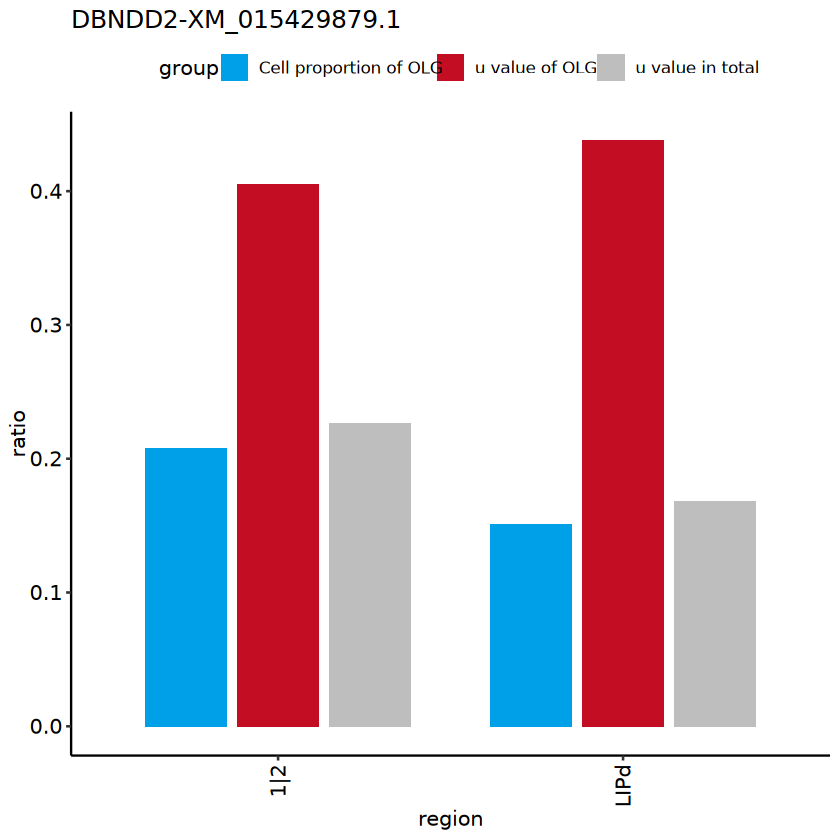

In [29]:
geneex = "DBNDD2"
transid = "XM_015429879.1"
#geneex = "SYT1"
#transid = "NM_001285042.1"
fsraw.case = fsraw.cor[fsraw.cor$gene_id == geneex,]
clpos = fsraw.case %>% group_by(lobe,region,subclass) %>% summarise(count = length(unique(readid)))
clpos = clpos[clpos$subclass != "",]
clpos = clpos %>% group_by(lobe,region) %>% mutate(tcount = sum(count),ratio = count/tcount)
clpos$region = factor(clpos$region,levels = regionorder)
clpos$lobe = factor(clpos$lobe,levels = lobeorder)
clposf = clpos[clpos$subclass == "OLG" & clpos$count > 10,]
# ggplot(clposf,aes(x = region,y = ratio,fill = subclass)) + geom_bar(stat = "identity",position = "stack") + 
# scale_fill_discreterainbow() + theme_pubr() + theme(axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1))

isocase = isosigls$region
isocasef = isocase[isocase$gene_id == geneex & isocase$transcript_id == transid,]
isocasef$areatr = factor(isocasef$areatr,levels = regionorder)

clposf.hub = clposf[,c("region","ratio")]
clposf.hub$group = "Cell proportion of OLG"
isocasef.hub = isocasef[,c("areatr","relative")]
isocasef.hub$group = "u value in total"
colnames(isocasef.hub) = c("region","ratio","group")

datadf = fsraw.case[fsraw.case$subclass == "OLG",] %>% group_by(region,transcript_id) %>% summarise(count = n())
isocasef.hubc <- datadf %>% group_by(region) %>% 
          arrange(desc(transcript_id)) %>%
          mutate(ratio = count / sum(count))
isocasef.hubc = isocasef.hubc[isocasef.hubc$transcript_id %in% transid,]
isocasef.hubc = isocasef.hubc[,c("region","ratio")]
isocasef.hubc$group = "u value of OLG"

hubcmp = rbind(clposf.hub,isocasef.hub,isocasef.hubc)
hubcmp = hubcmp[hubcmp$region %in% c("1|2","LIPd"),]
hubcmp$group = factor(hubcmp$group,levels = c("Cell proportion of OLG","u value of OLG","u value in total"))
pcm1 = ggplot(hubcmp,aes(x = region,y = ratio,fill = group)) + geom_bar(stat = "identity",position = position_dodge(0.8),width = 0.7) + 
    scale_fill_manual(values = c('#00A0E9','#C30D23','grey')) + theme_pubr() + theme(axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1)) +
    ggtitle("DBNDD2-XM_015429879.1")
pcm1
#ggexport(pcm,filename = "result/figure4/Lobe_case_spatial_DBNDD2_zoomed_stat_bar_25_03_10.pdf",width = 2,height = 4)


In [36]:
hubcmp

region ratio     group                 
1 LIPd   0.1509434 Cell proportion of OLG
2 1|2    0.2079208 Cell proportion of OLG
3 1|2    0.2265077 u value in total      
4 LIPd   0.1677632 u value in total      
5 1|2    0.4047619 u value of OLG        
6 LIPd   0.4375000 u value of OLG

`summarise()` has grouped output by 'lobe', 'region'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'region'. You can override using the
`.groups` argument.


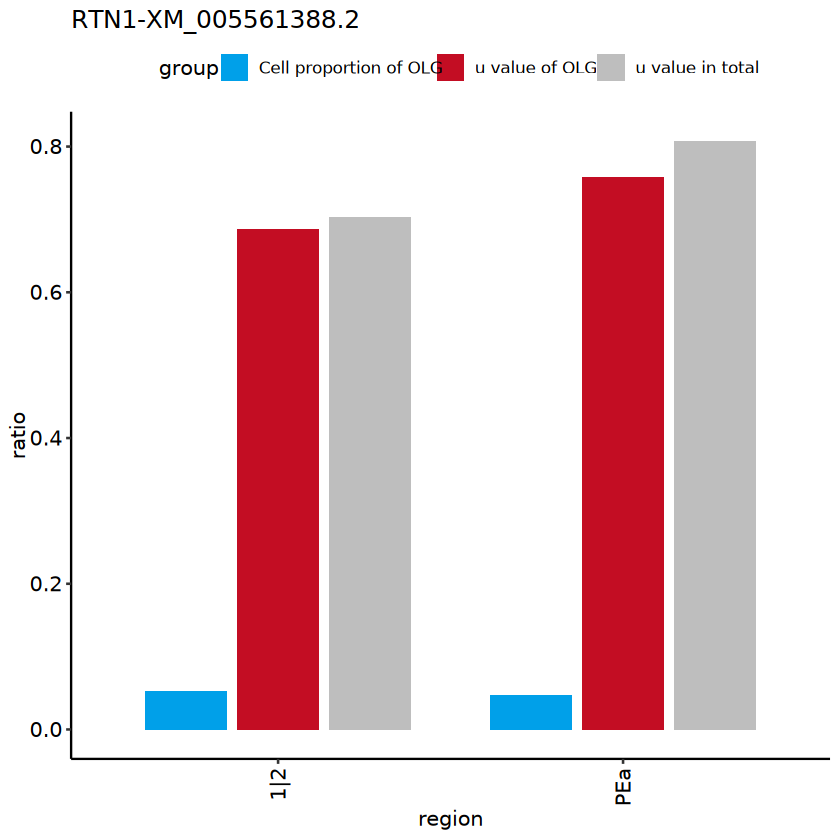

In [27]:
geneex = "RTN1"
transid = "XM_005561388.2"
#geneex = "SYT1"
#transid = "NM_001285042.1"
fsraw.case = fsraw.cor[fsraw.cor$gene_id == geneex,]
clpos = fsraw.case %>% group_by(lobe,region,subclass) %>% summarise(count = length(unique(readid)))
clpos = clpos[clpos$subclass != "",]
clpos = clpos %>% group_by(lobe,region) %>% mutate(tcount = sum(count),ratio = count/tcount)
clpos$region = factor(clpos$region,levels = regionorder)
clpos$lobe = factor(clpos$lobe,levels = lobeorder)
clposf = clpos[clpos$subclass == "OLG" & clpos$count > 10,]
# ggplot(clposf,aes(x = region,y = ratio,fill = subclass)) + geom_bar(stat = "identity",position = "stack") + 
# scale_fill_discreterainbow() + theme_pubr() + theme(axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1))

isocase = isosigls$region
isocasef = isocase[isocase$gene_id == geneex & isocase$transcript_id == transid,]
isocasef$areatr = factor(isocasef$areatr,levels = regionorder)
# ggplot(isocase[isocase$count > 10 &isocase$areatr %in% clposf$region,],aes(x = areatr,y = relative)) + geom_bar(stat = "identity",position = "stack") + 
# scale_fill_discreterainbow() + theme_pubr() + theme(axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1))

clposf.hub = clposf[,c("region","ratio")]
clposf.hub$group = "Cell proportion of OLG"
isocasef.hub = isocasef[,c("areatr","relative")]
isocasef.hub$group = "u value in total"
colnames(isocasef.hub) = c("region","ratio","group")

datadf = fsraw.case[fsraw.case$subclass == "OLG",] %>% group_by(region,transcript_id) %>% summarise(count = n())
isocasef.hubc <- datadf %>% group_by(region) %>% 
          arrange(desc(transcript_id)) %>%
          mutate(ratio = count / sum(count))
isocasef.hubc = isocasef.hubc[isocasef.hubc$transcript_id %in% transid,]
isocasef.hubc = isocasef.hubc[,c("region","ratio")]
isocasef.hubc$group = "u value of OLG"

hubcmp = rbind(clposf.hub,isocasef.hub,isocasef.hubc)
hubcmp$group = factor(hubcmp$group,levels = c("Cell proportion of OLG","u value of OLG","u value in total"))
hubcmp = hubcmp[hubcmp$region %in% c("1|2","PEa"),]
pcm2 = ggplot(hubcmp,aes(x = region,y = ratio,fill = group)) + geom_bar(stat = "identity",position = position_dodge(0.8),width = 0.7) + 
    scale_fill_manual(values = c('#00A0E9','#C30D23','grey')) + theme_pubr() + theme(axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1)) +
    ggtitle("RTN1-XM_005561388.2")
pcm2

file saved to result/figure4/Lobe_case_spatial_DBNDD2_RTN1_zoomed_stat_bar_25_04_10.pdf



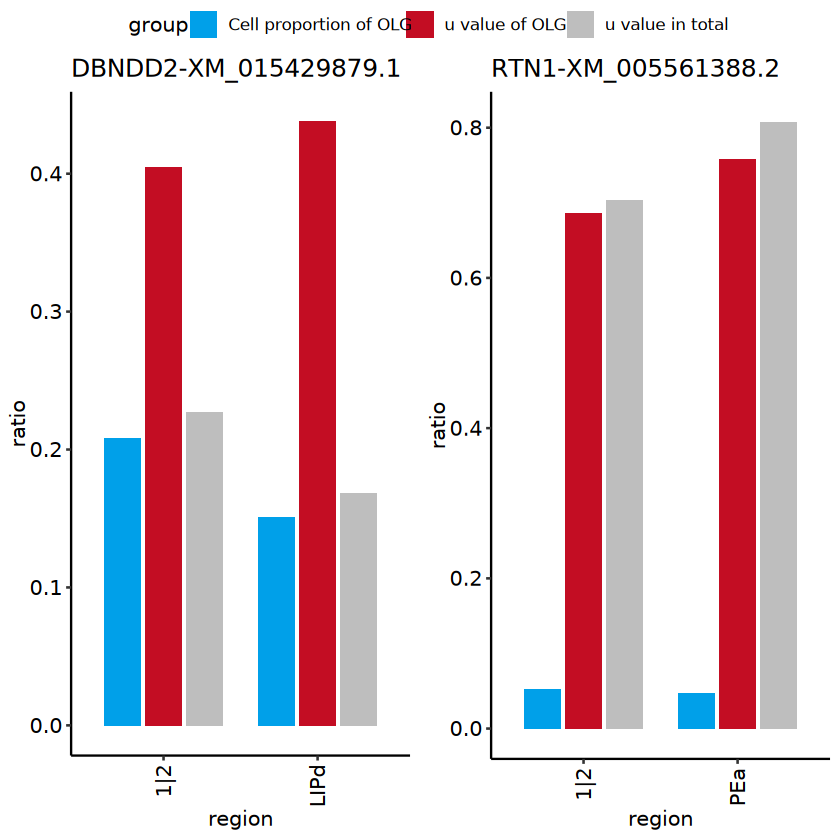

In [31]:
pcm = ggarrange(pcm1,pcm2,nrow = 1,common.legend = T)
pcm
ggexport(pcm,filename = "result/figure4/Lobe_case_spatial_DBNDD2_RTN1_zoomed_stat_bar_25_04_10.pdf",width = 4,height = 4)

In [19]:
PiePlot = function(mkdf){
    datadf = mkdf %>% group_by(region,transcript_id) %>% summarise(count = n())
    datadf <- datadf %>% group_by(region) %>% 
          arrange(desc(transcript_id)) %>%
          mutate(prop = count / sum(count) *100) %>%
          mutate(ypos = cumsum(prop)- 0.5*prop )
    datadf$proplabel = paste0(datadf$count,"(",round(datadf$prop,1),")%")

    p1.4 = ggplot(datadf, aes(x="", y=prop, fill=transcript_id)) +
          geom_bar(stat="identity", width=1, color= NA) +
          facet_wrap(~region) +
          coord_polar("y", start=0) +
          theme_void() + 
          theme(legend.position="none") +
          geom_text(aes(y = ypos, label = proplabel), color = "black", size=3) +
          scale_fill_discreterainbow()
    return(p1.4)
}

PiePlotCell = function(mkdf){
    datadf = mkdf %>% group_by(region,celltype) %>% summarise(celln = length(unique(readid)))
    datadf <- datadf %>% group_by(region) %>% 
          arrange(desc(celltype)) %>%
          mutate(prop = celln / sum(celln) *100) %>%
          mutate(ypos = cumsum(prop)- 0.5*prop )
    datadf$proplabel = paste0(datadf$celln,"(",round(datadf$prop,1),")%")
    mycolor = c("grey","yellow")
    names(mycolor) = levels(mkdf$celltype)
    p1.4 = ggplot(datadf, aes(x="", y=prop, fill=celltype)) +
          geom_bar(stat="identity", width=1, color= NA) +
          facet_wrap(~region) +
          coord_polar("y", start=0) +
          theme_void() + 
          theme(legend.position="none") +
          geom_text(aes(y = ypos, label = proplabel), color = "black", size=3) +
          scale_fill_manual(values = mycolor)
    return(p1.4)
}
RTN1CasePlot = function(subid,geneex,hubtrans,legend = F,ptsize = 1.5){
    mkdf = fsraw.cor[fsraw.cor$gene_id == geneex & fsraw.cor$areatr %in% subid,]
    #mkdf.zoom = mkdf[mkdf$region == "1|2",]
    pmkpti1 = SpCasePlotZoom(mkdf,hubtrans,"1|2",fsraw.cor,ptsize)
    pmkpti2 = SpCasePlotZoom(mkdf,hubtrans,"LIPd",fsraw.cor,ptsize)
    if(legend == T){
        pmkpti = ggarrange(pmkpti1,pmkpti2,common.legend = T,legend = "right")
    }else{
        pmkpti = ggarrange(pmkpti1,pmkpti2,common.legend = T,legend = "none")
    }
    pmkpti = annotate_figure(pmkpti, top = text_grob(subid, color = "black", face = "bold", size = 14))
    return(pmkpti)
}

In [ ]:
#case2 Lobe
geneex = "RTN1"
edgesdf$areatr = edgesdf$lobe
isosigi = isosigls$subclass
isosigi = isosigi[isosigi$gene_id %in% geneex,]
hubtrans = unique(isosigi$transcript_id)
fsraw.cor$areatr = fsraw.cor$subclass
RTN1CasePlot = function(subid,geneex,hubtrans,legend = F,ptsize = 1.5){
    mkdf = fsraw.cor[fsraw.cor$gene_id == geneex & fsraw.cor$areatr %in% subid,]
    #mkdf.zoom = mkdf[mkdf$region == "1|2",]
    pmkpti1 = SpCasePlotZoom(mkdf,hubtrans,"1|2",ptsize)
    pmkpti2 = SpCasePlotZoom(mkdf,hubtrans,"PEa",ptsize)
    if(legend == T){
        pmkpti = ggarrange(pmkpti1,pmkpti2,common.legend = T,legend = "right")
    }else{
        pmkpti = ggarrange(pmkpti1,pmkpti2,common.legend = T,legend = "none")
    }
    pmkpti = annotate_figure(pmkpti, top = text_grob(subid, color = "black", face = "bold", size = 14))
    return(pmkpti)
}
fsraw.cor$areatr = fsraw.cor$class

#pmkpt2 = RTN1CasePlot("PVALB","RTN1",hubtrans)
#pmkpt2
pmkpt1 = RTN1CasePlot(c("GABA","GLU","NonNeuron"),geneex,hubtrans,F,1)
#pmkpt1
fsraw.cor$areatr = fsraw.cor$subclass
pmkpt2 = RTN1CasePlot("OLG","RTN1",hubtrans)
pmkpt3 = RTN1CasePlot("L3/4","RTN1",hubtrans)
#pmkpt3
library(Seurat)
pmkpt = pmkpt1 + pmkpt2 +  pmkpt3
pmkpt
ggexport(pmkpt,filename = "result/figure4/Lobe_case_spatial_RTN1_zoomed_24_12_21.pdf",width = 15,height = 3)

# pmkpt1 = RTN1CasePlot("L3/4")
# pmkpt1 = RTN1CasePlot("L6")
#hubtrans = rev(hubtrans)

# mkdf = fsraw.cor[fsraw.cor$gene_id == geneex & fsraw.cor$class == "GABA",]
# mkdf = mkdf[mkdf$transcript_id %in% hubtrans,]
# mkdf = mkdf[order(mkdf$transcript_id),]
# pmkpti2 = SpCasePlot(mkdf,hubtrans,edgesdf)
# pmkpti2
# pmkpti = ggarrange(pmkpti1,pmkpti2,nrow = 1, common.legend = T)
# pmkpti
#ggexport(pmkpti,filename = "result/figure5/Lobe_case_spatial_RTN1_24_10_15.pdf",width = 8,height = 6)

In [112]:
subid = c("1|2","PEa")
geneex = "RTN1"


mkdf = fsraw.cor[fsraw.cor$gene_id == geneex & fsraw.cor$region %in% subid,]
p1.1 = PiePlot(mkdf)
mkdf = fsraw.cor[fsraw.cor$gene_id == geneex & fsraw.cor$region %in% subid & fsraw.cor$subclass %in% "OLG",]
p1.2 = PiePlot(mkdf)
mkdf = fsraw.cor[fsraw.cor$gene_id == geneex & fsraw.cor$region %in% subid & fsraw.cor$subclass %in% "L3/4",]
p1.3 = PiePlot(mkdf)
p1.1 

p1.2
p1.3
ggexport(p1.1+p1.2+p1.3,filename = "result/figure4/Lobe_case_spatial_RTN1_zoomed_25_03_08.pdf",width = 15,height = 3)

`summarise()` has grouped output by 'region'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'region'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'region'. You can override using the
`.groups` argument.


ERROR: Error in file(con, "rb"): cannot open the connection


plot without title

ERROR: Error in file(con, "rb"): cannot open the connection


plot without title

Warning message in grid.newpage():
"Cannot open temporary file '/tmp/Rtmp0wpa3l/pdfb397763e98aa' for compression (reason: No such file or directory); compression has been turned off for this device"
file saved to result/figure4/Lobe_case_spatial_RTN1_zoomed_25_03_08.pdf



ERROR: Error in file(con, "rb"): cannot open the connection


plot without title

`summarise()` has grouped output by 'region'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'region'. You can override using the
`.groups` argument.
file saved to result/figure4/Lobe_case_spatial_RTN1_zoomed_cellporp_pie_25_04_23.pdf



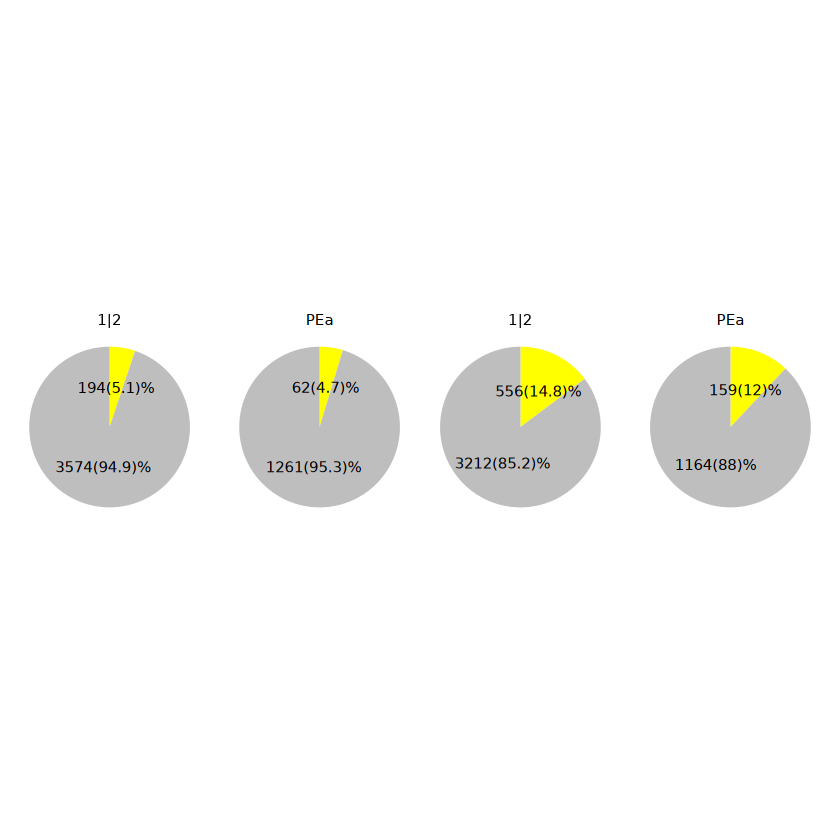

In [51]:
subid = c("1|2","PEa")
geneex = "RTN1"
mkdf = fsraw.cor[fsraw.cor$gene_id == geneex & fsraw.cor$region %in% subid & 
                 fsraw.cor$subclass != "",]
mkdf$celltype = mkdf$subclass
mkdf[mkdf$subclass != "OLG",]$celltype = "other"
mkdf$celltype = factor(mkdf$celltype,levels = c("other","OLG"))
p3.1 = PiePlotCell(mkdf)

mkdf = fsraw.cor[fsraw.cor$gene_id == geneex & fsraw.cor$region %in% subid & 
                 fsraw.cor$subclass != "",]
mkdf$celltype = mkdf$subclass
mkdf[mkdf$subclass != "L3/4",]$celltype = "other"
mkdf$celltype = factor(mkdf$celltype,levels = c("other","L3/4"))
p3.2 = PiePlotCell(mkdf)
p3.1+p3.2
ggexport(p3.1+p3.2,filename = "result/figure4/Lobe_case_spatial_RTN1_zoomed_cellporp_pie_25_12_04.pdf",width = 10,height = 3)


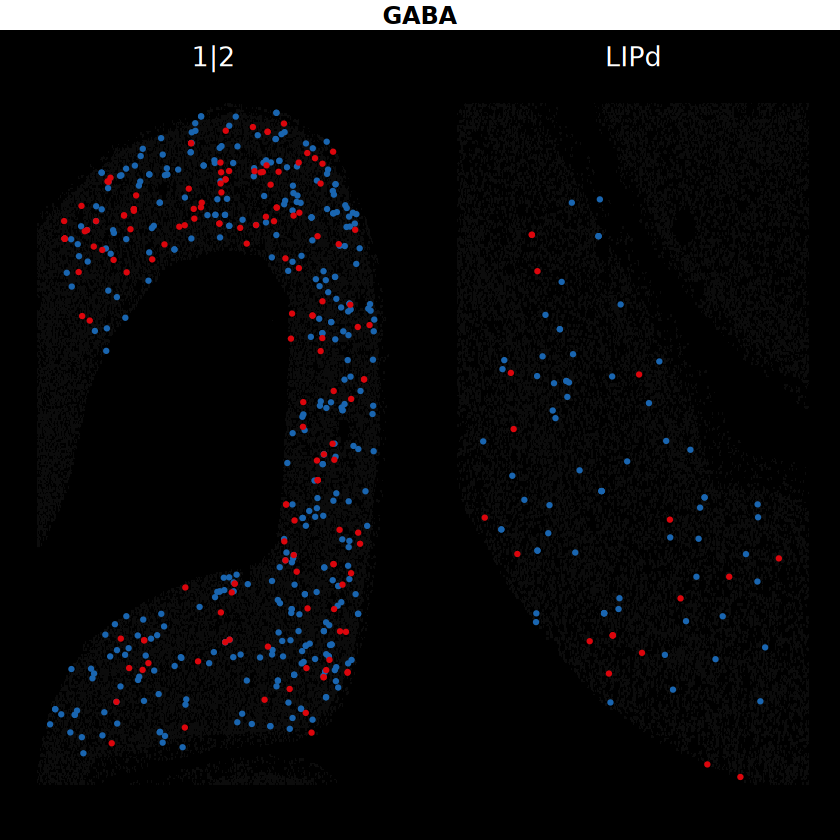

file saved to result/figure4/Lobe_case_spatial_DBNDD2_zoomed_25_04_23.pdf



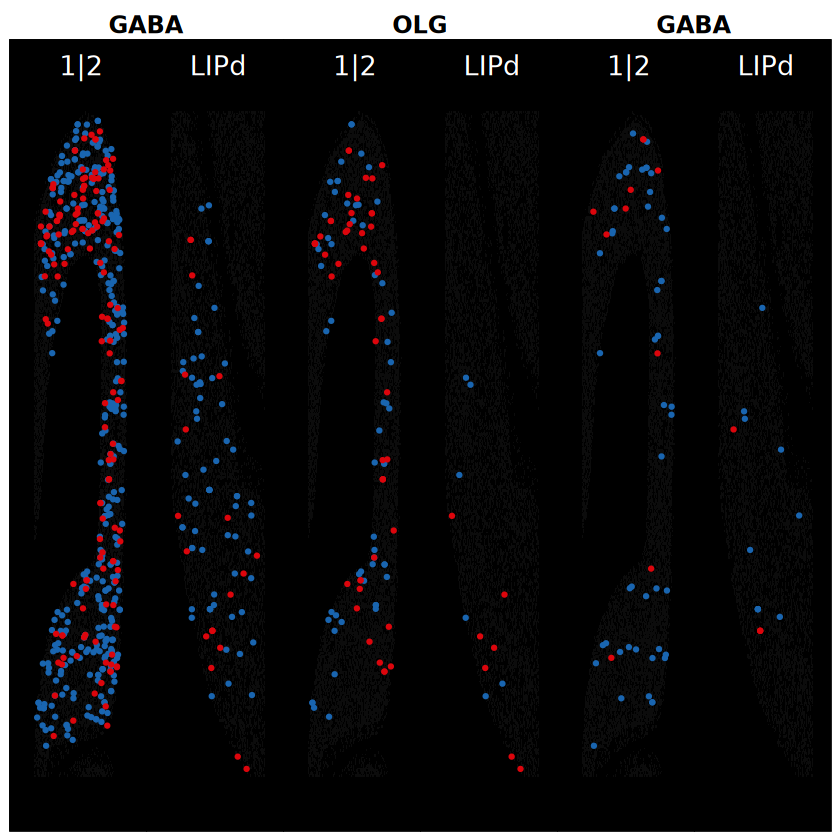

In [49]:

geneex = "DBNDD2"
hubtrans = c('XM_005569136.2','XM_015429879.1')
fsraw.cor$areatr = fsraw.cor$class
pmkpt1 = RTN1CasePlot(c("GABA","GLU","NonNeuron"),geneex,hubtrans)
pmkpt1
fsraw.cor$areatr = fsraw.cor$subclass
pmkpt2 = RTN1CasePlot("OLG",geneex,hubtrans)
#pmkpt1

# fsraw.cor$areatr = fsraw.cor$class
# pmkpt2 = RTN1CasePlot("GABA",geneex,hubtrans)
#pmkpt2
fsraw.cor$areatr = fsraw.cor$class
pmkpt3 = RTN1CasePlot("GABA",geneex,hubtrans)
#pmkpt3
pmkpt = pmkpt1 + pmkpt2 +  pmkpt3
pmkpt
ggexport(pmkpt,filename = "result/figure4/Lobe_case_spatial_DBNDD2_zoomed_25_04_23.pdf",width = 15,height = 3)

`summarise()` has grouped output by 'region'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'region'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'region'. You can override using the
`.groups` argument.
file saved to result/figure4/Lobe_case_spatial_DBNDD2_zoomed_pie_25_04_23.pdf



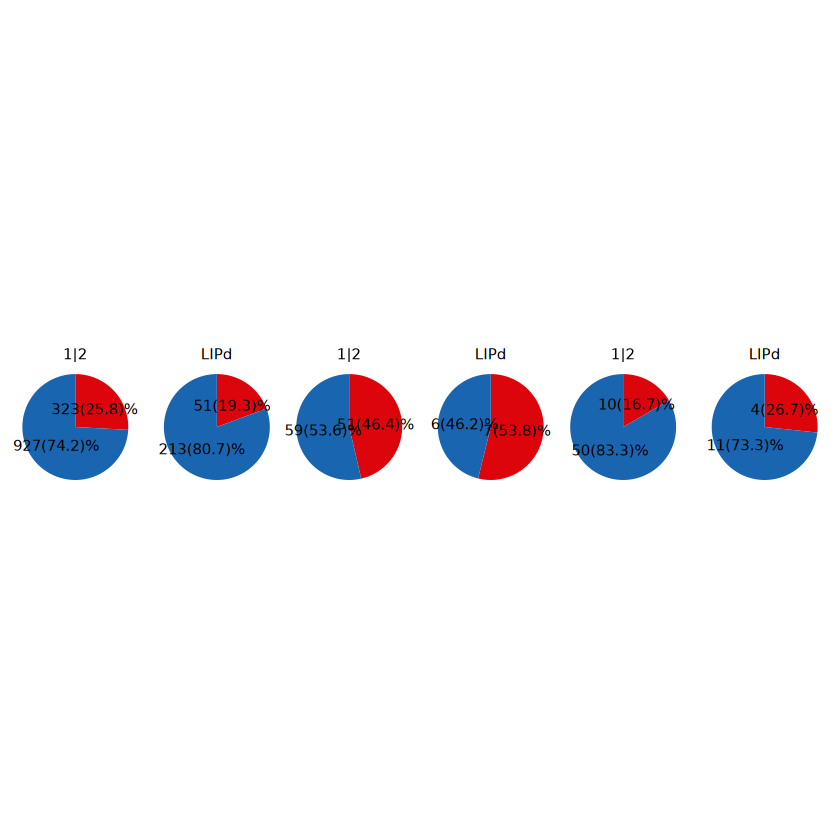

In [52]:
subid = c("1|2","LIPd")
geneex = "DBNDD2"
mkdf = fsraw.cor[fsraw.cor$gene_id == geneex & fsraw.cor$region %in% subid & 
                 fsraw.cor$transcript_id %in% c("XM_005569136.2","XM_015429879.1"),]
p2.1 = PiePlot(mkdf)
mkdf = fsraw.cor[fsraw.cor$gene_id == geneex & fsraw.cor$region %in% subid & 
                 fsraw.cor$subclass %in% "OLG" &
                 fsraw.cor$transcript_id %in% c("XM_005569136.2","XM_015429879.1"),]
p2.2 = PiePlot(mkdf)
mkdf = fsraw.cor[fsraw.cor$gene_id == geneex & fsraw.cor$region %in% subid & 
                 fsraw.cor$class %in% "GABA" &
                 fsraw.cor$transcript_id %in% c("XM_005569136.2","XM_015429879.1"),]
p2.3 = PiePlot(mkdf)
p2.1+p2.2+p2.3
ggexport(p2.1+p2.2+p2.3,filename = "result/figure4/Lobe_case_spatial_DBNDD2_zoomed_pie_25_04_23.pdf",width = 15,height = 3)

In [50]:
mkdf = fsraw.cor[fsraw.cor$gene_id == geneex & fsraw.cor$region %in% subid & 
                 fsraw.cor$subclass != "",]
mkdf$celltype = mkdf$subclass
mkdf[mkdf$subclass != "OLG",]$celltype = "other"
mkdf$celltype = factor(mkdf$celltype,levels = c("other","OLG"))
p3.1 = PiePlotCell(mkdf)

mkdf = fsraw.cor[fsraw.cor$gene_id == geneex & fsraw.cor$region %in% subid & 
                 fsraw.cor$subclass != "",]
mkdf$celltype = mkdf$class
mkdf[mkdf$class != "GABA",]$celltype = "other"
mkdf$celltype = factor(mkdf$celltype,levels = c("other","GABA"))
p3.2 = PiePlotCell(mkdf)
ggexport(p3.1+p3.2,filename = "result/figure4/Lobe_case_spatial_DBNDD2_zoomed_cellporp_pie_25_04_23.pdf",width = 10,height = 3)


`summarise()` has grouped output by 'region'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'region'. You can override using the
`.groups` argument.
file saved to result/figure4/Lobe_case_spatial_DBNDD2_zoomed_cellporp_pie_25_04_23.pdf



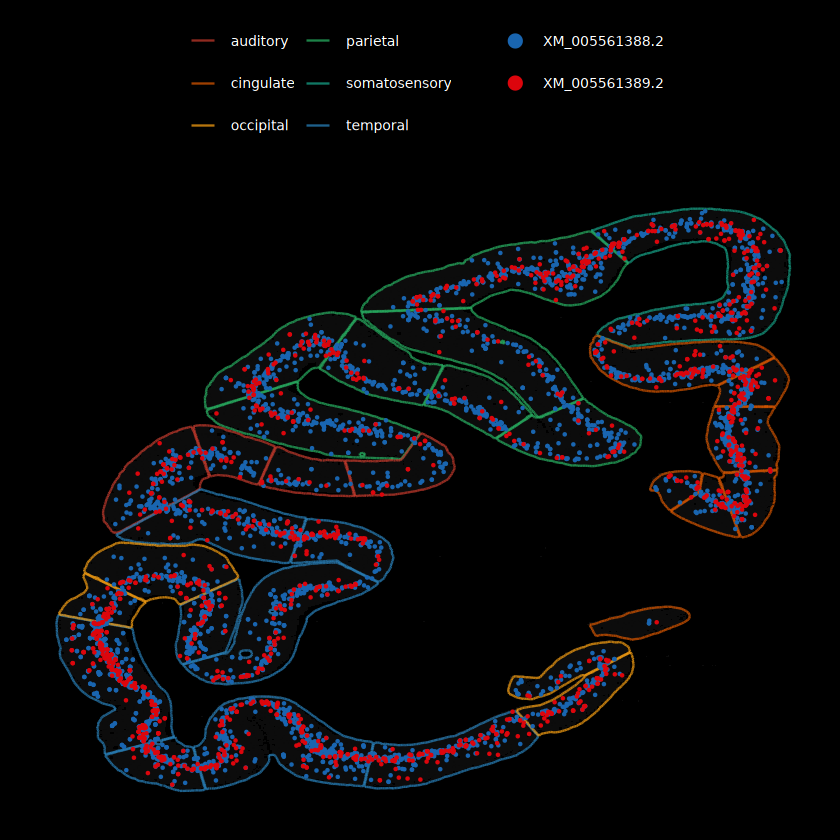

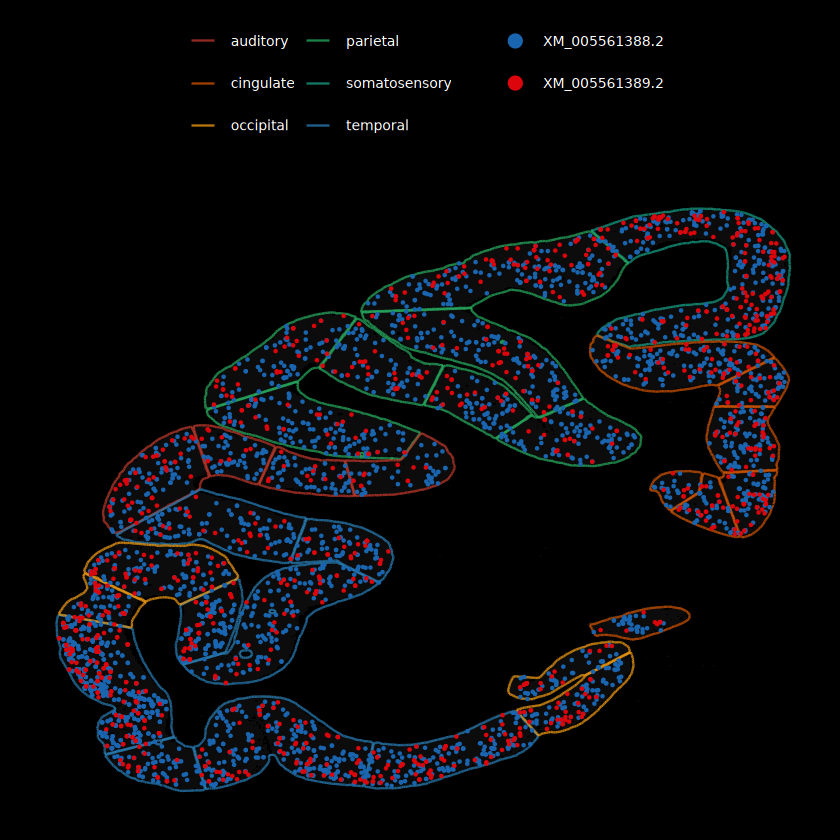

file saved to result/figure5/Lobe_case_spatial_RTN1_24_10_15.pdf



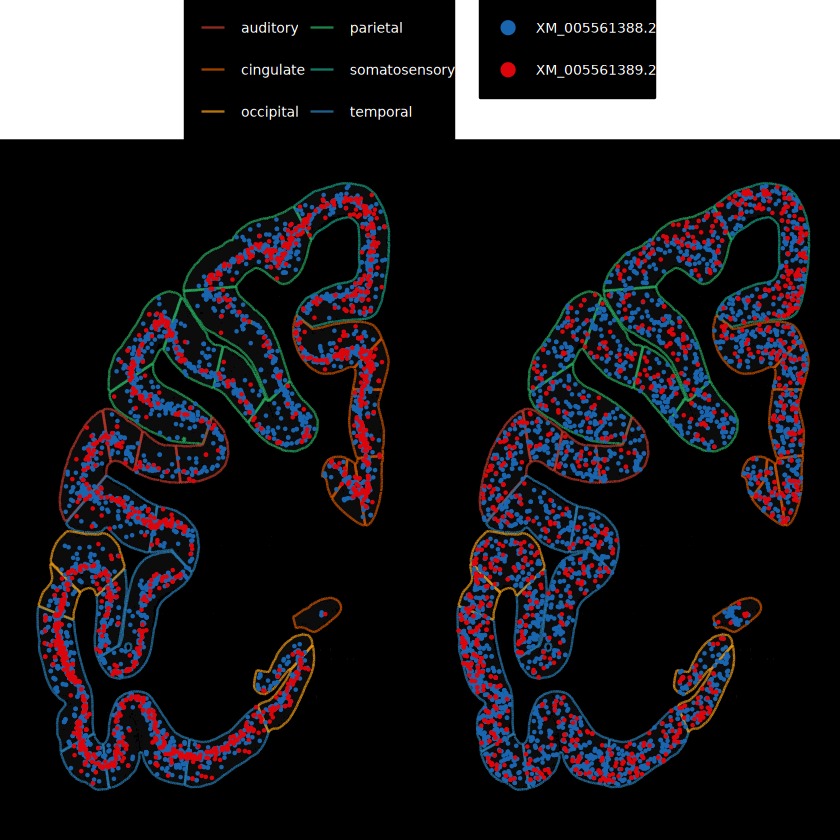

In [884]:
#case2 Lobe
geneex = "RTN1"
isosigi = isosigls$subclass
isosigi = isosigi[isosigi$gene_id %in% geneex,]
hubtrans = unique(isosigi$transcript_id)
mkdf = fsraw.cor[fsraw.cor$gene_id == geneex & fsraw.cor$subclass == "L4/5",]
pmkpti1 = SpCasePlot(mkdf,hubtrans,edgesdf)
pmkpti1

mkdf = fsraw.cor[fsraw.cor$gene_id == geneex & fsraw.cor$class == "GABA",]
mkdf = mkdf[mkdf$transcript_id %in% hubtrans,]
mkdf = mkdf[order(mkdf$transcript_id),]
pmkpti2 = SpCasePlot(mkdf,hubtrans,edgesdf)
pmkpti2
pmkpti = ggarrange(pmkpti1,pmkpti2,nrow = 1, common.legend = T)
pmkpti
#ggexport(pmkpti,filename = "result/figure5/Lobe_case_spatial_RTN1_24_10_15.pdf",width = 8,height = 6)

In [54]:
unique(fsraw.t42$region)
RTN1CasePlot = function(fsraw.cor,subid,geneex,hubtrans,regionid,legend = F,ptsize = 1.5,title = NULL){
    mkdf = fsraw.cor[fsraw.cor$gene_id == geneex & fsraw.cor$areatr %in% subid,]
    #mkdf.zoom = mkdf[mkdf$region == "1|2",]
    pmkpti1 = SpCasePlotZoom(mkdf,hubtrans,regionid[1],fsraw.cor,ptsize)
    pmkpti2 = SpCasePlotZoom(mkdf,hubtrans,regionid[2],fsraw.cor,ptsize)
    if(legend == T){
        pmkpti = ggarrange(pmkpti1,pmkpti2,common.legend = T,legend = "right")
    }else{
        pmkpti = ggarrange(pmkpti1,pmkpti2,common.legend = T,legend = "none")
    }
    pmkpti = annotate_figure(pmkpti, top = text_grob(title, color = "black", face = "bold", size = 14))
    return(pmkpti)
}

[1] "3a/b" "1/2"  "23c"  "23b"  "30"   "31"   "23a"  "29"   "V3v"  "V2"  
[11] "VIP"  "PEa"  "PE"   "TFO"  "LIPv" "CM"   "LIPd" "7op"  "PGa"  "AI"  
[21] "PG"   "FST"  "TEpv" "TPO"  "CL"   "TEO"  "TEa"  "TAa"  "CPB"  "TEpd"

In [37]:
backpt.t42 = unique(fsraw.t42[,c("x","y","region","layer")])
backpt.t47 = unique(fsraw.t47[,c("x","y")])

Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."


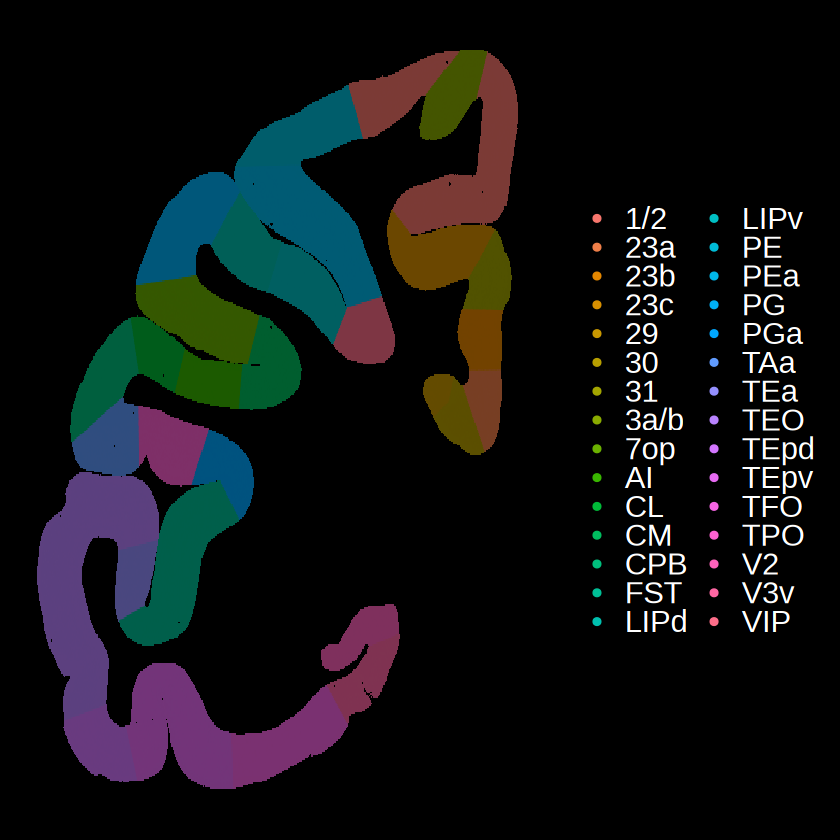

In [41]:
backsize = 0.5
pano.region = ggplot() +
      scattermore::geom_scattermore(
        data = backpt.t42,
        aes(x,y,color = region),
        pointsize = backsize
      ) +
      theme_void() +
      theme_presentation() + 
      theme(legend.title = element_blank(),
            legend.text = element_text(size = 18)) + scale_x_reverse() + scale_y_reverse()
pano.region

In [ ]:
backpt = unique(fsraw.cor[,c("x","y")])

Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
file saved to result/figure4/T44_RTN1_layer_case_bin1_25_12_05.pdf



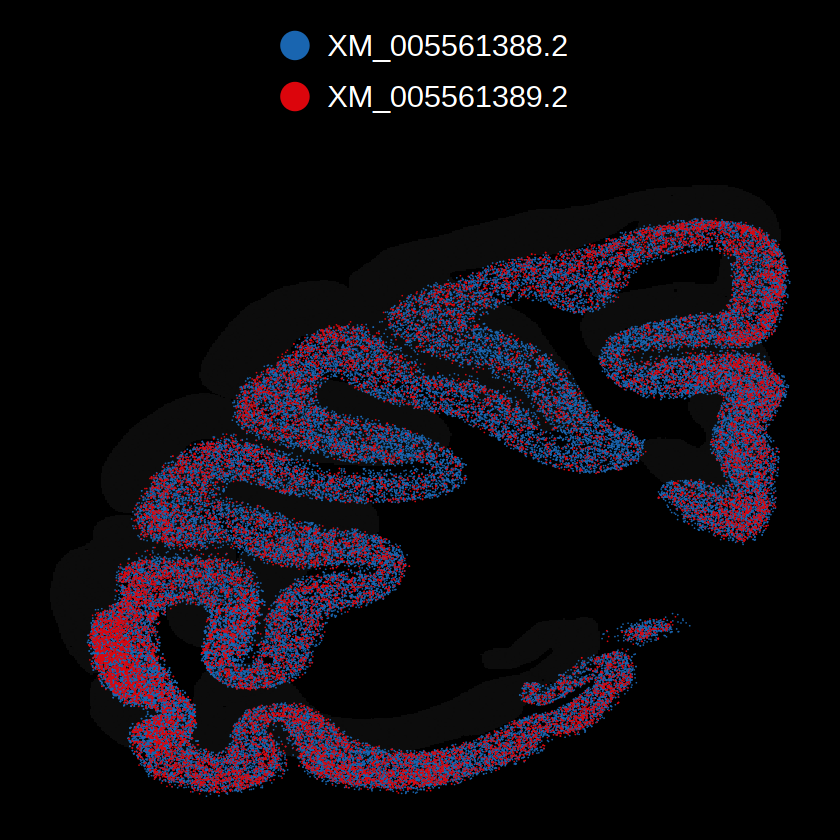

In [ ]:
SpCasePlot = function(fsraw.cor,geneex,hubtrans,backpt,ptsize = 1,backsize = 0.05){
    mkdf = fsraw.cor[fsraw.cor$gene_id == geneex,]
    mkdf = mkdf[mkdf$transcript_id %in% hubtrans,]
    mkdf = mkdf[order(as.numeric(factor(mkdf$transcript_id,levels = hubtrans))),]
    mycolor = distinctColorPalette(length(hubtrans))
    #mkdf = mkdf[order(mkdf$transcript_id),]
    pmkpti1 = ggplot() +
      scattermore::geom_scattermore(
        data = backpt,
        aes(x,y),
        color = "white",
        # pixels = raster.dpi,
        pointsize = backsize
      ) +
      geom_point(data = mkdf,
                 aes(x,y,fill = transcript_id),shape = 21,size = ptsize,stroke = NA) + 
      # geom_segment(data = edgesdf, aes(x = x1, y = y1, xend = x2, yend = y2,color = areatr),
      #            size = 0.5,alpha = 0.75) + 
     # scale_size(range = c(0.05,0.1)) +
      #facet_wrap(~layer,nrow = 2) 
      theme_void() +
      scale_fill_discreterainbow() +
      #scale_fill_manual(values = mycolor) +
      #scale_color_flatui() +
      theme_presentation() + 
      theme(legend.position = "top",legend.title = element_blank(),
            legend.text = element_text(size = 18)) +
      guides(color = guide_legend(override.aes = list(size=8),nrow = 3),
            fill = guide_legend(override.aes = list(size=8),nrow = 2),
            size = "none")
      #scale_y_reverse() + scale_x_reverse()
    return(pmkpti1)
}
geneex = "RTN1"
transid = c("XM_005561388.2","XM_005561389.2")

fsraw.hub = fsraw.cor[fsraw.cor$gene_id == "RTN1",]
pc2 = SpCasePlot(fsraw.hub,geneex,transid,backpt,0.2)
pc2 = pc2 + scale_x_reverse() + scale_y_reverse()
pc2
fileid = paste0("result/figure4/T44_",geneex,"_layer_case_bin1_25_12_05.pdf")
ggexport(pc2,filename = fileid,width = 4,height = 6)

In [78]:
nrow(fsraw.cor[fsraw.cor$gene_id == "RTN1",])

[1] 94440

Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the ele

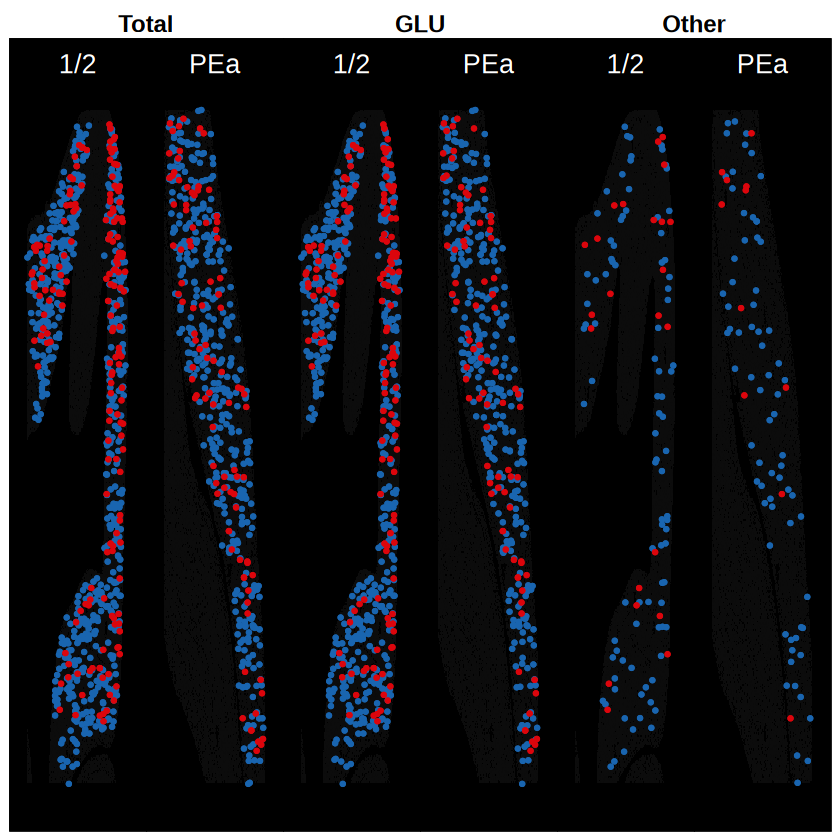

In [56]:
regionid = c("1/2","PEa")
geneex = "RTN1"
hubtrans = c("XM_005561388.2","XM_005561389.2")
fsraw.hub$areatr = fsraw.hub$class
backpt = backpt.t42
pmkpt1 = RTN1CasePlot(fsraw.hub,c("GABA","GLU","NonNeuron"),geneex,hubtrans,regionid,F,title = "Total")
#pmkpt1
# fsraw.hub$areatr = fsraw.hub$subclass
pmkpt2 = RTN1CasePlot(fsraw.hub,"GLU",geneex,hubtrans,regionid,title = "GLU")
pmkpt3 = RTN1CasePlot(fsraw.hub,c("GABA","NonNeuron"),geneex,hubtrans,regionid,title = "Other")
#pmkpt3
library(Seurat)
pmkpt = pmkpt1 + pmkpt2 +  pmkpt3
pmkpt
ggexport(pmkpt,filename = "result/figure4/Lobe_case_spatial_RTN1_zoomed_T42_25_12_04.pdf",width = 15,height = 3)

# ggexport(p3.1+p3.2,filename = "result/figure4/Lobe_case_spatial_RTN1_zoomed_cellporp_pie_25_12_04.pdf",width = 10,height = 3)


Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the ele

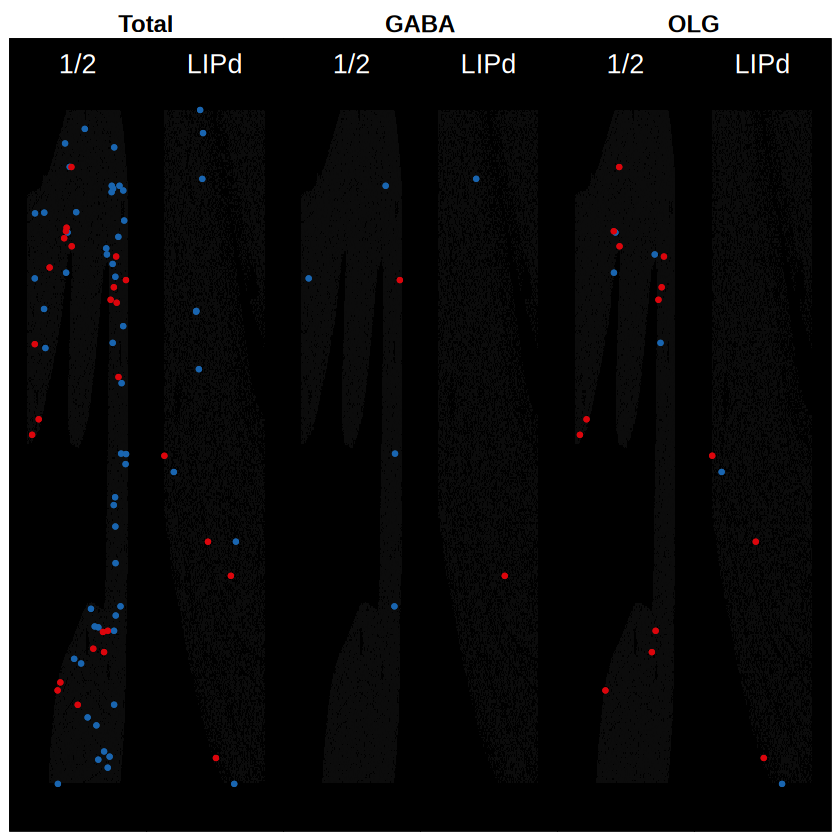

In [58]:
regionid = c("1/2","LIPd")
geneex = "DBNDD2"
hubtrans = c("XM_005569136.2","XM_015429879.1")
fsraw.hub = fsraw.t42[fsraw.t42$gene_id == geneex,]
fsraw.hub$areatr = fsraw.hub$class
backpt = backpt.t42
pmkpt1 = RTN1CasePlot(fsraw.hub,c("GABA","GLU","NonNeuron"),geneex,hubtrans,regionid,F,title = "Total")
#pmkpt1
# fsraw.hub$areatr = fsraw.hub$subclass
pmkpt2 = RTN1CasePlot(fsraw.hub,"GABA",geneex,hubtrans,regionid,title = "GABA")
fsraw.hub$areatr = fsraw.hub$subclass
pmkpt3 = RTN1CasePlot(fsraw.hub,c("OLG"),geneex,hubtrans,regionid,title = "OLG")
#pmkpt3
library(Seurat)
pmkpt = pmkpt1 + pmkpt2 +  pmkpt3
pmkpt
# ggexport(pmkpt,filename = "result/figure4/Lobe_case_spatial_RTN1_zoomed_T42_25_12_04.pdf",width = 15,height = 3)

# ggexport(p3.1+p3.2,filename = "result/figure4/Lobe_case_spatial_RTN1_zoomed_cellporp_pie_25_12_04.pdf",width = 10,height = 3)


mkdf = fsraw.hub[fsraw.hub$gene_id == geneex & fsraw.hub$region %in% regionid & 
                 fsraw.hub$transcript_id %in% hubtrans &
                 fsraw.hub$subclass != "",]
p2.1 = PiePlot(mkdf)
mkdf = fsraw.hub[fsraw.hub$gene_id == geneex & fsraw.hub$region %in% regionid &  
                 fsraw.hub$transcript_id %in% hubtrans &
                 fsraw.hub$subclass == "OLG",]
p2.2 = PiePlot(mkdf)
mkdf = fsraw.hub[fsraw.hub$gene_id == geneex & fsraw.hub$region %in% regionid &  
                 fsraw.hub$transcript_id %in% hubtrans &
                 fsraw.hub$class == "GABA",]
p2.3 = PiePlot(mkdf)
p2.1+p2.2+p2.3
# ggexport(p2.1+p2.2+p2.3,filename = "result/figure4/Lobe_case_spatial_RTN1_zoomed_cellporp_pie_T42_25_12_04.pdf",width = 10,height = 3)


`summarise()` has grouped output by 'group', 'areatr', 'chunk', 'gene_id'. You
can override using the `.groups` argument.
Warning message:
"Computation failed in `stat_compare_means()`.
Caused by error in `dplyr::mutate()`:
! Can't transform a data frame with duplicate names."
`summarise()` has grouped output by 'group', 'areatr', 'chunk', 'gene_id'. You
can override using the `.groups` argument.
Warning message:
"Computation failed in `stat_compare_means()`.
Caused by error in `t.test.default()`:
! data are essentially constant"


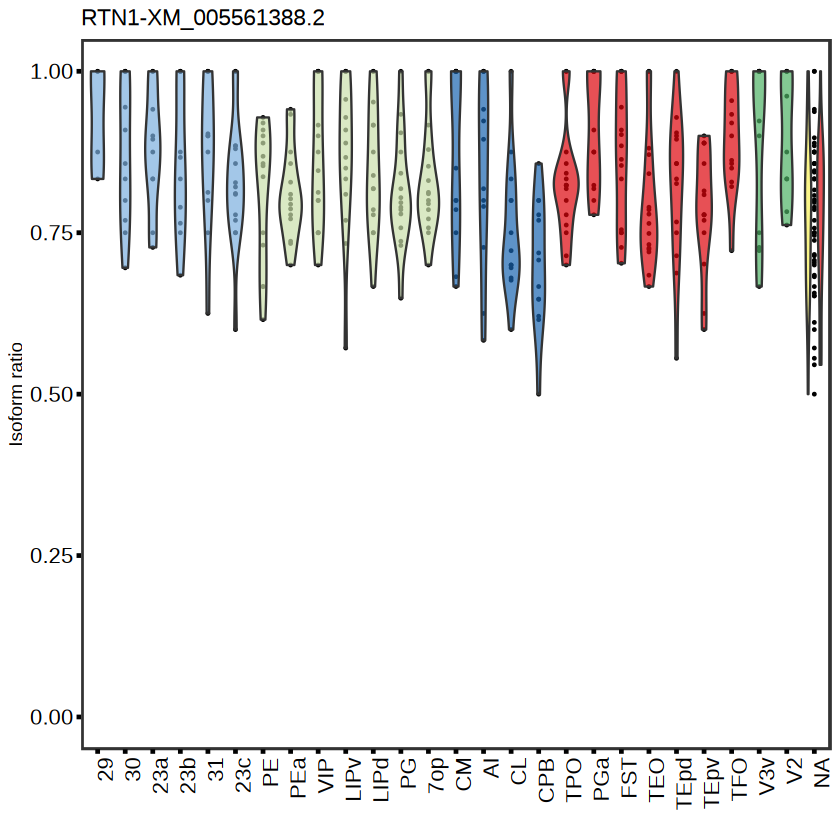

Warning message:
"Computation failed in `stat_compare_means()`.
Caused by error in `dplyr::mutate()`:
! Can't transform a data frame with duplicate names."
Warning message:
"Computation failed in `stat_compare_means()`.
Caused by error in `t.test.default()`:
! data are essentially constant"
file saved to result/figure4/Lobe_case_spatial_RTN1_boxplot_T42_25_12_05.pdf



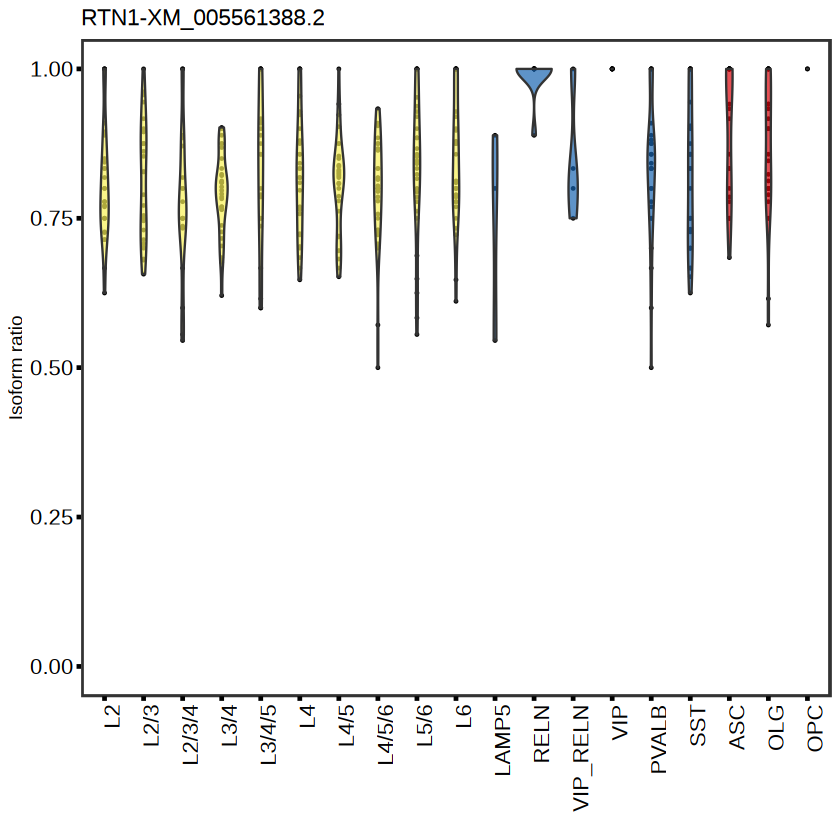

In [73]:
geneex = "RTN1"
fsraw.hub = fsraw.t42r[fsraw.t42r$layer %in% paste0("l",1:6) & fsraw.t42r$gene_id %in% geneex,]
fsraw.hub = fsraw.hub %>% group_by(readid) %>% filter(transcript_id == "XM_005561388.2" | sum(transcript_id %in% "XM_005561388.2") == 0)
fsraw.hub$areatr = fsraw.hub$region
fsraw.hub$chunk = fsraw.hub$subclass
fsraw.hub = merge(fsraw.hub,areaan,by.x = "region",by.y = "area")
fsraw.hub$group = fsraw.hub$lobe
isosigi = isosigls.t42$region
#pc1.1 = ModuleCasePlot(isosigi,"CAPRIN1",fsraw.cor,2,lobeorder)
pc1.1 = ModuleCasePlot(isosigi,"RTN1",fsraw.hub,1,regionorder,suborder)
pc1.1

fsraw.hub$areatr = fsraw.hub$subclass
fsraw.hub$chunk = fsraw.hub$region
fsraw.hub$group = fsraw.hub$class
pc1.2 = ModuleCasePlot(isosigi,"RTN1",fsraw.hub,1,suborder,regionorder)
pc1.2
ggexport(pc1.1+pc1.2,
         filename = "result/figure4/Lobe_case_spatial_RTN1_boxplot_T42_25_12_05.pdf",width = 10,height = 3)


In [ ]:
subid = c("1|2","LIPd")
geneex = "DBNDD2"
mkdf = fsraw.cor[fsraw.cor$gene_id == geneex & fsraw.cor$region %in% subid & 
                 fsraw.cor$transcript_id %in% c("XM_005569136.2","XM_015429879.1"),]
p2.1 = PiePlot(mkdf)
mkdf = fsraw.cor[fsraw.cor$gene_id == geneex & fsraw.cor$region %in% subid & 
                 fsraw.cor$subclass %in% "OLG" &
                 fsraw.cor$transcript_id %in% c("XM_005569136.2","XM_015429879.1"),]
p2.2 = PiePlot(mkdf)
mkdf = fsraw.cor[fsraw.cor$gene_id == geneex & fsraw.cor$region %in% subid & 
                 fsraw.cor$class %in% "GABA" &
                 fsraw.cor$transcript_id %in% c("XM_005569136.2","XM_015429879.1"),]
p2.3 = PiePlot(mkdf)
p2.1+p2.2+p2.3
ggexport(p2.1+p2.2+p2.3,filename = "result/figure4/Lobe_case_spatial_DBNDD2_zoomed_pie_25_04_23.pdf",width = 15,height = 3)

In [902]:
edgesdf2 = pref$layeredges
edgesdf2 = edgesdf2[edgesdf2$areaid %in% unique(fsraw.cor$layer),]
head(edgesdf2)
edgesdf2$areatr = edgesdf2$areaid
#edgesdf = merge(edgesdf,areaan,by.x = "areaid",by.y = "area")
#unique(edgesdf$areaid)

ind1  ind2  x1    y1    x2    y2    mx1      my1      mx2      my2     
1385  7285 15438 46436 64705 46518 64693 46540.49 65132.87 46469.34 64646.63
1386 16616 14951 46175 64676 46269 64674 46231.50 65121.50 46222.69 64707.37
1387 33735 16616 46030 64696 46175 64676 46208.15 65451.96 46115.36 64779.21
1388  3003 20924 46995 64656 46782 64591 46877.42 64659.80 46837.73 64789.86
1389  4687 20924 46649 64706 46782 64591 46837.73 64789.86 46793.15 64738.31
1390 32454 32318 47230 64665 47072 64696 47156.98 64710.96 47480.06 66357.65
     bp1 bp2 areaid
1385 0   0   l1    
1386 0   0   l1    
1387 0   0   l1    
1388 0   0   l1    
1389 0   0   l1    
1390 0   0   l1

In [953]:
geneex = "DDRGK1"
genest = fsraw.cor[fsraw.cor$gene_id == geneex,] %>% group_by(subclass) %>% summarise(count = length(unique(readid)))
genest
genest2 = fsraw.cor[fsraw.cor$gene_id == geneex,] %>% group_by(layer,subclass) %>% summarise(count = length(unique(readid)))
genest2[genest2$subclass == "L2/3",]

subclass count
1           19273
2  ASC        351
3  L2         972
4  L2/3      2670
5  L2/3/4     504
6  L3/4      1043
7  L3/4/5      88
8  L4         774
9  L4/5       824
10 L4/5/6     457
11 L5/6       568
12 L6         411
13 LAMP5       75
14 MG          29
15 OLG        464
16 OPC         77
17 PVALB      298
18 PV_CHC      10
19 RELN       132
20 SST        365
21 VIP        101
22 VIP_RELN   110
23 VLMC         4

`summarise()` has grouped output by 'layer'. You can override using the
`.groups` argument.


layer subclass count
1 l1    L2/3        8 
2 l2    L2/3      497 
3 l3    L2/3     2063 
4 l4    L2/3       39 
5 l5    L2/3       26 
6 l6    L2/3       37

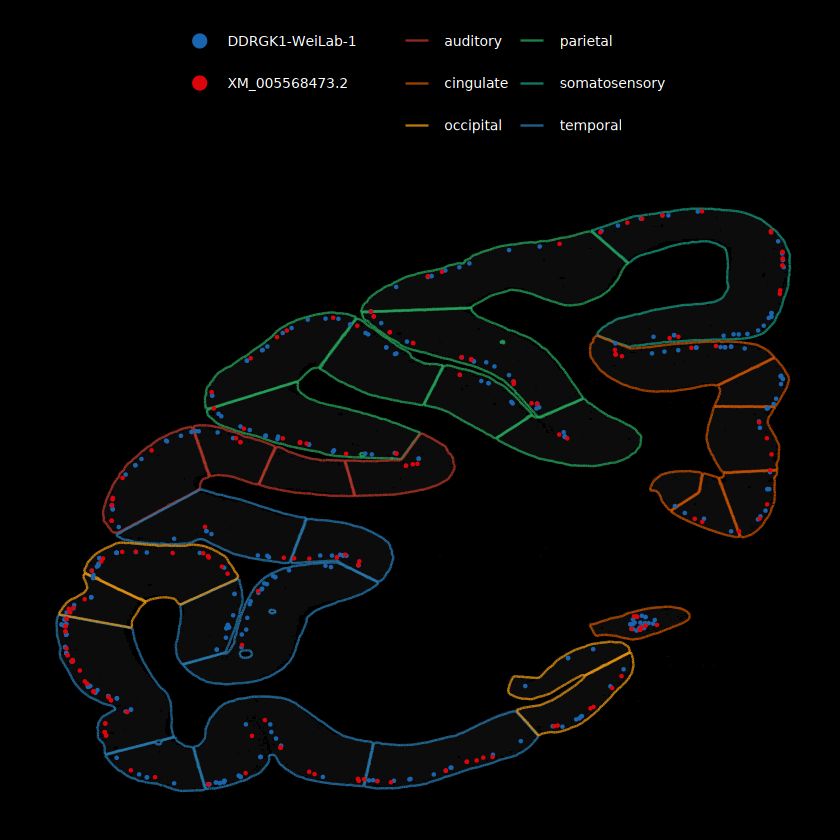

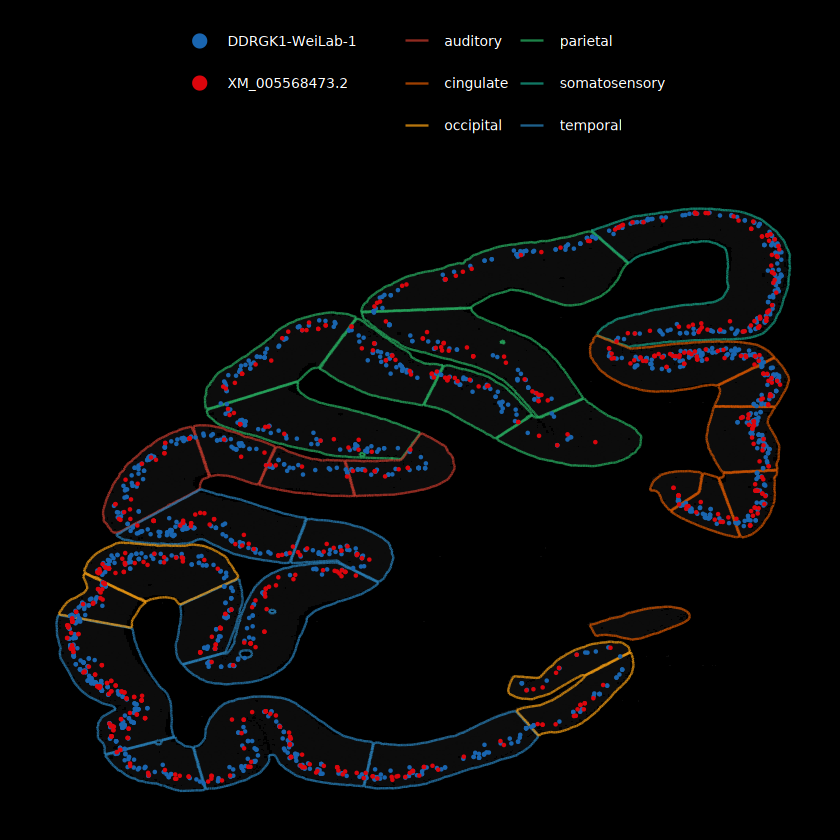

file saved to result/figure5/Lobe_case_spatial_DDRGK1_24_10_15.pdf



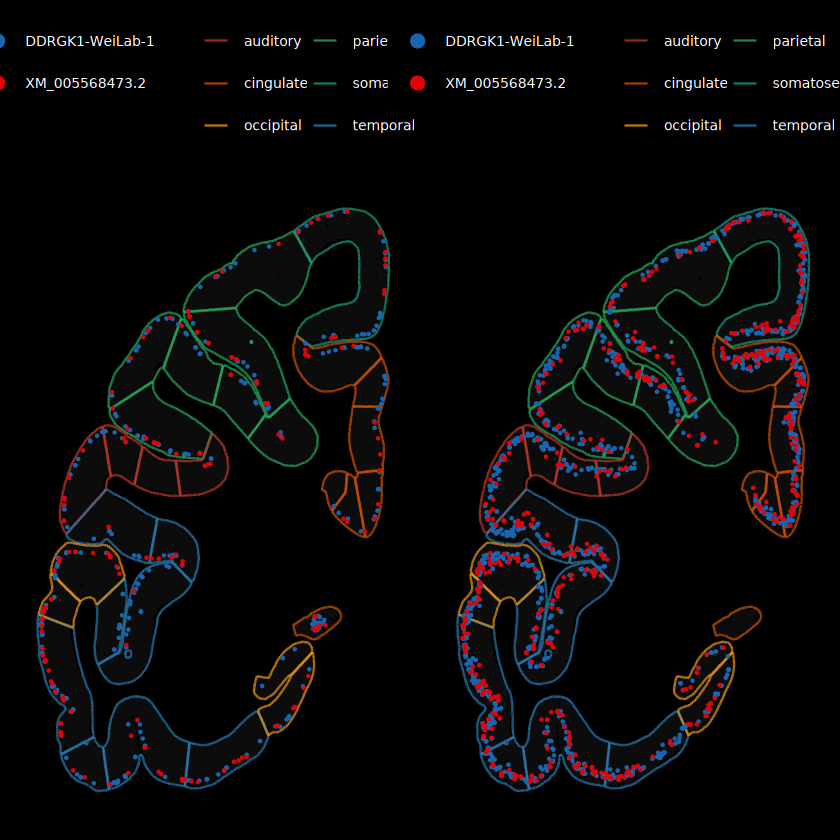

In [956]:
#case2 Lobe
geneex = "DDRGK1"
isosigi = isosigls$subclass
isosigi = isosigi[isosigi$gene_id %in% geneex & isosigi$sig != "N",]
hubtrans = unique(isosigi$transcript_id)
mkdf = fsraw.cor[fsraw.cor$gene_id == geneex & fsraw.cor$subclass %in% c("L2/3") & fsraw.cor$layer == "l2",]
mkdf = mkdf[order(mkdf$transcript_id),]
pmkpti1 = SpCasePlot(mkdf,hubtrans,edgesdf)
pmkpti1

# geneex = "ARPP19"
# isosigi = isosigls$subclass
# isosigi = isosigi[isosigi$gene_id %in% geneex & isosigi$sig != "N",]
# hubtrans = unique(isosigi$transcript_id)
mkdf = fsraw.cor[fsraw.cor$gene_id == geneex & fsraw.cor$subclass %in% c("L2/3")  & fsraw.cor$layer == "l3",]
mkdf = mkdf[order(mkdf$transcript_id),]
pmkpti2 = SpCasePlot(mkdf,hubtrans,edgesdf)
pmkpti2
pmkpti = ggarrange(pmkpti1,pmkpti2,nrow = 1)
pmkpti
ggexport(pmkpti,filename = "result/figure5/Lobe_case_spatial_DDRGK1_24_10_15.pdf",width = 8,height = 6)

In [244]:
qsave(list("layer" = cellprop.layer.md,"lobe" = cellprop.lobe.md), file = "result/figure4/cell_prop_md_longread.qs")